In [98]:
!export AUTOGRAPH_VERBOSITY=0
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(100)

In [65]:
%load_ext autoreload
%autoreload 2
import cantera as ct
import os
import gym 
import numpy as np 
import pandas as pd
from stable_baselines.common.policies import MlpPolicy, CnnLstmPolicy,MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common import set_global_seeds
from stable_baselines import ACKTR, PPO2
from envs.sim_env import SimEnv, NO_idx, CO_idx, O2_idx, H2O_idx
from envs.SimUtils import solvePhi_airSplit, equil, runMainBurner, correctNOx
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
model = PPO2.load('Trained Models/PPO2_MlpLstmPolicy_11072019_500000.zip')

In [89]:
from stable_baselines.common.vec_env import DummyVecEnv
env = DummyVecEnv([SimEnv])
# env = SimEnv()
obs = env.reset()

In [90]:
game_over = False
results_list = []
while not game_over: 
    action, _states = model.predict(obs)
    obs, rewards, game_over, info = env.step(action)
    env.render(mode='human')
    g = env.envs[0].sec_stage_gas
    results_list.append([
        env.envs[0].age/1e-3, 
        g.T, 
        correctNOx(g.X[NO_idx], g.X[H2O_idx], g.X[O2_idx]),
        correctNOx(g.X[CO_idx], g.X[H2O_idx], g.X[O2_idx]),
        env.envs[0].mfc_main.mdot(0),
        env.envs[0].mfc_fuel_sec.mdot(0),
        env.envs[0].mfc_air_sec.mdot(0), 
        rewards])

step|age_(ms)|T|phi_norm|NO|CO|Rem_Main|Rem_SecFuel|Rem_SecAir|Mdot_Main|Mdot_SecFuel|Mdot_SecAir|Reward|Reward_T|Reward_NO|Reward_CO
1| 0.00| 1480.98| -0.00| 0.07| 1.23| 88.67| 1.69| 9.64| 10.64| 0.00| 0.00| -138.68| -424.54|5.00|280.87
2| 0.00| 1480.75| -0.00| 0.07| 1.28| 88.67| 1.69| 9.64| 11.44| 0.00| 0.29| -140.80| -424.95|5.00|279.16
3| 0.00| 1486.65| -0.00| 0.07| 1.29| 88.67| 1.69| 9.64| 10.72| 0.00| 0.00| -130.92| -414.57|5.00|278.68
4| 0.00| 1489.76| -0.00| 0.07| 1.30| 88.67| 1.69| 9.64| 11.14| 0.00| 0.00| -125.77| -409.19|5.00|278.46
5| 0.00| 1491.59| -0.00| 0.07| 1.30| 88.67| 1.69| 9.64| 10.87| 0.00| 0.00| -122.74| -406.05|5.00|278.36
6| 0.01| 1492.60| -0.00| 0.07| 1.30| 88.67| 1.69| 9.64| 8.72| 0.00| 0.00| -121.03| -404.32|5.00|278.35
7| 0.01| 1493.50| -0.00| 0.07| 1.30| 88.67| 1.69| 9.64| 10.34| 0.00| 0.00| -119.52| -402.79|5.00|278.34
8| 0.01| 1494.17| -0.00| 0.07| 1.30| 88.67| 1.69| 9.64| 10.18| 0.00| 0.00| -118.38| -401.66|5.00|278.36
9| 0.01| 1494.68| -0.00| 0.07| 1.30

86| 0.09| 1462.75| 0.21| 0.06| 59.18| 88.67| 1.69| 9.64| 9.99| 0.00| 0.00| -1193.41| -457.89|5.00|-739.65
87| 0.09| 1463.32| 0.21| 0.06| 61.92| 88.67| 1.69| 9.64| 11.10| 0.00| 0.00| -1389.04| -456.83|5.00|-936.34
88| 0.09| 1463.78| 0.21| 0.06| 64.98| 88.67| 1.69| 9.64| 8.55| 0.00| 0.00| -1645.71| -455.96|5.00|-1193.87
89| 0.09| 1464.27| 0.21| 0.06| 68.16| 88.67| 1.69| 9.64| 9.41| 0.00| 0.00| -1957.65| -455.04|5.00|-1506.72
90| 0.09| 1464.75| 0.20| 0.05| 71.53| 88.67| 1.69| 9.64| 9.21| 0.00| 0.00| -2344.08| -454.14|5.00|-1894.03
91| 0.09| 1465.26| 0.20| 0.05| 75.02| 88.67| 1.69| 9.64| 10.27| 0.00| 0.00| -2808.42| -453.18|5.00|-2359.33
92| 0.09| 1463.95| 0.21| 0.05| 78.46| 88.67| 1.69| 9.64| 10.02| 0.47| 0.00| -3336.96| -455.65|5.00|-2885.38
93| 0.09| 1464.52| 0.21| 0.05| 82.08| 88.67| 1.69| 9.64| 11.68| 0.00| 0.00| -3969.58| -454.57|5.00|-3519.08
94| 0.09| 1465.04| 0.21| 0.05| 86.02| 88.67| 1.69| 9.64| 10.21| 0.00| 0.00| -4758.14| -453.61|5.00|-4308.59
95| 0.09| 1465.52| 0.20| 0.05| 90.

171| 0.17| 1553.88| 0.20| 0.04| 4758.82| 88.67| 1.69| 9.64| 7.90| 0.40| 0.00| -2058428611.18| -309.92|5.00|-2058428304.55
172| 0.17| 1559.11| 0.20| 0.04| 4969.50| 88.67| 1.69| 9.64| 11.18| 0.00| 0.00| -2345706085.17| -302.73|5.00|-2345705785.73
173| 0.17| 1564.67| 0.20| 0.04| 5193.66| 88.67| 1.69| 9.64| 10.15| 0.00| 0.00| -2679439307.42| -295.23|5.00|-2679439015.46
174| 0.17| 1570.56| 0.19| 0.04| 5429.41| 88.67| 1.69| 9.64| 10.20| 0.00| 0.00| -3063093601.94| -287.42|5.00|-3063093317.78
175| 0.17| 1576.86| 0.19| 0.04| 5677.77| 88.67| 1.69| 9.64| 9.70| 0.00| 0.00| -3505141738.01| -279.26|5.00|-3505141461.99
176| 0.18| 1583.53| 0.18| 0.05| 5935.31| 88.67| 1.69| 9.64| 10.15| 0.00| 0.00| -4006408874.96| -270.80|5.00|-4006408607.40
177| 0.18| 1590.43| 0.18| 0.05| 6201.81| 88.67| 1.69| 9.64| 10.07| 0.00| 0.40| -4573224242.84| -262.24|5.00|-4573223983.83
178| 0.18| 1597.97| 0.17| 0.05| 6477.23| 88.67| 1.69| 9.64| 9.37| 0.00| 0.00| -5212710202.95| -253.12|5.00|-5212709953.05
179| 0.18| 1606.00|

250| 0.25| 1801.35| 0.01| 0.21| 1206.20| 88.66| 1.69| 9.64| 9.58| 0.18| 0.00| -31951659.76| -77.49|5.00|-31951584.77
251| 0.25| 1801.51| 0.01| 0.21| 1176.84| 88.66| 1.69| 9.64| 8.23| 0.00| 0.00| -29626953.68| -77.39|5.00|-29626878.78
252| 0.25| 1801.05| 0.01| 0.21| 1152.91| 88.66| 1.69| 9.64| 10.37| 0.24| 0.00| -27817936.39| -77.67|5.00|-27817861.21
253| 0.25| 1801.24| 0.01| 0.21| 1142.17| 88.66| 1.69| 9.64| 10.31| 0.00| 0.00| -27030830.38| -77.55|5.00|-27030755.30
254| 0.25| 1801.08| 0.01| 0.21| 1126.40| 88.66| 1.69| 9.64| 10.93| 0.00| 0.18| -25901620.85| -77.65|5.00|-25901545.66
255| 0.25| 1800.97| 0.01| 0.22| 1102.51| 88.66| 1.69| 9.64| 9.25| 0.00| 0.00| -24251553.27| -77.71|5.00|-24251478.01
256| 0.26| 1800.55| 0.01| 0.22| 1071.89| 88.66| 1.69| 9.64| 10.75| 0.00| 0.00| -22241787.56| -77.97|5.00|-22241712.03
257| 0.26| 1799.97| 0.01| 0.22| 1037.59| 88.66| 1.69| 9.64| 11.12| 0.00| 0.00| -20125747.74| -78.32|5.00|-20125671.86
258| 0.26| 1799.37| 0.01| 0.22| 1001.83| 88.66| 1.69| 9.64|

333| 0.33| 1807.08| 0.01| 0.30| 720.18| 88.66| 1.69| 9.64| 9.66| 0.00| 0.00| -6508447.47| -74.08|5.00|-6508375.06
334| 0.33| 1807.90| 0.01| 0.30| 763.98| 88.66| 1.69| 9.64| 10.42| 0.00| 0.08| -7818679.15| -73.60|5.00|-7818607.22
335| 0.34| 1808.50| 0.01| 0.30| 791.84| 88.66| 1.69| 9.64| 10.21| 0.00| 0.00| -8737097.88| -73.24|5.00|-8737026.28
336| 0.34| 1808.80| 0.01| 0.31| 802.52| 88.66| 1.69| 9.64| 10.56| 0.00| 0.00| -9107765.84| -73.07|5.00|-9107694.41
337| 0.34| 1808.91| 0.01| 0.31| 799.56| 88.66| 1.69| 9.64| 9.92| 0.00| 0.00| -9003825.46| -73.00|5.00|-9003754.09
338| 0.34| 1808.59| 0.01| 0.31| 786.73| 88.66| 1.69| 9.64| 11.38| 0.00| 0.44| -8563623.74| -73.19|5.00|-8563552.17
339| 0.34| 1807.59| 0.01| 0.31| 781.91| 88.66| 1.69| 9.64| 12.10| 0.78| 0.00| -8402051.19| -73.78|5.00|-8401979.02
340| 0.34| 1808.55| 0.01| 0.31| 809.58| 88.66| 1.69| 9.64| 9.14| 0.00| 0.00| -9358077.35| -73.21|5.00|-9358005.73
341| 0.34| 1809.21| 0.01| 0.31| 834.35| 88.66| 1.69| 9.64| 10.25| 0.00| 0.00| -1027

411| 0.41| 1826.15| 0.01| 0.39| 706.05| 88.66| 1.69| 9.64| 8.92| 0.53| 0.00| -6119249.27| -63.21|5.00|-6119186.95
412| 0.41| 1826.69| 0.01| 0.39| 729.50| 88.66| 1.69| 9.64| 9.71| 0.26| 0.00| -6774001.44| -62.91|5.00|-6773939.41
413| 0.41| 1827.54| 0.01| 0.39| 755.66| 88.66| 1.69| 9.64| 9.40| 0.00| 0.00| -7557198.02| -62.44|5.00|-7557136.46
414| 0.41| 1828.06| 0.01| 0.39| 768.24| 88.66| 1.69| 9.64| 10.22| 0.00| 0.00| -7954815.17| -62.15|5.00|-7954753.88
415| 0.42| 1828.31| 0.01| 0.40| 765.80| 88.66| 1.69| 9.64| 10.15| 0.00| 0.00| -7876693.93| -62.02|5.00|-7876632.76
416| 0.42| 1828.50| 0.01| 0.40| 752.71| 88.66| 1.69| 9.64| 8.20| 0.00| 0.00| -7465978.57| -61.91|5.00|-7465917.50
417| 0.42| 1828.31| 0.01| 0.40| 732.58| 88.66| 1.69| 9.64| 11.35| 0.00| 0.00| -6863291.47| -62.02|5.00|-6863230.29
418| 0.42| 1828.06| 0.01| 0.40| 709.02| 88.66| 1.69| 9.64| 10.81| 0.00| 0.00| -6199830.50| -62.16|5.00|-6199769.17
419| 0.42| 1827.83| 0.01| 0.40| 684.11| 88.66| 1.69| 9.64| 9.55| 0.00| 0.00| -554647

494| 0.49| 1843.43| 0.01| 0.48| 677.78| 88.66| 1.69| 9.64| 9.18| 0.61| 0.00| -5387951.34| -53.94|5.00|-5387897.46
495| 0.50| 1844.10| 0.01| 0.48| 683.47| 88.66| 1.69| 9.64| 8.15| 0.00| 0.00| -5530355.07| -53.59|5.00|-5530301.53
496| 0.50| 1844.46| 0.01| 0.48| 684.12| 88.66| 1.69| 9.64| 9.70| 0.00| 0.00| -5546612.20| -53.40|5.00|-5546558.84
497| 0.50| 1844.47| 0.01| 0.48| 674.05| 88.66| 1.69| 9.64| 11.77| 0.00| 0.00| -5296035.65| -53.40|5.00|-5295982.28
498| 0.50| 1844.49| 0.01| 0.48| 656.95| 88.66| 1.69| 9.64| 9.12| 0.00| 0.00| -4888157.31| -53.39|5.00|-4888103.94
499| 0.50| 1844.31| 0.01| 0.48| 635.78| 88.66| 1.69| 9.64| 10.66| 0.00| 0.00| -4412822.72| -53.48|5.00|-4412769.25
500| 0.50| 1844.09| 0.00| 0.48| 612.92| 88.66| 1.69| 9.64| 10.21| 0.00| 0.00| -3935405.84| -53.59|5.00|-3935352.25
501| 0.50| 1843.52| 0.01| 0.49| 599.05| 88.66| 1.69| 9.64| 10.60| 0.61| 0.00| -3663129.26| -53.89|5.00|-3663075.36
502| 0.50| 1844.02| 0.01| 0.49| 607.34| 88.66| 1.69| 9.64| 9.48| 0.00| 0.00| -382419

574| 0.57| 1851.43| 0.01| 0.55| 631.65| 88.66| 1.69| 9.64| 10.37| 0.00| 0.00| -4323959.94| -49.83|5.00|-4323909.37
575| 0.58| 1851.33| 0.00| 0.55| 608.12| 88.66| 1.69| 9.64| 10.08| 0.00| 0.00| -3839762.69| -49.88|5.00|-3839712.05
576| 0.58| 1851.09| 0.00| 0.56| 584.06| 88.66| 1.69| 9.64| 11.55| 0.00| 0.00| -3383388.44| -50.01|5.00|-3383337.67
577| 0.58| 1850.89| 0.00| 0.56| 560.49| 88.66| 1.69| 9.64| 10.10| 0.00| 0.00| -2972894.17| -50.11|5.00|-2972843.29
578| 0.58| 1849.92| 0.01| 0.56| 560.45| 88.66| 1.69| 9.64| 9.89| 1.76| 0.00| -2972339.29| -50.60|5.00|-2972287.92
579| 0.58| 1851.08| 0.02| 0.56| 616.63| 88.66| 1.69| 9.64| 10.14| 0.58| 0.00| -4010392.35| -50.01|5.00|-4010341.56
580| 0.58| 1852.03| 0.02| 0.55| 697.31| 88.66| 1.69| 9.64| 10.37| 1.42| 0.00| -5886555.94| -49.53|5.00|-5886505.62
581| 0.58| 1854.61| 0.02| 0.55| 798.13| 88.66| 1.69| 9.64| 10.77| 0.00| 0.00| -8954233.33| -48.23|5.00|-8954184.30
582| 0.58| 1856.84| 0.01| 0.55| 873.75| 88.66| 1.69| 9.64| 10.11| 0.00| 0.00| -11

654| 0.65| 1868.35| 0.01| 0.66| 530.41| 88.66| 1.69| 9.64| 10.65| 0.00| 0.00| -2499128.40| -41.49|5.00|-2499085.36
655| 0.66| 1868.74| 0.00| 0.66| 528.87| 88.66| 1.69| 9.64| 9.98| 0.00| 0.00| -2476327.62| -41.31|5.00|-2476284.77
656| 0.66| 1868.81| 0.00| 0.66| 516.57| 88.66| 1.69| 9.64| 12.03| 0.00| 0.00| -2299243.28| -41.28|5.00|-2299200.44
657| 0.66| 1868.83| 0.00| 0.66| 499.24| 88.66| 1.69| 9.64| 9.96| 0.00| 0.00| -2064347.31| -41.27|5.00|-2064304.48
658| 0.66| 1868.63| 0.00| 0.67| 479.80| 88.66| 1.69| 9.64| 12.52| 0.00| 0.00| -1820569.88| -41.36|5.00|-1820526.94
659| 0.66| 1868.50| 0.00| 0.67| 461.77| 88.66| 1.69| 9.64| 9.35| 0.11| 0.00| -1612353.30| -41.42|5.00|-1612310.29
660| 0.66| 1868.45| 0.00| 0.67| 447.54| 88.66| 1.69| 9.64| 9.92| 0.00| 0.00| -1459608.64| -41.45|5.00|-1459565.59
661| 0.66| 1868.16| 0.00| 0.67| 432.65| 88.66| 1.69| 9.64| 10.55| 0.00| 0.88| -1310541.71| -41.59|5.00|-1310498.52
662| 0.66| 1868.01| 0.00| 0.67| 416.85| 88.66| 1.69| 9.64| 9.43| 0.00| 0.00| -116384

728| 0.73| 1889.66| 0.01| 0.75| 858.56| 88.66| 1.69| 9.64| 10.17| 0.67| 0.00| -11223611.03| -31.66|5.00|-11223577.09
729| 0.73| 1891.07| 0.01| 0.75| 864.55| 88.66| 1.69| 9.64| 10.91| 0.00| 0.00| -11467223.32| -31.03|5.00|-11467190.00
730| 0.73| 1891.93| 0.01| 0.75| 846.57| 88.66| 1.69| 9.64| 11.05| 0.00| 0.00| -10745837.53| -30.65|5.00|-10745804.58
731| 0.73| 1892.46| 0.01| 0.76| 812.98| 88.66| 1.69| 9.64| 10.38| 0.00| 0.00| -9480393.40| -30.41|5.00|-9480360.68
732| 0.73| 1892.87| 0.01| 0.76| 773.82| 88.66| 1.69| 9.64| 8.68| 0.00| 0.00| -8135196.44| -30.23|5.00|-8135163.89
733| 0.73| 1893.12| 0.01| 0.76| 733.92| 88.66| 1.69| 9.64| 9.39| 0.00| 0.00| -6902189.92| -30.13|5.00|-6902157.46
734| 0.73| 1893.28| 0.01| 0.77| 695.42| 88.66| 1.69| 9.64| 9.45| 0.00| 0.00| -5837039.80| -30.06|5.00|-5837007.40
735| 0.74| 1893.32| 0.01| 0.77| 659.01| 88.66| 1.69| 9.64| 10.41| 0.00| 0.00| -4936186.91| -30.03|5.00|-4936154.53
736| 0.74| 1893.30| 0.00| 0.77| 624.90| 88.66| 1.69| 9.64| 10.79| 0.00| 0.00|

806| 0.81| 1899.12| 0.00| 0.89| 390.15| 88.66| 1.69| 9.64| 7.84| 0.00| 0.00| -941543.31| -27.51|5.00|-941512.74
807| 0.81| 1899.02| 0.00| 0.89| 376.45| 88.66| 1.69| 9.64| 10.15| 0.00| 0.00| -839348.72| -27.55|5.00|-839318.10
808| 0.81| 1898.85| 0.00| 0.89| 361.57| 88.66| 1.69| 9.64| 10.61| 0.00| 0.00| -737098.20| -27.62|5.00|-737067.49
809| 0.81| 1898.67| 0.00| 0.89| 346.46| 88.66| 1.69| 9.64| 10.16| 0.00| 0.00| -642085.57| -27.70|5.00|-642054.77
810| 0.81| 1898.38| 0.00| 0.89| 334.04| 88.66| 1.69| 9.64| 10.60| 0.21| 0.00| -570417.92| -27.83|5.00|-570386.99
811| 0.81| 1898.07| 0.01| 0.89| 334.64| 88.66| 1.69| 9.64| 11.50| 0.69| 0.00| -573721.24| -27.97|5.00|-573690.17
812| 0.81| 1898.46| 0.00| 0.89| 350.12| 88.66| 1.69| 9.64| 10.68| 0.00| 0.03| -664273.64| -27.80|5.00|-664242.72
813| 0.81| 1898.64| 0.00| 0.89| 357.75| 88.66| 1.69| 9.64| 11.06| 0.00| 0.00| -712252.20| -27.72|5.00|-712221.35
814| 0.81| 1898.76| 0.00| 0.90| 355.25| 88.66| 1.69| 9.64| 8.91| 0.00| 0.00| -696267.96| -27.67|5

884| 0.88| 1911.58| 0.01| 1.02| 291.43| 88.66| 1.69| 9.64| 10.71| 0.99| 0.00| -365265.64| -22.25|5.00|-365239.55
885| 0.89| 1911.99| 0.00| 1.02| 310.91| 88.66| 1.69| 9.64| 11.49| 0.00| 0.00| -451528.03| -22.08|5.00|-451502.10
886| 0.89| 1912.29| 0.00| 1.02| 322.72| 88.66| 1.69| 9.64| 9.57| 0.00| 0.00| -509892.10| -21.96|5.00|-509866.28
887| 0.89| 1912.36| 0.00| 1.02| 322.75| 88.66| 1.69| 9.64| 10.56| 0.00| 0.00| -510063.82| -21.93|5.00|-510038.02
888| 0.89| 1912.41| 0.00| 1.02| 315.67| 88.66| 1.69| 9.64| 8.33| 0.00| 0.00| -474461.62| -21.91|5.00|-474435.83
889| 0.89| 1912.13| 0.01| 1.02| 314.12| 88.66| 1.69| 9.64| 9.83| 0.80| 0.00| -466917.38| -22.02|5.00|-466891.47
890| 0.89| 1912.32| 0.01| 1.02| 338.35| 88.66| 1.69| 9.64| 10.99| 0.87| 0.00| -594617.73| -21.94|5.00|-594591.89
891| 0.89| 1913.22| 0.01| 1.02| 374.13| 88.66| 1.69| 9.64| 10.25| 0.00| 0.00| -822849.19| -21.57|5.00|-822823.71
892| 0.89| 1913.71| 0.00| 1.03| 391.42| 88.66| 1.69| 9.64| 11.99| 0.00| 0.00| -951376.22| -21.37|5.

963| 0.96| 1915.01| 0.01| 1.15| 240.28| 88.66| 1.69| 9.64| 10.27| 1.11| 0.00| -192463.23| -20.84|5.00|-192437.76
964| 0.96| 1915.39| 0.01| 1.15| 270.26| 88.66| 1.69| 9.64| 8.72| 0.70| 0.00| -284801.33| -20.68|5.00|-284776.01
965| 0.97| 1916.20| 0.00| 1.15| 306.80| 88.66| 1.69| 9.64| 9.33| 0.00| 0.00| -432276.16| -20.35|5.00|-432251.16
966| 0.97| 1916.67| 0.00| 1.15| 326.09| 88.66| 1.69| 9.64| 10.57| 0.02| 0.00| -527468.08| -20.16|5.00|-527443.26
967| 0.97| 1916.88| 0.00| 1.15| 333.47| 88.66| 1.69| 9.64| 9.53| 0.36| 0.00| -567233.48| -20.08|5.00|-567208.73
968| 0.97| 1917.24| 0.00| 1.15| 339.30| 88.66| 1.69| 9.64| 10.00| 0.00| 0.00| -600079.14| -19.93|5.00|-600054.53
969| 0.97| 1917.43| 0.00| 1.15| 336.08| 88.66| 1.69| 9.64| 9.66| 0.00| 0.00| -581809.25| -19.85|5.00|-581784.71
970| 0.97| 1917.45| 0.00| 1.15| 326.36| 88.66| 1.69| 9.64| 10.68| 0.00| 0.00| -528877.51| -19.85|5.00|-528852.96
971| 0.97| 1917.41| 0.00| 1.16| 313.81| 88.66| 1.69| 9.64| 9.86| 0.00| 0.00| -465409.31| -19.86|5.00

1039| 1.04| 1907.75| 0.00| 1.22| 245.58| 88.66| 1.69| 9.64| 11.16| 0.00| 0.00| -207063.84| -23.84|5.00|-207034.60
1040| 1.04| 1907.78| 0.00| 1.22| 242.92| 88.66| 1.69| 9.64| 8.95| 0.00| 0.00| -199646.99| -23.83|5.00|-199617.76
1041| 1.04| 1907.67| 0.00| 1.22| 236.64| 88.66| 1.69| 9.64| 10.68| 0.00| 0.00| -182839.92| -23.87|5.00|-182810.64
1042| 1.04| 1907.58| 0.00| 1.23| 228.72| 88.66| 1.69| 9.64| 9.04| 0.00| 0.00| -163033.12| -23.91|5.00|-163003.79
1043| 1.04| 1907.34| 0.00| 1.23| 222.97| 88.66| 1.69| 9.64| 10.26| 0.32| 0.00| -149607.46| -24.01|5.00|-149578.02
1044| 1.04| 1907.40| 0.00| 1.23| 223.12| 88.66| 1.69| 9.64| 8.99| 0.00| 0.00| -149945.63| -23.99|5.00|-149916.19
1045| 1.05| 1907.42| 0.00| 1.23| 221.12| 88.66| 1.69| 9.64| 7.78| 0.00| 0.00| -145431.58| -23.98|5.00|-145402.15
1046| 1.05| 1907.26| 0.00| 1.23| 216.12| 88.66| 1.69| 9.64| 11.05| 0.00| 0.00| -134568.04| -24.05|5.00|-134538.53
1047| 1.05| 1907.05| 0.00| 1.23| 209.46| 88.66| 1.69| 9.64| 11.49| 0.00| 0.00| -120962.81| -

1117| 1.12| 1906.33| 0.00| 1.29| 229.25| 88.66| 1.69| 9.64| 8.69| 0.00| 0.00| -164332.33| -24.44|5.00|-164301.72
1118| 1.12| 1906.14| 0.00| 1.29| 220.85| 88.66| 1.69| 9.64| 11.28| 0.00| 0.00| -144835.28| -24.52|5.00|-144804.58
1119| 1.12| 1905.97| 0.00| 1.30| 212.37| 88.66| 1.69| 9.64| 9.91| 0.00| 0.00| -126789.85| -24.59|5.00|-126759.07
1120| 1.12| 1905.77| 0.00| 1.30| 204.67| 88.66| 1.69| 9.64| 9.97| 0.08| 0.00| -111758.43| -24.67|5.00|-111727.55
1121| 1.12| 1905.66| 0.00| 1.30| 198.63| 88.66| 1.69| 9.64| 9.01| 0.00| 0.00| -100833.94| -24.72|5.00|-100803.00
1122| 1.12| 1905.49| 0.00| 1.30| 192.42| 88.66| 1.69| 9.64| 9.81| 0.00| 0.00| -90382.82| -24.79|5.00|-90351.81
1123| 1.12| 1905.26| 0.00| 1.30| 185.83| 88.66| 1.69| 9.64| 10.59| 0.00| 0.18| -80098.11| -24.89|5.00|-80066.99
1124| 1.12| 1905.05| 0.00| 1.30| 179.13| 88.66| 1.69| 9.64| 10.20| 0.00| 0.00| -70468.20| -24.98|5.00|-70436.99
1125| 1.13| 1904.81| 0.00| 1.30| 172.49| 88.66| 1.69| 9.64| 10.77| 0.00| 0.00| -61732.23| -25.08|5.

1199| 1.20| 1894.83| 0.00| 1.34| 126.97| 88.65| 1.69| 9.64| 9.07| 0.00| 0.00| -20338.99| -29.37|5.00|-20302.63
1200| 1.20| 1894.80| 0.00| 1.34| 131.48| 88.65| 1.69| 9.64| 8.77| 0.00| 0.00| -23164.58| -29.39|5.00|-23128.19
1201| 1.20| 1894.67| 0.00| 1.34| 132.48| 88.65| 1.69| 9.64| 10.20| 0.00| 0.00| -23825.63| -29.44|5.00|-23789.17
1202| 1.20| 1894.37| 0.00| 1.34| 135.50| 88.65| 1.69| 9.64| 8.81| 0.75| 0.00| -25902.73| -29.57|5.00|-25866.14
1203| 1.20| 1894.54| 0.00| 1.34| 147.87| 88.65| 1.69| 9.64| 9.93| 0.00| 0.00| -35640.40| -29.50|5.00|-35603.87
1204| 1.20| 1894.64| 0.00| 1.34| 157.74| 88.65| 1.69| 9.64| 9.11| 0.00| 0.00| -44972.18| -29.46|5.00|-44935.69
1205| 1.20| 1894.58| 0.00| 1.34| 163.92| 88.65| 1.69| 9.64| 9.52| 0.31| 0.00| -51560.19| -29.48|5.00|-51523.65
1206| 1.21| 1894.44| 0.00| 1.34| 176.39| 88.65| 1.69| 9.64| 9.75| 0.97| 0.00| -66774.71| -29.54|5.00|-66738.10
1207| 1.21| 1894.91| 0.00| 1.34| 199.71| 88.65| 1.69| 9.64| 9.69| 0.00| 0.00| -102734.51| -29.34|5.00|-102698.1

1277| 1.28| 1900.12| 0.00| 1.39| 218.60| 88.65| 1.69| 9.64| 11.47| 0.00| 0.00| -139882.53| -27.08|5.00|-139847.67
1278| 1.28| 1900.08| 0.00| 1.40| 213.87| 88.65| 1.69| 9.64| 8.64| 0.00| 0.00| -129862.79| -27.09|5.00|-129827.92
1279| 1.28| 1899.98| 0.00| 1.40| 207.81| 88.65| 1.69| 9.64| 9.73| 0.00| 0.00| -117728.96| -27.14|5.00|-117694.04
1280| 1.28| 1899.80| 0.00| 1.40| 200.99| 88.65| 1.69| 9.64| 11.68| 0.00| 0.00| -105010.51| -27.21|5.00|-104975.50
1281| 1.28| 1899.50| 0.00| 1.40| 196.84| 88.65| 1.69| 9.64| 10.47| 0.48| 0.61| -97754.71| -27.35|5.00|-97719.56
1282| 1.28| 1899.55| 0.00| 1.40| 199.51| 88.65| 1.69| 9.64| 10.30| 0.00| 0.00| -102389.33| -27.32|5.00|-102354.19
1283| 1.28| 1899.60| 0.00| 1.40| 200.47| 88.65| 1.69| 9.64| 8.13| 0.00| 0.00| -104096.77| -27.30|5.00|-104061.64
1284| 1.28| 1899.41| 0.00| 1.40| 200.25| 88.65| 1.69| 9.64| 12.13| 0.36| 0.00| -103699.60| -27.38|5.00|-103664.37
1285| 1.28| 1899.51| 0.00| 1.40| 202.99| 88.65| 1.69| 9.64| 8.74| 0.00| 0.00| -108646.15| -27

1357| 1.36| 1899.30| 0.00| 1.45| 161.39| 88.65| 1.69| 9.64| 9.25| 0.00| 1.40| -48787.29| -27.43|5.00|-48751.28
1358| 1.36| 1899.03| 0.00| 1.45| 157.23| 88.65| 1.69| 9.64| 10.81| 0.34| 0.00| -44452.39| -27.55|5.00|-44416.26
1359| 1.36| 1898.93| 0.00| 1.45| 157.72| 88.65| 1.69| 9.64| 12.19| 0.00| 0.00| -44949.69| -27.59|5.00|-44913.50
1360| 1.36| 1898.81| 0.00| 1.45| 157.46| 88.65| 1.69| 9.64| 10.38| 0.00| 0.52| -44680.75| -27.65|5.00|-44644.50
1361| 1.36| 1898.67| 0.00| 1.46| 155.24| 88.65| 1.69| 9.64| 10.82| 0.00| 0.00| -42471.39| -27.70|5.00|-42435.07
1362| 1.36| 1898.39| 0.00| 1.46| 155.62| 88.65| 1.69| 9.64| 9.64| 0.74| 0.00| -42843.72| -27.82|5.00|-42807.28
1363| 1.36| 1898.57| 0.00| 1.45| 164.82| 88.65| 1.69| 9.64| 9.01| 0.00| 0.00| -52571.01| -27.75|5.00|-52534.63
1364| 1.36| 1898.62| 0.00| 1.45| 171.71| 88.65| 1.69| 9.64| 10.99| 0.00| 0.00| -60757.40| -27.73|5.00|-60721.04
1365| 1.36| 1898.58| 0.00| 1.46| 173.69| 88.65| 1.69| 9.64| 11.13| 0.00| 0.00| -63264.72| -27.74|5.00|-6322

1440| 1.44| 1892.08| 0.00| 1.49| 160.04| 88.65| 1.69| 9.64| 10.57| 0.00| 0.00| -47360.73| -30.58|5.00|-47320.75
1441| 1.44| 1891.92| 0.00| 1.49| 155.15| 88.65| 1.69| 9.64| 11.68| 0.00| 0.00| -42378.66| -30.66|5.00|-42338.60
1442| 1.44| 1891.79| 0.00| 1.49| 150.09| 88.65| 1.69| 9.64| 9.48| 0.00| 0.00| -37613.48| -30.71|5.00|-37573.35
1443| 1.44| 1891.63| 0.00| 1.49| 145.02| 88.65| 1.69| 9.64| 10.36| 0.00| 0.00| -33217.36| -30.78|5.00|-33177.15
1444| 1.44| 1891.47| -0.00| 1.49| 140.06| 88.65| 1.69| 9.64| 10.40| 0.00| 0.00| -29254.00| -30.85|5.00|-29213.70
1445| 1.44| 1891.27| -0.00| 1.49| 135.24| 88.65| 1.69| 9.64| 11.38| 0.00| 0.00| -25720.06| -30.94|5.00|-25679.66
1446| 1.45| 1890.94| 0.00| 1.49| 134.34| 88.65| 1.69| 9.64| 10.03| 0.81| 0.00| -25098.15| -31.09|5.00|-25057.60
1447| 1.45| 1890.91| 0.00| 1.49| 145.38| 88.65| 1.69| 9.64| 11.53| 0.56| 0.00| -33516.53| -31.10|5.00|-33475.96
1448| 1.45| 1890.96| 0.01| 1.49| 166.49| 88.65| 1.69| 9.64| 9.56| 1.11| 0.00| -54489.99| -31.08|5.00|-5

1514| 1.51| 1904.13| 0.00| 1.53| 279.74| 88.65| 1.69| 9.64| 9.25| 0.00| 0.00| -319187.47| -25.37|5.00|-319151.96
1515| 1.51| 1904.03| 0.00| 1.54| 271.20| 88.65| 1.69| 9.64| 10.21| 0.49| 0.00| -288115.76| -25.41|5.00|-288080.20
1516| 1.52| 1904.21| 0.00| 1.54| 269.32| 88.65| 1.69| 9.64| 9.65| 0.00| 0.00| -281556.77| -25.33|5.00|-281521.27
1517| 1.52| 1904.28| 0.00| 1.54| 265.30| 88.65| 1.69| 9.64| 10.68| 0.00| 0.00| -267832.60| -25.30|5.00|-267797.12
1518| 1.52| 1904.29| 0.00| 1.54| 258.30| 88.65| 1.69| 9.64| 10.53| 0.00| 0.00| -245076.14| -25.30|5.00|-245040.66
1519| 1.52| 1904.26| 0.00| 1.54| 249.70| 88.65| 1.69| 9.64| 10.75| 0.00| 0.00| -218915.94| -25.31|5.00|-218880.44
1520| 1.52| 1904.19| 0.00| 1.54| 240.47| 88.65| 1.69| 9.64| 10.89| 0.00| 0.00| -192993.62| -25.34|5.00|-192958.08
1521| 1.52| 1904.12| 0.00| 1.54| 231.54| 88.65| 1.69| 9.64| 9.54| 0.06| 0.00| -169931.08| -25.37|5.00|-169895.50
1522| 1.52| 1904.07| 0.00| 1.55| 223.60| 88.65| 1.69| 9.64| 9.89| 0.00| 0.00| -151037.57| -

1598| 1.60| 1901.61| 0.00| 1.59| 234.21| 88.65| 1.69| 9.64| 11.62| 0.00| 0.00| -176607.61| -26.44|5.00|-176570.19
1599| 1.60| 1901.88| 0.00| 1.59| 240.88| 88.65| 1.69| 9.64| 10.37| 0.00| 0.00| -194100.16| -26.32|5.00|-194062.84
1600| 1.60| 1902.01| 0.00| 1.59| 240.21| 88.65| 1.69| 9.64| 11.00| 0.00| 0.00| -192290.68| -26.27|5.00|-192253.41
1601| 1.60| 1902.11| 0.00| 1.60| 235.23| 88.65| 1.69| 9.64| 8.87| 0.00| 0.00| -179208.78| -26.23|5.00|-179171.54
1602| 1.60| 1902.08| 0.00| 1.60| 228.07| 88.65| 1.69| 9.64| 11.72| 0.00| 0.09| -161497.70| -26.24|5.00|-161460.44
1603| 1.60| 1902.06| 0.00| 1.60| 220.04| 88.65| 1.69| 9.64| 9.76| 0.00| 0.00| -143054.71| -26.25|5.00|-143017.43
1604| 1.60| 1901.90| 0.00| 1.60| 216.21| 88.65| 1.69| 9.64| 9.51| 0.82| 0.00| -134763.17| -26.31|5.00|-134725.81
1605| 1.60| 1902.15| 0.00| 1.60| 222.12| 88.65| 1.69| 9.64| 10.51| 0.00| 0.00| -147672.74| -26.21|5.00|-147635.48
1606| 1.61| 1902.07| 0.00| 1.60| 231.21| 88.65| 1.69| 9.64| 11.67| 1.22| 0.00| -169122.19| 

1680| 1.68| 1905.28| 0.00| 1.65| 241.75| 88.65| 1.69| 9.64| 10.58| 0.00| 0.00| -196443.57| -24.88|5.00|-196406.89
1681| 1.68| 1905.22| 0.00| 1.65| 232.20| 88.65| 1.69| 9.64| 10.57| 0.00| 0.00| -171572.73| -24.91|5.00|-171536.02
1682| 1.68| 1905.15| 0.00| 1.65| 222.91| 88.65| 1.69| 9.64| 10.69| 0.00| 0.00| -149460.51| -24.94|5.00|-149423.75
1683| 1.68| 1905.07| 0.00| 1.65| 213.97| 88.65| 1.69| 9.64| 10.66| 0.00| 0.00| -130066.81| -24.97|5.00|-130030.01
1684| 1.68| 1905.00| 0.00| 1.65| 205.43| 88.65| 1.69| 9.64| 9.28| 0.00| 0.00| -113187.14| -25.00|5.00|-113150.30
1685| 1.68| 1904.87| 0.00| 1.66| 197.27| 88.65| 1.69| 9.64| 12.09| 0.00| 0.00| -98485.60| -25.06|5.00|-98448.69
1686| 1.69| 1904.59| 0.00| 1.66| 195.37| 88.65| 1.69| 9.64| 9.44| 1.25| 0.00| -95263.81| -25.17|5.00|-95226.77
1687| 1.69| 1904.91| 0.00| 1.66| 207.25| 88.65| 1.69| 9.64| 10.49| 0.00| 0.00| -116650.75| -25.04|5.00|-116613.84
1688| 1.69| 1904.97| 0.00| 1.65| 219.78| 88.65| 1.69| 9.64| 11.14| 0.85| 0.00| -142482.66| -25

1760| 1.76| 1905.96| 0.00| 1.70| 219.33| 88.65| 1.69| 9.64| 9.87| 0.00| 0.00| -141494.29| -24.59|5.00|-141457.10
1761| 1.76| 1905.91| 0.00| 1.70| 210.49| 88.65| 1.69| 9.64| 9.73| 0.00| 0.00| -123001.13| -24.61|5.00|-122963.91
1762| 1.76| 1905.86| 0.00| 1.71| 202.05| 88.65| 1.69| 9.64| 9.32| 0.00| 0.00| -106931.06| -24.64|5.00|-106893.80
1763| 1.76| 1905.80| 0.00| 1.71| 194.02| 88.65| 1.69| 9.64| 9.01| 0.00| 0.00| -92997.99| -24.66|5.00|-92960.70
1764| 1.76| 1905.71| 0.00| 1.71| 186.37| 88.65| 1.69| 9.64| 9.35| 0.00| 0.28| -80919.02| -24.70|5.00|-80881.68
1765| 1.76| 1905.58| 0.00| 1.71| 179.46| 88.65| 1.69| 9.64| 11.48| 0.08| 0.00| -70928.56| -24.76|5.00|-70891.15
1766| 1.77| 1905.51| 0.00| 1.71| 174.63| 88.65| 1.69| 9.64| 8.41| 0.20| 0.00| -64466.02| -24.79|5.00|-64428.58
1767| 1.77| 1905.41| 0.00| 1.71| 173.64| 88.65| 1.69| 9.64| 10.95| 0.39| 0.00| -63192.02| -24.83|5.00|-63154.52
1768| 1.77| 1905.46| 0.00| 1.71| 175.99| 88.65| 1.69| 9.64| 11.28| 0.00| 0.00| -66245.36| -24.81|5.00|-6

1838| 1.84| 1904.25| -0.00| 1.76| 118.37| 88.65| 1.69| 9.64| 9.80| 0.00| 0.00| -15603.92| -25.31|5.00|-15565.23
1839| 1.84| 1904.06| 0.00| 1.76| 116.42| 88.65| 1.69| 9.64| 10.67| 0.38| 0.00| -14645.74| -25.40|5.00|-14606.95
1840| 1.84| 1904.03| 0.00| 1.76| 117.99| 88.65| 1.69| 9.64| 10.77| 0.00| 0.00| -15414.59| -25.41|5.00|-15375.78
1841| 1.84| 1904.00| 0.00| 1.76| 118.76| 88.65| 1.69| 9.64| 9.05| 0.00| 0.05| -15803.47| -25.42|5.00|-15764.64
1842| 1.84| 1903.93| -0.00| 1.76| 117.78| 88.65| 1.69| 9.64| 9.92| 0.00| 0.00| -15312.53| -25.45|5.00|-15273.65
1843| 1.84| 1903.84| -0.00| 1.76| 115.59| 88.65| 1.69| 9.64| 9.50| 0.00| 0.00| -14248.30| -25.49|5.00|-14209.37
1844| 1.84| 1903.69| -0.00| 1.76| 112.69| 88.65| 1.69| 9.64| 12.00| 0.00| 0.00| -12922.11| -25.55|5.00|-12883.11
1845| 1.84| 1903.58| -0.00| 1.76| 109.46| 88.65| 1.69| 9.64| 9.30| 0.00| 0.00| -11543.68| -25.60|5.00|-11504.63
1846| 1.85| 1903.39| -0.00| 1.76| 106.55| 88.65| 1.69| 9.64| 12.04| 0.12| 0.00| -10385.30| -25.68|5.00|-

1917| 1.92| 1901.04| 0.00| 1.80| 118.44| 88.65| 1.69| 9.64| 9.49| 0.00| 0.49| -15640.26| -26.68|5.00|-15599.41
1918| 1.92| 1900.99| -0.00| 1.80| 116.73| 88.65| 1.69| 9.64| 8.34| 0.00| 0.00| -14799.00| -26.70|5.00|-14758.11
1919| 1.92| 1900.91| -0.00| 1.80| 114.28| 88.65| 1.69| 9.64| 9.22| 0.00| 0.00| -13640.54| -26.74|5.00|-13599.60
1920| 1.92| 1900.77| -0.00| 1.80| 111.31| 88.65| 1.69| 9.64| 11.60| 0.00| 0.00| -12322.31| -26.80|5.00|-12281.30
1921| 1.92| 1900.65| -0.00| 1.81| 108.10| 88.65| 1.69| 9.64| 9.82| 0.00| 0.00| -10992.24| -26.85|5.00|-10951.17
1922| 1.92| 1900.56| -0.00| 1.81| 104.79| 88.65| 1.69| 9.64| 8.14| 0.00| 0.00| -9729.25| -26.89|5.00|-9688.14
1923| 1.92| 1900.43| -0.00| 1.81| 101.48| 88.65| 1.69| 9.64| 9.98| 0.00| 0.00| -8565.90| -26.95|5.00|-8524.73
1924| 1.92| 1900.28| -0.00| 1.81| 98.22| 88.65| 1.69| 9.64| 10.93| 0.00| 0.00| -7516.38| -27.01|5.00|-7475.13
1925| 1.92| 1900.15| -0.00| 1.81| 95.06| 88.65| 1.69| 9.64| 9.27| 0.00| 0.00| -6582.81| -27.06|5.00|-6541.50
1

2004| 2.00| 1894.34| 0.00| 1.84| 83.12| 88.65| 1.69| 9.64| 9.19| 1.31| 0.00| -3761.74| -29.59|5.00|-3717.11
2005| 2.00| 1894.54| 0.00| 1.84| 95.27| 88.65| 1.69| 9.64| 9.43| 0.00| 0.00| -6644.66| -29.50|5.00|-6600.11
2006| 2.01| 1894.68| 0.00| 1.84| 106.59| 88.65| 1.69| 9.64| 9.70| 0.00| 0.00| -10409.52| -29.44|5.00|-10365.02
2007| 2.01| 1894.73| 0.00| 1.84| 113.24| 88.65| 1.69| 9.64| 10.85| 0.00| 0.00| -13171.46| -29.42|5.00|-13126.97
2008| 2.01| 1894.74| 0.00| 1.84| 115.92| 88.65| 1.69| 9.64| 10.10| 0.00| 0.00| -14412.84| -29.41|5.00|-14368.35
2009| 2.01| 1894.69| 0.00| 1.84| 115.96| 88.65| 1.69| 9.64| 11.20| 0.00| 0.00| -14432.95| -29.44|5.00|-14388.42
2010| 2.01| 1894.63| -0.00| 1.84| 114.42| 88.65| 1.69| 9.64| 9.82| 0.00| 0.00| -13706.50| -29.46|5.00|-13661.93
2011| 2.01| 1894.59| -0.00| 1.84| 111.97| 88.65| 1.69| 9.64| 8.34| 0.00| 0.00| -12608.17| -29.48|5.00|-12563.57
2012| 2.01| 1894.46| 0.00| 1.84| 110.45| 88.65| 1.69| 9.64| 8.99| 0.42| 0.00| -11959.06| -29.54|5.00|-11914.40
20

2081| 2.08| 1894.30| 0.00| 1.86| 189.42| 88.65| 1.69| 9.64| 11.55| 0.00| 0.00| -85614.48| -29.61|5.00|-85569.06
2082| 2.08| 1894.33| 0.00| 1.86| 185.69| 88.65| 1.69| 9.64| 9.19| 0.00| 0.00| -79896.81| -29.59|5.00|-79851.40
2083| 2.08| 1894.35| 0.00| 1.86| 180.65| 88.65| 1.69| 9.64| 8.60| 0.00| 0.00| -72603.09| -29.58|5.00|-72557.68
2084| 2.08| 1894.34| 0.00| 1.86| 175.00| 88.65| 1.69| 9.64| 8.76| 0.00| 0.00| -64954.37| -29.59|5.00|-64908.94
2085| 2.08| 1894.28| 0.00| 1.86| 169.11| 88.65| 1.69| 9.64| 10.86| 0.00| 0.00| -57584.96| -29.61|5.00|-57539.50
2086| 2.09| 1894.23| 0.00| 1.86| 163.23| 88.65| 1.69| 9.64| 9.49| 0.00| 0.00| -50805.40| -29.64|5.00|-50759.90
2087| 2.09| 1894.16| 0.00| 1.86| 157.46| 88.65| 1.69| 9.64| 10.53| 0.00| 0.00| -44696.84| -29.67|5.00|-44651.29
2088| 2.09| 1894.09| 0.00| 1.86| 151.89| 88.65| 1.69| 9.64| 9.25| 0.00| 0.00| -39271.29| -29.70|5.00|-39225.71
2089| 2.09| 1894.01| 0.00| 1.87| 146.51| 88.65| 1.69| 9.64| 10.24| 0.00| 0.00| -34475.85| -29.73|5.00|-34430.

2165| 2.16| 1891.06| 0.00| 1.88| 187.36| 88.65| 1.69| 9.64| 10.55| 0.54| 0.00| -82427.64| -31.04|5.00|-82379.95
2166| 2.17| 1891.41| 0.00| 1.88| 199.96| 88.64| 1.69| 9.64| 10.02| 0.00| 0.00| -103185.55| -30.88|5.00|-103138.00
2167| 2.17| 1891.66| 0.00| 1.88| 206.28| 88.64| 1.69| 9.64| 9.18| 0.00| 0.00| -114812.12| -30.77|5.00|-114764.68
2168| 2.17| 1891.80| 0.00| 1.88| 206.85| 88.64| 1.69| 9.64| 10.30| 0.00| 0.00| -115908.83| -30.71|5.00|-115861.44
2169| 2.17| 1891.85| 0.00| 1.88| 203.78| 88.64| 1.69| 9.64| 12.17| 0.00| 0.00| -110122.13| -30.69|5.00|-110074.76
2170| 2.17| 1891.85| 0.00| 1.88| 198.71| 88.64| 1.69| 9.64| 11.68| 0.00| 0.00| -101001.92| -30.68|5.00|-100954.54
2171| 2.17| 1891.87| 0.00| 1.89| 192.68| 88.64| 1.69| 9.64| 9.79| 0.00| 0.00| -90810.34| -30.68|5.00|-90762.95
2172| 2.17| 1891.83| 0.00| 1.89| 186.24| 88.64| 1.69| 9.64| 9.39| 0.00| 0.62| -80734.74| -30.69|5.00|-80687.33
2173| 2.17| 1891.68| 0.00| 1.89| 182.43| 88.64| 1.69| 9.64| 10.23| 0.78| 0.44| -75126.15| -30.76|

2246| 2.25| 1894.17| 0.00| 1.92| 147.27| 88.64| 1.69| 9.64| 7.75| 0.00| 0.00| -35128.61| -29.66|5.00|-35081.48
2247| 2.25| 1894.17| 0.00| 1.92| 145.91| 88.64| 1.69| 9.64| 9.57| 0.00| 0.00| -33968.25| -29.66|5.00|-33921.12
2248| 2.25| 1894.11| 0.00| 1.92| 143.21| 88.64| 1.69| 9.64| 11.80| 0.00| 0.00| -31736.07| -29.69|5.00|-31688.90
2249| 2.25| 1894.07| 0.00| 1.92| 139.66| 88.64| 1.69| 9.64| 9.64| 0.00| 0.00| -28955.83| -29.71|5.00|-28908.63
2250| 2.25| 1893.98| 0.00| 1.92| 135.65| 88.64| 1.69| 9.64| 11.19| 0.00| 0.00| -26019.52| -29.74|5.00|-25972.27
2251| 2.25| 1893.91| -0.00| 1.92| 131.46| 88.64| 1.69| 9.64| 9.88| 0.00| 0.00| -23168.00| -29.78|5.00|-23120.71
2252| 2.25| 1893.84| -0.00| 1.93| 127.24| 88.64| 1.69| 9.64| 9.74| 0.00| 0.00| -20512.26| -29.81|5.00|-20464.92
2253| 2.25| 1893.75| -0.00| 1.93| 123.07| 88.64| 1.69| 9.64| 10.09| 0.00| 0.00| -18096.92| -29.85|5.00|-18049.54
2254| 2.25| 1893.57| 0.00| 1.93| 120.73| 88.64| 1.69| 9.64| 10.48| 0.59| 0.00| -16832.86| -29.92|5.00|-167

2328| 2.33| 1895.49| 0.00| 1.95| 190.38| 88.64| 1.69| 9.64| 10.40| 0.00| 0.00| -87120.62| -29.08|5.00|-87073.25
2329| 2.33| 1895.54| 0.00| 1.95| 187.26| 88.64| 1.69| 9.64| 10.15| 0.00| 0.12| -82277.12| -29.06|5.00|-82229.76
2330| 2.33| 1895.57| 0.00| 1.95| 182.50| 88.64| 1.69| 9.64| 9.07| 0.00| 0.00| -75232.84| -29.05|5.00|-75185.49
2331| 2.33| 1895.58| 0.00| 1.95| 176.94| 88.64| 1.69| 9.64| 9.12| 0.00| 0.00| -67520.35| -29.04|5.00|-67472.99
2332| 2.33| 1895.34| 0.00| 1.95| 177.36| 88.64| 1.69| 9.64| 9.41| 1.97| 0.00| -68077.38| -29.15|5.00|-68029.91
2333| 2.33| 1895.74| 0.00| 1.95| 192.58| 88.64| 1.69| 9.64| 12.91| 0.00| 0.00| -90656.06| -28.97|5.00|-90608.75
2334| 2.33| 1896.07| 0.00| 1.95| 205.54| 88.64| 1.69| 9.64| 9.22| 0.26| 0.00| -113403.97| -28.83|5.00|-113356.79
2335| 2.33| 1896.35| 0.00| 1.95| 213.11| 88.64| 1.69| 9.64| 10.39| 0.00| 0.00| -128314.43| -28.71|5.00|-128267.37
2336| 2.34| 1896.34| 0.00| 1.95| 219.81| 88.64| 1.69| 9.64| 12.09| 1.50| 0.00| -142544.07| -28.72|5.00|-

2407| 2.41| 1901.67| 0.00| 2.00| 163.10| 88.64| 1.69| 9.64| 10.58| 0.58| 0.00| -50657.77| -26.41|5.00|-50612.29
2408| 2.41| 1901.87| 0.00| 2.00| 170.35| 88.64| 1.69| 9.64| 11.08| 0.00| 0.00| -59090.49| -26.33|5.00|-59045.07
2409| 2.41| 1902.00| 0.00| 2.00| 174.00| 88.64| 1.69| 9.64| 10.45| 0.00| 0.00| -63671.26| -26.27|5.00|-63625.90
2410| 2.41| 1902.05| 0.00| 2.00| 173.62| 88.64| 1.69| 9.64| 11.65| 0.00| 0.00| -63185.05| -26.25|5.00|-63139.69
2411| 2.41| 1901.95| 0.00| 2.00| 170.65| 88.64| 1.69| 9.64| 11.04| 0.00| 2.67| -59456.79| -26.29|5.00|-59411.38
2412| 2.41| 1901.90| 0.00| 2.00| 167.66| 88.64| 1.69| 9.64| 10.11| 0.43| 0.00| -55860.36| -26.32|5.00|-55814.92
2413| 2.41| 1901.98| 0.00| 2.00| 167.26| 88.64| 1.69| 9.64| 10.45| 0.00| 0.00| -55395.96| -26.28|5.00|-55350.55
2414| 2.41| 1901.84| 0.00| 2.00| 170.58| 88.64| 1.69| 9.64| 11.19| 1.57| 0.00| -59377.66| -26.34|5.00|-59332.17
2415| 2.41| 1902.15| 0.00| 2.00| 184.87| 88.64| 1.69| 9.64| 12.17| 0.32| 0.00| -78683.14| -26.21|5.00|-7

2487| 2.49| 1909.60| -0.00| 2.06| 128.74| 88.64| 1.69| 9.64| 9.76| 0.11| 0.00| -21428.23| -23.07|5.00|-21385.29
2488| 2.49| 1909.55| 0.00| 2.06| 125.91| 88.64| 1.69| 9.64| 9.78| 0.14| 0.00| -19715.13| -23.09|5.00|-19672.15
2489| 2.49| 1909.53| 0.00| 2.06| 124.16| 88.64| 1.69| 9.64| 8.95| 0.08| 0.00| -18706.71| -23.10|5.00|-18663.72
2490| 2.49| 1909.51| -0.00| 2.06| 122.45| 88.64| 1.69| 9.64| 10.10| 0.00| 0.00| -17754.96| -23.11|5.00|-17711.94
2491| 2.49| 1909.48| 0.00| 2.06| 120.77| 88.64| 1.69| 9.64| 7.02| 0.26| 0.06| -16847.31| -23.12|5.00|-16804.28
2492| 2.49| 1909.50| 0.00| 2.06| 120.32| 88.64| 1.69| 9.64| 8.68| 0.00| 0.00| -16613.13| -23.11|5.00|-16570.09
2493| 2.49| 1909.48| -0.00| 2.06| 119.05| 88.64| 1.69| 9.64| 9.50| 0.00| 0.00| -15956.46| -23.12|5.00|-15913.41
2494| 2.49| 1909.32| 0.00| 2.06| 119.08| 88.64| 1.69| 9.64| 11.17| 0.80| 0.17| -15970.94| -23.19|5.00|-15927.81
2495| 2.50| 1909.41| 0.00| 2.06| 124.92| 88.64| 1.69| 9.64| 10.35| 0.26| 0.00| -19142.97| -23.15|5.00|-1909

2562| 2.56| 1915.05| 0.00| 2.10| 235.61| 88.64| 1.69| 9.64| 10.42| 0.58| 0.00| -180203.27| -20.82|5.00|-180161.83
2563| 2.56| 1915.43| 0.00| 2.10| 243.51| 88.64| 1.69| 9.64| 12.06| 0.00| 0.04| -201291.59| -20.67|5.00|-201250.29
2564| 2.56| 1915.71| 0.00| 2.11| 244.26| 88.64| 1.69| 9.64| 9.96| 0.00| 0.00| -203386.63| -20.55|5.00|-203345.43
2565| 2.57| 1915.89| 0.00| 2.11| 239.64| 88.64| 1.69| 9.64| 9.53| 0.00| 0.00| -190773.00| -20.48|5.00|-190731.87
2566| 2.57| 1915.99| 0.00| 2.11| 232.28| 88.64| 1.69| 9.64| 10.72| 0.00| 0.00| -171775.17| -20.44|5.00|-171734.07
2567| 2.57| 1916.04| 0.00| 2.11| 223.78| 88.64| 1.69| 9.64| 11.50| 0.00| 0.00| -151454.80| -20.42|5.00|-151413.71
2568| 2.57| 1916.05| 0.00| 2.11| 216.09| 88.64| 1.69| 9.64| 10.91| 0.30| 0.00| -134506.76| -20.41|5.00|-134465.66
2569| 2.57| 1916.15| 0.00| 2.12| 210.78| 88.64| 1.69| 9.64| 10.31| 0.00| 0.00| -123582.52| -20.37|5.00|-123541.45
2570| 2.57| 1916.14| 0.00| 2.12| 206.86| 88.64| 1.69| 9.64| 10.58| 0.60| 0.00| -115916.81|

2640| 2.64| 1919.38| -0.00| 2.19| 145.18| 88.64| 1.69| 9.64| 8.60| 0.00| 0.00| -33351.12| -19.06|5.00|-33310.65
2641| 2.64| 1919.36| -0.00| 2.19| 140.02| 88.64| 1.69| 9.64| 9.70| 0.00| 0.00| -29223.92| -19.07|5.00|-29183.44
2642| 2.64| 1919.30| -0.00| 2.19| 134.88| 88.64| 1.69| 9.64| 11.38| 0.00| 0.00| -25471.39| -19.10|5.00|-25430.87
2643| 2.64| 1919.24| -0.00| 2.19| 129.88| 88.64| 1.69| 9.64| 10.55| 0.00| 0.00| -22142.09| -19.12|5.00|-22101.54
2644| 2.64| 1919.17| -0.00| 2.19| 125.06| 88.64| 1.69| 9.64| 10.76| 0.00| 0.00| -19221.00| -19.15|5.00|-19180.41
2645| 2.65| 1919.10| -0.00| 2.19| 120.44| 88.64| 1.69| 9.64| 11.17| 0.00| 0.00| -16673.37| -19.18|5.00|-16632.73
2646| 2.65| 1919.04| -0.00| 2.20| 116.03| 88.64| 1.69| 9.64| 9.26| 0.00| 0.00| -14461.13| -19.20|5.00|-14420.47
2647| 2.65| 1918.98| -0.00| 2.20| 111.82| 88.64| 1.69| 9.64| 9.19| 0.00| 0.00| -12540.54| -19.23|5.00|-12499.84
2648| 2.65| 1918.88| -0.00| 2.20| 107.79| 88.64| 1.69| 9.64| 11.10| 0.00| 0.00| -10872.20| -19.27|5.

2720| 2.72| 1920.75| -0.00| 2.26| 113.78| 88.64| 1.69| 9.64| 9.65| 0.00| 0.00| -13413.27| -18.51|5.00|-13372.55
2721| 2.72| 1920.70| -0.00| 2.26| 109.83| 88.64| 1.69| 9.64| 8.84| 0.00| 0.00| -11695.22| -18.53|5.00|-11654.47
2722| 2.72| 1920.55| 0.00| 2.26| 107.92| 88.64| 1.69| 9.64| 10.66| 0.67| 0.00| -10921.30| -18.59|5.00|-10880.48
2723| 2.72| 1920.64| 0.00| 2.26| 110.62| 88.64| 1.69| 9.64| 8.18| 0.00| 0.00| -12027.48| -18.56|5.00|-11986.69
2724| 2.72| 1920.68| -0.00| 2.26| 112.14| 88.64| 1.69| 9.64| 9.11| 0.00| 0.00| -12680.43| -18.54|5.00|-12639.64
2725| 2.73| 1920.65| -0.00| 2.26| 111.47| 88.64| 1.69| 9.64| 11.37| 0.00| 0.00| -12388.96| -18.55|5.00|-12348.16
2726| 2.73| 1920.62| -0.00| 2.26| 109.38| 88.64| 1.69| 9.64| 9.85| 0.00| 0.00| -11512.09| -18.57|5.00|-11471.25
2727| 2.73| 1920.60| -0.00| 2.27| 106.55| 88.64| 1.69| 9.64| 7.51| 0.00| 0.00| -10386.98| -18.57|5.00|-10346.13
2728| 2.73| 1920.52| -0.00| 2.27| 103.34| 88.64| 1.69| 9.64| 11.22| 0.00| 0.00| -9209.24| -18.61|5.00|-9

2795| 2.80| 1916.93| -0.00| 2.32| 65.15| 88.64| 1.69| 9.64| 10.96| 0.00| 0.00| -1252.38| -20.06|5.00|-1209.37
2796| 2.80| 1916.76| 0.00| 2.32| 70.44| 88.64| 1.69| 9.64| 10.39| 1.24| 0.00| -1805.15| -20.12|5.00|-1762.07
2797| 2.80| 1916.92| 0.00| 2.32| 82.29| 88.64| 1.69| 9.64| 10.81| 0.13| 0.00| -3602.11| -20.06|5.00|-3559.08
2798| 2.80| 1917.07| 0.00| 2.32| 92.37| 88.64| 1.69| 9.64| 10.13| 0.00| 0.00| -5854.48| -20.00|5.00|-5811.50
2799| 2.80| 1917.17| -0.00| 2.32| 97.73| 88.64| 1.69| 9.64| 8.20| 0.00| 0.00| -7367.08| -19.96|5.00|-7324.13
2800| 2.80| 1917.18| -0.00| 2.32| 99.64| 88.64| 1.69| 9.64| 10.84| 0.08| 0.00| -7962.79| -19.96|5.00|-7919.83
2801| 2.80| 1917.19| -0.00| 2.32| 99.84| 88.64| 1.69| 9.64| 9.76| 0.00| 0.00| -8027.05| -19.95|5.00|-7984.09
2802| 2.80| 1917.17| -0.00| 2.32| 98.63| 88.64| 1.69| 9.64| 10.14| 0.00| 0.00| -7644.13| -19.96|5.00|-7601.15
2803| 2.80| 1917.10| -0.00| 2.32| 96.50| 88.64| 1.69| 9.64| 11.79| 0.00| 0.00| -6998.88| -19.99|5.00|-6955.86
2804| 2.80| 191

2881| 2.88| 1914.21| -0.00| 2.38| 56.82| 88.64| 1.69| 9.64| 10.64| 0.00| 0.00| -638.93| -21.17|5.00|-593.95
2882| 2.88| 1914.17| -0.00| 2.38| 57.32| 88.64| 1.69| 9.64| 8.01| 0.00| 0.00| -668.11| -21.18|5.00|-623.10
2883| 2.88| 1914.10| -0.00| 2.38| 57.07| 88.64| 1.69| 9.64| 9.23| 0.00| 0.00| -653.61| -21.21|5.00|-608.57
2884| 2.88| 1914.01| -0.00| 2.38| 56.29| 88.64| 1.69| 9.64| 9.92| 0.00| 0.00| -609.23| -21.25|5.00|-564.14
2885| 2.89| 1913.90| -0.00| 2.38| 55.19| 88.64| 1.69| 9.64| 11.19| 0.00| 0.00| -550.78| -21.29|5.00|-505.63
2886| 2.89| 1913.65| 0.00| 2.38| 57.78| 88.64| 1.69| 9.64| 8.95| 1.64| 0.00| -695.98| -21.40|5.00|-650.72
2887| 2.89| 1913.85| 0.00| 2.38| 69.88| 88.64| 1.69| 9.64| 9.22| 0.00| 0.00| -1742.84| -21.31|5.00|-1697.66
2888| 2.89| 1914.00| 0.00| 2.38| 80.44| 88.64| 1.69| 9.64| 9.02| 0.00| 0.00| -3266.67| -21.25|5.00|-3221.54
2889| 2.89| 1913.89| 0.00| 2.38| 90.86| 88.64| 1.69| 9.64| 9.58| 1.82| 0.00| -5472.94| -21.29|5.00|-5427.76
2890| 2.89| 1914.24| 0.00| 2.38| 

2959| 2.96| 1914.92| -0.00| 2.43| 99.20| 88.64| 1.69| 9.64| 10.88| 0.00| 0.00| -7826.73| -20.88|5.00|-7781.26
2960| 2.96| 1914.87| -0.00| 2.43| 95.88| 88.64| 1.69| 9.64| 8.74| 0.00| 0.00| -6819.82| -20.90|5.00|-6774.32
2961| 2.96| 1914.79| -0.00| 2.43| 92.65| 88.64| 1.69| 9.64| 10.54| 0.00| 0.00| -5931.18| -20.93|5.00|-5885.64
2962| 2.96| 1914.70| -0.00| 2.43| 89.55| 88.64| 1.69| 9.64| 10.45| 0.00| 0.00| -5152.39| -20.96|5.00|-5106.80
2963| 2.96| 1914.61| -0.00| 2.43| 86.57| 88.64| 1.69| 9.64| 10.87| 0.00| 0.00| -4471.99| -21.00|5.00|-4426.35
2964| 2.96| 1914.54| -0.00| 2.43| 83.71| 88.64| 1.69| 9.64| 9.88| 0.00| 0.00| -3879.22| -21.03|5.00|-3833.55
2965| 2.97| 1914.45| -0.00| 2.43| 80.97| 88.64| 1.69| 9.64| 10.10| 0.00| 0.00| -3363.07| -21.07|5.00|-3317.34
2966| 2.97| 1914.33| -0.00| 2.43| 79.18| 88.64| 1.69| 9.64| 9.79| 0.34| 0.00| -3051.48| -21.11|5.00|-3005.70
2967| 2.97| 1914.31| -0.00| 2.43| 79.51| 88.64| 1.69| 9.64| 9.81| 0.00| 0.00| -3107.94| -21.12|5.00|-3062.14
2968| 2.97| 19

3045| 3.05| 1910.20| -0.00| 2.48| 73.95| 88.64| 1.69| 9.64| 11.14| 0.00| 0.00| -2256.93| -22.82|5.00|-2208.65
3046| 3.05| 1910.21| -0.00| 2.48| 77.22| 88.64| 1.69| 9.64| 11.32| 0.00| 0.00| -2736.79| -22.82|5.00|-2688.51
3047| 3.05| 1910.19| -0.00| 2.48| 78.26| 88.64| 1.69| 9.64| 10.94| 0.00| 0.00| -2902.34| -22.83|5.00|-2854.04
3048| 3.05| 1910.07| -0.00| 2.48| 77.85| 88.64| 1.69| 9.64| 9.93| 0.00| 2.47| -2835.65| -22.87|5.00|-2787.29
3049| 3.05| 1910.03| -0.00| 2.48| 76.59| 88.64| 1.69| 9.64| 9.33| 0.00| 0.00| -2639.32| -22.89|5.00|-2590.93
3050| 3.05| 1909.91| -0.00| 2.48| 74.87| 88.64| 1.69| 9.64| 12.10| 0.00| 1.31| -2386.15| -22.94|5.00|-2337.71
3051| 3.05| 1909.85| -0.00| 2.48| 72.93| 88.64| 1.69| 9.64| 9.20| 0.00| 0.00| -2120.65| -22.97|5.00|-2072.17
3052| 3.05| 1909.75| -0.00| 2.48| 71.01| 88.64| 1.69| 9.64| 11.83| 0.05| 0.00| -1879.26| -23.01|5.00|-1830.73
3053| 3.05| 1909.68| -0.00| 2.48| 69.38| 88.64| 1.69| 9.64| 10.46| 0.00| 0.00| -1689.33| -23.04|5.00|-1640.75
3054| 3.05| 1

3128| 3.13| 1910.38| 0.00| 2.52| 107.75| 88.64| 1.69| 9.64| 10.80| 0.60| 0.00| -10862.08| -22.75|4.99|-10813.04
3129| 3.13| 1910.45| 0.00| 2.52| 110.14| 88.64| 1.69| 9.64| 10.67| 0.00| 0.00| -11833.44| -22.72|4.99|-11784.43
3130| 3.13| 1910.46| -0.00| 2.52| 111.28| 88.64| 1.69| 9.64| 10.69| 0.00| 0.41| -12316.62| -22.71|4.99|-12267.60
3131| 3.13| 1910.46| -0.00| 2.52| 110.53| 88.64| 1.69| 9.64| 10.43| 0.00| 0.00| -11996.83| -22.71|4.99|-11947.80
3132| 3.13| 1910.46| -0.00| 2.52| 108.52| 88.64| 1.69| 9.64| 8.83| 0.00| 0.00| -11169.68| -22.71|4.99|-11120.64
3133| 3.13| 1910.39| 0.00| 2.52| 107.02| 88.64| 1.69| 9.64| 9.90| 0.51| 0.00| -10579.02| -22.74|4.99|-10529.94
3134| 3.13| 1910.38| 0.00| 2.52| 109.62| 88.64| 1.69| 9.64| 9.74| 0.66| 0.00| -11617.95| -22.74|4.99|-11568.86
3135| 3.14| 1910.52| 0.00| 2.52| 115.13| 88.64| 1.69| 9.64| 10.08| 0.00| 0.00| -14041.26| -22.69|4.99|-13992.22
3136| 3.14| 1910.60| 0.00| 2.52| 118.28| 88.64| 1.69| 9.64| 10.16| 0.00| 0.00| -15570.52| -22.65|4.99|-1

3213| 3.21| 1910.17| -0.00| 2.58| 45.98| 88.63| 1.69| 9.64| 9.62| 0.00| 0.00| -212.78| -22.83|4.99|-162.81
3214| 3.21| 1910.07| -0.00| 2.58| 45.15| 88.63| 1.69| 9.64| 11.13| 0.00| 0.00| -193.32| -22.88|4.99|-143.30
3215| 3.22| 1909.98| -0.00| 2.58| 44.21| 88.63| 1.69| 9.64| 9.57| 0.00| 0.00| -173.27| -22.91|4.99|-123.20
3216| 3.22| 1909.88| -0.00| 2.58| 43.23| 88.63| 1.69| 9.64| 10.38| 0.00| 0.00| -154.15| -22.95|4.99|-104.03
3217| 3.22| 1909.76| -0.00| 2.58| 42.22| 88.63| 1.69| 9.64| 11.95| 0.00| 0.00| -136.75| -23.00|4.99|-86.57
3218| 3.22| 1909.66| -0.00| 2.58| 41.32| 88.63| 1.69| 9.64| 9.84| 0.05| 0.00| -122.78| -23.05|4.99|-72.55
3219| 3.22| 1909.56| -0.00| 2.58| 40.67| 88.63| 1.69| 9.64| 10.49| 0.00| 0.00| -113.74| -23.09|4.99|-63.46
3220| 3.22| 1909.45| -0.00| 2.58| 40.01| 88.63| 1.69| 9.64| 10.76| 0.00| 0.00| -105.28| -23.13|4.99|-54.95
3221| 3.22| 1909.35| -0.00| 2.58| 39.27| 88.63| 1.69| 9.64| 10.62| 0.00| 0.00| -96.63| -23.17|4.99|-46.25
3222| 3.22| 1909.24| -0.00| 2.58| 38.

3295| 3.30| 1907.98| 0.00| 2.61| 122.37| 88.63| 1.69| 9.64| 10.45| 0.00| 0.00| -17717.36| -23.74|4.99|-17665.66
3296| 3.30| 1908.08| 0.00| 2.61| 126.43| 88.63| 1.69| 9.64| 8.16| 0.00| 1.46| -20035.14| -23.70|4.99|-19983.47
3297| 3.30| 1908.17| 0.00| 2.61| 127.15| 88.63| 1.69| 9.64| 8.69| 0.00| 0.00| -20462.25| -23.66|4.99|-20410.61
3298| 3.30| 1908.20| -0.00| 2.61| 125.62| 88.63| 1.69| 9.64| 10.53| 0.00| 0.00| -19555.27| -23.65|4.99|-19503.63
3299| 3.30| 1908.21| -0.00| 2.61| 122.84| 88.63| 1.69| 9.64| 10.17| 0.00| 0.00| -17973.16| -23.65|4.99|-17921.51
3300| 3.30| 1908.16| 0.00| 2.61| 120.72| 88.63| 1.69| 9.64| 9.50| 0.56| 0.00| -16828.71| -23.67|4.99|-16777.04
3301| 3.30| 1908.15| 0.00| 2.61| 123.69| 88.63| 1.69| 9.64| 10.46| 1.03| 0.00| -18449.87| -23.68|4.99|-18398.18
3302| 3.30| 1908.36| 0.00| 2.61| 131.36| 88.63| 1.69| 9.64| 10.69| 0.00| 0.00| -23103.03| -23.59|4.99|-23051.41
3303| 3.30| 1908.48| 0.00| 2.61| 136.71| 88.63| 1.69| 9.64| 10.59| 0.24| 0.00| -26778.40| -23.53|4.99|-26

3374| 3.37| 1912.67| -0.00| 2.65| 135.06| 88.63| 1.69| 9.64| 8.26| 0.07| 0.00| -25603.71| -21.80|4.99|-25553.17
3375| 3.38| 1912.64| -0.00| 2.65| 130.96| 88.63| 1.69| 9.64| 10.27| 0.00| 0.90| -22843.84| -21.81|4.99|-22793.27
3376| 3.38| 1912.62| -0.00| 2.65| 126.80| 88.63| 1.69| 9.64| 10.93| 0.00| 0.00| -20251.76| -21.82|4.99|-20201.18
3377| 3.38| 1912.57| -0.00| 2.65| 122.56| 88.63| 1.69| 9.64| 11.78| 0.00| 0.00| -17820.54| -21.84|4.99|-17769.93
3378| 3.38| 1912.51| -0.00| 2.65| 118.34| 88.63| 1.69| 9.64| 12.80| 0.00| 0.00| -15604.26| -21.86|4.99|-15553.61
3379| 3.38| 1912.48| -0.00| 2.66| 114.23| 88.63| 1.69| 9.64| 9.65| 0.00| 0.00| -13627.08| -21.88|4.99|-13576.41
3380| 3.38| 1912.44| -0.00| 2.66| 110.25| 88.63| 1.69| 9.64| 9.47| 0.00| 0.00| -11880.21| -21.89|4.99|-11829.51
3381| 3.38| 1912.41| -0.00| 2.66| 106.41| 88.63| 1.69| 9.64| 8.83| 0.00| 0.00| -10346.95| -21.90|4.99|-10296.23
3382| 3.38| 1912.36| -0.00| 2.66| 102.73| 88.63| 1.69| 9.64| 10.06| 0.00| 0.00| -9004.78| -21.93|4.9

3459| 3.46| 1914.51| -0.00| 2.71| 87.95| 88.63| 1.69| 9.64| 10.28| 0.00| 0.00| -4783.77| -21.04|4.99|-4733.13
3460| 3.46| 1914.41| -0.00| 2.71| 86.01| 88.63| 1.69| 9.64| 9.53| 0.47| 0.00| -4356.17| -21.08|4.99|-4305.48
3461| 3.46| 1914.42| -0.00| 2.71| 86.56| 88.63| 1.69| 9.64| 9.38| 0.00| 0.00| -4474.27| -21.08|4.99|-4423.58
3462| 3.46| 1914.43| -0.00| 2.71| 86.68| 88.63| 1.69| 9.64| 8.15| 0.00| 0.00| -4500.69| -21.07|4.99|-4449.99
3463| 3.46| 1914.39| -0.00| 2.71| 85.73| 88.63| 1.69| 9.64| 11.58| 0.00| 0.00| -4297.49| -21.09|4.99|-4246.76
3464| 3.46| 1914.35| -0.00| 2.71| 84.06| 88.63| 1.69| 9.64| 9.73| 0.00| 0.00| -3953.45| -21.11|4.99|-3902.70
3465| 3.47| 1914.24| 0.00| 2.71| 83.37| 88.63| 1.69| 9.64| 10.22| 0.66| 0.00| -3816.24| -21.15|4.99|-3765.43
3466| 3.47| 1914.25| 0.00| 2.71| 86.66| 88.63| 1.69| 9.64| 10.05| 0.40| 0.00| -4495.95| -21.15|4.99|-4445.13
3467| 3.47| 1914.34| 0.00| 2.71| 91.17| 88.63| 1.69| 9.64| 9.61| 0.00| 0.00| -5555.15| -21.11|4.99|-5504.36
3468| 3.47| 1914.3

3541| 3.54| 1915.23| -0.00| 2.76| 108.97| 88.63| 1.69| 9.64| 11.79| 0.00| 0.00| -11354.61| -20.75|4.99|-11303.45
3542| 3.54| 1915.19| -0.00| 2.76| 105.60| 88.63| 1.69| 9.64| 11.04| 0.00| 0.00| -10040.14| -20.76|4.99|-9988.95
3543| 3.54| 1915.17| -0.00| 2.76| 102.16| 88.63| 1.69| 9.64| 8.99| 0.00| 0.00| -8808.77| -20.77|4.99|-8757.56
3544| 3.54| 1915.14| -0.00| 2.76| 98.76| 88.63| 1.69| 9.64| 9.69| 0.00| 0.00| -7692.31| -20.78|4.99|-7641.07
3545| 3.55| 1915.10| -0.00| 2.76| 95.43| 88.63| 1.69| 9.64| 9.32| 0.00| 0.00| -6699.09| -20.80|4.99|-6647.83
3546| 3.55| 1915.08| -0.00| 2.77| 92.22| 88.63| 1.69| 9.64| 7.67| 0.00| 0.00| -5825.00| -20.81|4.99|-5773.72
3547| 3.55| 1915.04| -0.00| 2.77| 89.13| 88.63| 1.69| 9.64| 8.90| 0.00| 0.00| -5059.06| -20.82|4.99|-5007.76
3548| 3.55| 1914.99| -0.00| 2.77| 86.16| 88.63| 1.69| 9.64| 10.09| 0.00| 0.00| -4390.19| -20.85|4.99|-4338.86
3549| 3.55| 1914.95| -0.00| 2.77| 83.32| 88.63| 1.69| 9.64| 8.36| 0.00| 0.00| -3808.04| -20.86|4.99|-3756.68
3550| 3.55

3622| 3.62| 1918.41| 0.00| 2.81| 127.61| 88.63| 1.69| 9.64| 10.66| 0.92| 0.00| -20739.74| -19.46|4.99|-20689.06
3623| 3.62| 1918.59| 0.00| 2.81| 132.41| 88.63| 1.69| 9.64| 9.75| 0.00| 0.00| -23794.11| -19.38|4.99|-23743.49
3624| 3.62| 1918.62| 0.00| 2.81| 137.92| 88.63| 1.69| 9.64| 9.60| 1.44| 0.00| -27656.24| -19.37|4.99|-27605.62
3625| 3.63| 1918.93| 0.00| 2.81| 147.95| 88.63| 1.69| 9.64| 9.66| 0.00| 0.00| -35723.29| -19.25|4.99|-35672.79
3626| 3.63| 1919.10| 0.00| 2.81| 155.80| 88.63| 1.69| 9.64| 8.68| 0.89| 0.00| -43034.44| -19.18|4.99|-42983.99
3627| 3.63| 1919.31| 0.00| 2.81| 167.14| 88.63| 1.69| 9.64| 7.91| 1.56| 0.00| -55255.63| -19.09|4.99|-55205.26
3628| 3.63| 1919.78| 0.00| 2.81| 182.15| 88.63| 1.69| 9.64| 10.01| 0.00| 0.00| -74733.17| -18.90|4.99|-74682.98
3629| 3.63| 1920.11| 0.00| 2.81| 189.95| 88.63| 1.69| 9.64| 9.58| 0.00| 0.00| -86450.82| -18.77|4.99|-86400.75
3630| 3.63| 1920.35| 0.00| 2.81| 190.65| 88.63| 1.69| 9.64| 7.77| 0.00| 0.00| -87548.73| -18.67|4.99|-87498.75

3699| 3.70| 1921.75| -0.00| 2.88| 87.16| 88.63| 1.69| 9.64| 11.07| 0.05| 0.00| -4605.36| -18.11|4.99|-4555.25
3700| 3.70| 1921.71| -0.00| 2.88| 85.10| 88.63| 1.69| 9.64| 10.26| 0.00| 0.00| -4165.40| -18.13|4.99|-4115.26
3701| 3.70| 1921.65| -0.00| 2.88| 83.11| 88.63| 1.69| 9.64| 11.10| 0.12| 0.00| -3765.02| -18.15|4.99|-3714.85
3702| 3.70| 1921.64| -0.00| 2.88| 81.55| 88.63| 1.69| 9.64| 8.27| 0.00| 0.00| -3472.37| -18.16|4.99|-3422.18
3703| 3.70| 1921.58| -0.00| 2.88| 80.27| 88.63| 1.69| 9.64| 10.05| 0.24| 0.00| -3243.15| -18.18|4.99|-3192.93
3704| 3.70| 1921.56| -0.00| 2.88| 79.87| 88.63| 1.69| 9.64| 10.71| 0.00| 0.00| -3172.94| -18.19|4.99|-3122.70
3705| 3.71| 1921.53| -0.00| 2.88| 79.00| 88.63| 1.69| 9.64| 9.89| 0.00| 0.00| -3025.12| -18.20|4.99|-2974.86
3706| 3.71| 1921.49| -0.00| 2.88| 77.49| 88.63| 1.69| 9.64| 9.99| 0.00| 0.00| -2780.80| -18.22|4.99|-2730.51
3707| 3.71| 1921.46| -0.00| 2.89| 75.60| 88.63| 1.69| 9.64| 8.86| 0.00| 0.00| -2493.69| -18.23|4.99|-2443.38
3708| 3.71| 19

3778| 3.78| 1923.44| -0.00| 2.93| 118.39| 88.63| 1.69| 9.64| 9.17| 0.00| 0.00| -15625.46| -17.44|4.99|-15575.24
3779| 3.78| 1923.43| -0.00| 2.94| 114.33| 88.63| 1.69| 9.64| 9.69| 0.00| 0.00| -13671.90| -17.44|4.99|-13621.65
3780| 3.78| 1923.41| -0.00| 2.94| 110.31| 88.63| 1.69| 9.64| 10.09| 0.00| 0.00| -11904.13| -17.45|4.99|-11853.87
3781| 3.78| 1923.37| -0.00| 2.94| 106.39| 88.63| 1.69| 9.64| 11.34| 0.00| 0.00| -10336.04| -17.47|4.99|-10285.75
3782| 3.78| 1923.36| -0.00| 2.94| 102.70| 88.63| 1.69| 9.64| 7.69| 0.04| 0.00| -8991.76| -17.47|4.99|-8941.46
3783| 3.78| 1923.32| -0.00| 2.94| 99.34| 88.63| 1.69| 9.64| 10.56| 0.00| 0.00| -7876.10| -17.49|4.99|-7825.78
3784| 3.78| 1923.29| -0.00| 2.94| 96.08| 88.63| 1.69| 9.64| 9.07| 0.00| 0.00| -6884.83| -17.50|4.99|-6834.49
3785| 3.79| 1923.26| -0.00| 2.94| 92.88| 88.63| 1.69| 9.64| 8.80| 0.00| 0.00| -5995.30| -17.51|4.99|-5944.93
3786| 3.79| 1923.23| -0.00| 2.94| 89.76| 88.63| 1.69| 9.64| 8.92| 0.00| 0.00| -5206.44| -17.53|4.99|-5156.05
378

3866| 3.87| 1920.97| -0.00| 3.00| 74.03| 88.63| 1.69| 9.64| 10.48| 0.17| 0.00| -2271.74| -18.43|4.99|-2219.65
3867| 3.87| 1921.04| -0.00| 3.00| 78.78| 88.63| 1.69| 9.64| 10.07| 0.00| 0.00| -2990.66| -18.40|4.99|-2938.58
3868| 3.87| 1921.09| -0.00| 3.01| 80.71| 88.63| 1.69| 9.64| 8.74| 0.00| 0.00| -3321.80| -18.38|4.99|-3269.73
3869| 3.87| 1921.10| -0.00| 3.01| 80.68| 88.63| 1.69| 9.64| 10.41| 0.00| 0.00| -3316.07| -18.38|4.99|-3263.99
3870| 3.87| 1921.06| -0.00| 3.01| 80.63| 88.63| 1.69| 9.64| 8.96| 0.55| 0.00| -3308.25| -18.39|4.99|-3256.15
3871| 3.87| 1921.12| -0.00| 3.01| 82.58| 88.63| 1.69| 9.64| 9.61| 0.00| 0.00| -3665.61| -18.37|4.99|-3613.52
3872| 3.87| 1921.17| -0.00| 3.01| 83.47| 88.63| 1.69| 9.64| 7.55| 0.00| 0.00| -3836.93| -18.35|4.99|-3784.85
3873| 3.87| 1921.16| -0.00| 3.01| 82.89| 88.63| 1.69| 9.64| 10.22| 0.00| 0.00| -3725.26| -18.35|4.99|-3673.18
3874| 3.87| 1921.16| -0.00| 3.01| 81.40| 88.63| 1.69| 9.64| 8.77| 0.00| 0.00| -3446.16| -18.35|4.99|-3394.06
3875| 3.88| 192

3947| 3.95| 1926.52| 0.00| 3.05| 160.09| 88.63| 1.69| 9.64| 9.69| 0.00| 0.00| -47421.51| -16.22|4.99|-47370.81
3948| 3.95| 1926.74| 0.00| 3.05| 163.63| 88.63| 1.69| 9.64| 10.07| 0.00| 0.00| -51249.68| -16.14|4.99|-51199.05
3949| 3.95| 1926.85| 0.00| 3.05| 163.32| 88.63| 1.69| 9.64| 10.09| 0.42| 0.00| -50915.20| -16.09|4.99|-50864.61
3950| 3.95| 1927.00| 0.00| 3.05| 162.59| 88.63| 1.69| 9.64| 11.31| 0.00| 0.00| -50106.95| -16.04|4.99|-50056.40
3951| 3.95| 1927.10| 0.00| 3.06| 159.91| 88.63| 1.69| 9.64| 10.21| 0.07| 0.00| -47225.71| -15.99|4.99|-47175.20
3952| 3.95| 1927.12| 0.00| 3.06| 158.67| 88.63| 1.69| 9.64| 9.51| 1.14| 0.00| -45938.92| -15.99|4.99|-45888.41
3953| 3.95| 1927.37| 0.00| 3.06| 162.19| 88.63| 1.69| 9.64| 8.76| 0.00| 0.00| -49671.86| -15.89|4.99|-49621.43
3954| 3.95| 1927.48| 0.00| 3.06| 164.73| 88.63| 1.69| 9.64| 10.94| 0.81| 0.00| -52491.33| -15.85|4.99|-52440.93
3955| 3.96| 1927.69| 0.00| 3.06| 168.38| 88.63| 1.69| 9.64| 11.08| 0.13| 0.00| -56718.90| -15.76|4.99|-5666

4029| 4.03| 1928.88| 0.00| 3.14| 99.85| 88.63| 1.69| 9.64| 9.92| 0.00| 0.00| -8038.74| -15.30|4.99|-7988.14
4030| 4.03| 1928.98| -0.00| 3.14| 102.85| 88.63| 1.69| 9.64| 9.47| 0.00| 0.00| -9044.41| -15.26|4.99|-8993.84
4031| 4.03| 1928.97| 0.00| 3.14| 104.49| 88.63| 1.69| 9.64| 10.08| 0.67| 0.00| -9628.67| -15.26|4.99|-9578.09
4032| 4.03| 1929.09| -0.00| 3.14| 107.56| 88.63| 1.69| 9.64| 9.32| 0.00| 0.00| -10790.01| -15.22|4.99|-10739.46
4033| 4.03| 1929.05| 0.00| 3.14| 111.74| 88.63| 1.69| 9.64| 11.48| 1.49| 0.00| -12518.01| -15.23|4.99|-12467.44
4034| 4.03| 1929.30| 0.00| 3.14| 120.88| 88.63| 1.69| 9.64| 10.74| 0.00| 0.00| -16912.01| -15.14|4.99|-16861.52
4035| 4.04| 1929.45| 0.00| 3.14| 126.28| 88.63| 1.69| 9.64| 12.14| 0.00| 0.00| -19944.92| -15.08|4.99|-19894.48
4036| 4.04| 1929.51| 0.00| 3.14| 128.15| 88.63| 1.69| 9.64| 12.43| 0.42| 0.00| -21072.01| -15.05|4.99|-21021.59
4037| 4.04| 1929.62| 0.00| 3.14| 129.35| 88.63| 1.69| 9.64| 11.27| 0.00| 0.00| -21814.21| -15.01|4.99|-21763.82


4116| 4.12| 1928.64| -0.00| 3.22| 73.25| 88.63| 1.69| 9.64| 10.85| 0.00| 0.00| -2166.45| -15.39|4.99|-2114.88
4117| 4.12| 1928.59| -0.00| 3.22| 70.89| 88.63| 1.69| 9.64| 10.01| 0.00| 0.00| -1868.05| -15.41|4.99|-1816.46
4118| 4.12| 1928.55| -0.00| 3.22| 68.64| 88.63| 1.69| 9.64| 7.93| 0.00| 0.00| -1610.30| -15.43|4.99|-1558.68
4119| 4.12| 1928.42| 0.00| 3.22| 68.43| 88.63| 1.69| 9.64| 10.27| 1.03| 0.00| -1587.32| -15.48|4.99|-1535.64
4120| 4.12| 1928.50| -0.00| 3.22| 72.84| 88.63| 1.69| 9.64| 9.57| 0.00| 0.00| -2111.76| -15.45|4.99|-2060.10
4121| 4.12| 1928.55| -0.00| 3.22| 76.07| 88.63| 1.69| 9.64| 9.38| 0.00| 0.00| -2563.36| -15.43|4.99|-2511.71
4122| 4.12| 1928.57| -0.00| 3.22| 77.04| 88.63| 1.69| 9.64| 8.70| 0.00| 0.00| -2711.90| -15.42|4.99|-2660.25
4123| 4.12| 1928.57| -0.00| 3.22| 76.51| 88.63| 1.69| 9.64| 8.66| 0.00| 0.00| -2630.36| -15.42|4.99|-2578.70
4124| 4.12| 1928.54| -0.00| 3.22| 75.13| 88.63| 1.69| 9.64| 9.58| 0.00| 0.00| -2426.61| -15.43|4.99|-2374.93
4125| 4.13| 1928.

4205| 4.21| 1924.61| -0.00| 3.29| 44.06| 88.62| 1.69| 9.64| 10.67| 0.00| 0.00| -174.05| -16.98|4.99|-120.01
4206| 4.21| 1924.55| -0.00| 3.29| 42.95| 88.62| 1.69| 9.64| 8.06| 0.00| 0.00| -153.04| -17.00|4.99|-98.97
4207| 4.21| 1924.48| -0.00| 3.30| 41.88| 88.62| 1.69| 9.64| 9.90| 0.00| 0.00| -135.22| -17.03|4.99|-81.11
4208| 4.21| 1924.39| -0.00| 3.30| 40.86| 88.62| 1.69| 9.64| 9.29| 0.00| 0.63| -120.16| -17.06|4.99|-66.01
4209| 4.21| 1924.32| -0.00| 3.30| 39.88| 88.62| 1.69| 9.64| 9.81| 0.00| 0.00| -107.48| -17.09|4.99|-53.28
4210| 4.21| 1924.24| -0.00| 3.30| 38.94| 88.62| 1.69| 9.64| 10.41| 0.00| 0.00| -96.83| -17.12|4.99|-42.59
4211| 4.21| 1924.15| -0.00| 3.30| 38.03| 88.62| 1.69| 9.64| 11.25| 0.00| 0.00| -87.92| -17.16|4.99|-33.64
4212| 4.21| 1924.05| -0.00| 3.30| 37.16| 88.62| 1.69| 9.64| 11.62| 0.00| 0.00| -80.50| -17.20|4.99|-26.17
4213| 4.21| 1923.97| -0.00| 3.30| 36.33| 88.62| 1.69| 9.64| 10.47| 0.00| 0.00| -74.35| -17.23|4.99|-19.98
4214| 4.21| 1923.85| -0.00| 3.30| 35.72| 88.

4287| 4.29| 1924.21| 0.00| 3.34| 111.22| 88.62| 1.69| 9.64| 11.32| 0.00| 0.00| -12297.55| -17.14|4.99|-12242.54
4288| 4.29| 1924.28| -0.00| 3.34| 112.43| 88.62| 1.69| 9.64| 10.13| 0.05| 0.00| -12823.91| -17.11|4.99|-12768.91
4289| 4.29| 1924.33| -0.00| 3.34| 111.71| 88.62| 1.69| 9.64| 10.03| 0.00| 0.00| -12507.18| -17.09|4.99|-12452.19
4290| 4.29| 1924.36| -0.00| 3.34| 109.60| 88.62| 1.69| 9.64| 10.31| 0.00| 0.00| -11613.58| -17.08|4.99|-11558.59
4291| 4.29| 1924.29| 0.00| 3.34| 109.08| 88.62| 1.69| 9.64| 10.56| 1.22| 0.00| -11401.49| -17.11|4.99|-11346.46
4292| 4.29| 1924.44| 0.00| 3.34| 113.53| 88.62| 1.69| 9.64| 11.17| 0.00| 0.00| -13311.61| -17.05|4.99|-13256.63
4293| 4.29| 1924.55| 0.00| 3.34| 116.22| 88.62| 1.69| 9.64| 9.64| 0.07| 0.00| -14563.88| -17.00|4.99|-14508.93
4294| 4.29| 1924.63| -0.00| 3.34| 116.38| 88.62| 1.69| 9.64| 8.67| 0.00| 0.00| -14640.37| -16.97|4.99|-14585.45
4295| 4.30| 1924.68| -0.00| 3.34| 114.66| 88.62| 1.69| 9.64| 9.45| 0.00| 0.00| -13831.09| -16.95|4.99|

4376| 4.38| 1923.92| -0.00| 3.40| 85.73| 88.62| 1.69| 9.64| 11.60| 0.00| 0.00| -4302.74| -17.25|4.99|-4246.72
4377| 4.38| 1924.00| -0.00| 3.40| 89.09| 88.62| 1.69| 9.64| 8.67| 0.00| 0.00| -5053.77| -17.22|4.99|-4997.77
4378| 4.38| 1924.00| 0.00| 3.40| 90.80| 88.62| 1.69| 9.64| 10.87| 0.60| 0.00| -5466.69| -17.22|4.99|-5410.67
4379| 4.38| 1924.07| 0.00| 3.40| 94.48| 88.62| 1.69| 9.64| 8.55| 0.55| 0.00| -6436.28| -17.19|4.99|-6380.28
4380| 4.38| 1924.17| 0.00| 3.40| 99.75| 88.62| 1.69| 9.64| 10.11| 0.47| 0.00| -8010.79| -17.15|4.99|-7954.83
4381| 4.38| 1924.32| 0.00| 3.40| 104.53| 88.62| 1.69| 9.64| 8.92| 0.00| 0.00| -9650.39| -17.09|4.99|-9594.48
4382| 4.38| 1924.41| -0.00| 3.40| 106.35| 88.62| 1.69| 9.64| 10.11| 0.00| 0.00| -10327.55| -17.06|4.99|-10271.66
4383| 4.38| 1924.42| 0.00| 3.40| 107.00| 88.62| 1.69| 9.64| 9.81| 0.66| 0.00| -10577.32| -17.05|4.99|-10521.43
4384| 4.38| 1924.54| -0.00| 3.41| 109.12| 88.62| 1.69| 9.64| 9.86| 0.00| 0.00| -11418.25| -17.00|4.99|-11362.40
4385| 4.39

4465| 4.47| 1923.13| -0.00| 3.47| 60.00| 88.62| 1.69| 9.64| 10.15| 0.00| 0.00| -852.92| -17.56|4.99|-795.69
4466| 4.47| 1923.07| -0.00| 3.47| 58.34| 88.62| 1.69| 9.64| 10.16| 0.00| 0.00| -742.48| -17.59|4.99|-685.22
4467| 4.47| 1922.98| -0.00| 3.48| 57.47| 88.62| 1.69| 9.64| 10.89| 0.47| 0.00| -689.37| -17.62|4.99|-632.06
4468| 4.47| 1922.95| -0.00| 3.48| 59.21| 88.62| 1.69| 9.64| 10.27| 0.43| 0.00| -799.26| -17.64|4.99|-741.93
4469| 4.47| 1922.98| -0.00| 3.48| 62.27| 88.62| 1.69| 9.64| 10.37| 0.00| 0.00| -1021.34| -17.62|4.99|-964.01
4470| 4.47| 1923.00| -0.00| 3.48| 64.05| 88.62| 1.69| 9.64| 9.03| 0.00| 0.00| -1168.12| -17.61|4.99|-1110.79
4471| 4.47| 1922.99| -0.00| 3.48| 64.35| 88.62| 1.69| 9.64| 10.59| 0.00| 0.00| -1195.12| -17.62|4.99|-1137.77
4472| 4.47| 1922.96| -0.00| 3.48| 63.72| 88.62| 1.69| 9.64| 9.93| 0.00| 0.00| -1140.13| -17.63|4.99|-1082.77
4473| 4.47| 1922.90| -0.00| 3.48| 62.55| 88.62| 1.69| 9.64| 11.64| 0.00| 0.39| -1043.62| -17.65|4.99|-986.22
4474| 4.47| 1922.86| -

4551| 4.55| 1920.96| -0.00| 3.53| 54.25| 88.62| 1.69| 9.64| 9.32| 0.28| 0.00| -517.39| -18.43|4.99|-458.44
4552| 4.55| 1920.93| -0.00| 3.53| 54.27| 88.62| 1.69| 9.64| 10.87| 0.00| 0.00| -518.68| -18.44|4.99|-459.70
4553| 4.55| 1920.86| -0.00| 3.53| 55.08| 88.62| 1.69| 9.64| 9.80| 0.62| 0.00| -558.83| -18.47|4.99|-499.82
4554| 4.55| 1920.87| -0.00| 3.53| 57.81| 88.62| 1.69| 9.64| 11.90| 0.00| 0.00| -711.47| -18.47|4.99|-652.45
4555| 4.56| 1920.87| -0.00| 3.53| 59.67| 88.62| 1.69| 9.64| 11.33| 0.00| 0.00| -831.66| -18.47|4.99|-772.63
4556| 4.56| 1920.84| -0.00| 3.53| 60.16| 88.62| 1.69| 9.64| 11.20| 0.00| 0.00| -865.99| -18.48|4.99|-806.94
4557| 4.56| 1920.83| -0.00| 3.53| 59.73| 88.62| 1.69| 9.64| 9.03| 0.00| 0.00| -836.00| -18.48|4.99|-776.94
4558| 4.56| 1920.79| -0.00| 3.54| 58.76| 88.62| 1.69| 9.64| 9.58| 0.00| 0.00| -771.35| -18.50|4.99|-712.26
4559| 4.56| 1920.75| -0.00| 3.54| 57.50| 88.62| 1.69| 9.64| 9.51| 0.00| 0.00| -692.97| -18.51|4.99|-633.86
4560| 4.56| 1920.72| -0.00| 3.54|

4632| 4.63| 1918.97| -0.00| 3.58| 81.61| 88.62| 1.69| 9.64| 9.55| 0.00| 0.00| -3492.98| -19.23|4.99|-3432.41
4633| 4.63| 1918.97| -0.00| 3.58| 82.12| 88.62| 1.69| 9.64| 9.51| 0.40| 0.00| -3587.44| -19.23|4.99|-3526.86
4634| 4.63| 1919.00| -0.00| 3.58| 83.75| 88.62| 1.69| 9.64| 9.37| 0.38| 0.00| -3902.44| -19.22|4.99|-3841.87
4635| 4.64| 1919.07| -0.00| 3.58| 85.88| 88.62| 1.69| 9.64| 10.14| 0.00| 0.00| -4339.14| -19.19|4.99|-4278.59
4636| 4.64| 1919.08| -0.00| 3.58| 86.51| 88.62| 1.69| 9.64| 10.68| 0.00| 0.99| -4474.96| -19.18|4.99|-4414.40
4637| 4.64| 1919.11| -0.00| 3.58| 85.72| 88.62| 1.69| 9.64| 9.07| 0.00| 0.00| -4304.67| -19.18|4.99|-4244.11
4638| 4.64| 1919.09| -0.00| 3.58| 84.06| 88.62| 1.69| 9.64| 11.52| 0.00| 0.00| -3963.38| -19.18|4.99|-3902.81
4639| 4.64| 1919.08| -0.00| 3.58| 81.95| 88.62| 1.69| 9.64| 10.00| 0.00| 0.00| -3556.73| -19.19|4.99|-3496.14
4640| 4.64| 1918.97| 0.00| 3.58| 81.76| 88.62| 1.69| 9.64| 10.69| 1.29| 0.00| -3520.81| -19.23|4.99|-3460.16
4641| 4.64| 191

4715| 4.72| 1920.44| 0.00| 3.62| 121.56| 88.62| 1.69| 9.64| 10.47| 0.00| 0.00| -17289.57| -18.64|4.98|-17228.77
4716| 4.72| 1920.52| 0.00| 3.62| 121.89| 88.62| 1.69| 9.64| 11.63| 0.14| 0.00| -17466.99| -18.61|4.98|-17406.21
4717| 4.72| 1920.58| -0.00| 3.62| 120.72| 88.62| 1.69| 9.64| 11.00| 0.00| 0.48| -16837.26| -18.58|4.98|-16776.49
4718| 4.72| 1920.62| -0.00| 3.62| 118.28| 88.62| 1.69| 9.64| 11.11| 0.00| 0.00| -15580.49| -18.57|4.98|-15519.73
4719| 4.72| 1920.64| -0.00| 3.62| 115.05| 88.62| 1.69| 9.64| 10.74| 0.00| 0.00| -14017.14| -18.56|4.98|-13956.38
4720| 4.72| 1920.66| -0.00| 3.62| 111.46| 88.62| 1.69| 9.64| 9.47| 0.00| 0.00| -12405.35| -18.55|4.98|-12344.58
4721| 4.72| 1920.63| -0.00| 3.62| 107.75| 88.62| 1.69| 9.64| 11.44| 0.00| 0.95| -10876.06| -18.56|4.98|-10815.27
4722| 4.72| 1920.62| -0.00| 3.62| 104.06| 88.62| 1.69| 9.64| 10.75| 0.00| 0.00| -9485.69| -18.57|4.98|-9424.89
4723| 4.72| 1920.61| -0.00| 3.63| 100.46| 88.62| 1.69| 9.64| 10.82| 0.00| 0.00| -8248.47| -18.57|4.98

4802| 4.80| 1919.37| -0.00| 3.68| 63.86| 88.62| 1.69| 9.64| 10.64| 0.00| 0.00| -1157.02| -19.07|4.98|-1094.91
4803| 4.80| 1919.38| -0.00| 3.68| 66.00| 88.62| 1.69| 9.64| 10.87| 0.12| 0.00| -1351.23| -19.06|4.98|-1289.12
4804| 4.80| 1919.39| -0.00| 3.68| 67.10| 88.62| 1.69| 9.64| 11.14| 0.00| 0.00| -1459.60| -19.06|4.98|-1397.48
4805| 4.81| 1919.38| -0.00| 3.68| 67.07| 88.62| 1.69| 9.64| 10.59| 0.00| 0.00| -1456.16| -19.06|4.98|-1394.03
4806| 4.81| 1919.36| -0.00| 3.68| 66.22| 88.62| 1.69| 9.64| 10.30| 0.00| 0.00| -1371.95| -19.07|4.98|-1309.81
4807| 4.81| 1919.32| -0.00| 3.69| 64.89| 88.62| 1.69| 9.64| 11.92| 0.00| 0.00| -1247.92| -19.09|4.98|-1185.75
4808| 4.81| 1919.30| -0.00| 3.69| 63.33| 88.62| 1.69| 9.64| 8.93| 0.00| 0.00| -1111.80| -19.10|4.98|-1049.60
4809| 4.81| 1919.26| -0.00| 3.69| 61.65| 88.62| 1.69| 9.64| 10.58| 0.00| 0.00| -978.19| -19.11|4.98|-915.97
4810| 4.81| 1919.18| -0.00| 3.69| 59.95| 88.62| 1.69| 9.64| 13.95| 0.00| 0.00| -854.17| -19.14|4.98|-791.91
4811| 4.81| 191

4885| 4.89| 1919.29| -0.00| 3.73| 78.69| 88.62| 1.69| 9.64| 10.55| 0.73| 0.00| -2987.08| -19.10|4.98|-2924.11
4886| 4.89| 1919.36| -0.00| 3.73| 80.65| 88.62| 1.69| 9.64| 10.37| 0.00| 0.00| -3323.11| -19.07|4.98|-3260.16
4887| 4.89| 1919.40| -0.00| 3.73| 81.69| 88.62| 1.69| 9.64| 9.69| 0.00| 0.00| -3511.13| -19.06|4.98|-3448.18
4888| 4.89| 1919.42| -0.00| 3.73| 81.29| 88.62| 1.69| 9.64| 8.83| 0.00| 0.00| -3437.83| -19.05|4.98|-3374.89
4889| 4.89| 1919.43| -0.00| 3.73| 79.95| 88.62| 1.69| 9.64| 9.03| 0.00| 0.00| -3200.42| -19.04|4.98|-3137.47
4890| 4.89| 1919.38| -0.00| 3.73| 79.06| 88.62| 1.69| 9.64| 9.71| 0.61| 0.00| -3048.22| -19.06|4.98|-2985.25
4891| 4.89| 1919.43| -0.00| 3.73| 80.17| 88.62| 1.69| 9.64| 10.82| 0.00| 0.00| -3237.56| -19.05|4.98|-3174.59
4892| 4.89| 1919.44| -0.00| 3.73| 80.90| 88.62| 1.69| 9.64| 10.36| 0.21| 0.00| -3366.39| -19.04|4.98|-3303.42
4893| 4.89| 1919.46| -0.00| 3.73| 81.25| 88.62| 1.69| 9.64| 10.64| 0.00| 0.00| -3429.98| -19.03|4.98|-3367.01
4894| 4.89| 19

4968| 4.97| 1917.63| -0.00| 3.79| 47.02| 88.62| 1.69| 9.64| 9.43| 0.00| 0.00| -254.18| -19.77|4.98|-189.71
4969| 4.97| 1917.60| -0.00| 3.79| 47.45| 88.62| 1.69| 9.64| 10.94| 0.00| 0.00| -266.03| -19.78|4.98|-201.54
4970| 4.97| 1917.47| 0.00| 3.79| 49.14| 88.62| 1.69| 9.64| 11.45| 1.34| 0.38| -317.69| -19.84|4.98|-253.13
4971| 4.97| 1917.53| 0.00| 3.78| 56.12| 88.62| 1.69| 9.64| 9.59| 0.76| 0.00| -619.44| -19.81|4.98|-554.90
4972| 4.97| 1917.69| -0.00| 3.78| 64.69| 88.62| 1.69| 9.64| 8.07| 0.04| 0.00| -1232.07| -19.75|4.98|-1167.58
4973| 4.97| 1917.78| -0.00| 3.78| 70.50| 88.62| 1.69| 9.64| 11.31| 0.00| 0.00| -1833.78| -19.71|4.98|-1769.32
4974| 4.97| 1917.83| -0.00| 3.78| 73.20| 88.62| 1.69| 9.64| 11.13| 0.00| 0.00| -2173.03| -19.69|4.98|-2108.58
4975| 4.98| 1917.85| -0.00| 3.78| 73.80| 88.62| 1.69| 9.64| 9.87| 0.00| 0.00| -2252.61| -19.68|4.98|-2188.16
4976| 4.98| 1917.87| -0.00| 3.78| 73.14| 88.62| 1.69| 9.64| 9.26| 0.00| 0.00| -2164.28| -19.68|4.98|-2099.83
4977| 4.98| 1917.85| -0.0

5051| 5.05| 1916.71| -0.00| 3.83| 61.69| 88.62| 1.69| 9.64| 10.47| 0.00| 0.00| -984.32| -20.15|4.98|-918.65
5052| 5.05| 1916.64| -0.00| 3.83| 61.91| 88.62| 1.69| 9.64| 10.46| 0.70| 0.00| -1001.54| -20.17|4.98|-935.83
5053| 5.05| 1916.67| -0.00| 3.83| 64.68| 88.62| 1.69| 9.64| 8.70| 0.38| 0.00| -1232.51| -20.16|4.98|-1166.80
5054| 5.05| 1916.73| -0.00| 3.83| 68.02| 88.62| 1.69| 9.64| 10.96| 0.00| 0.00| -1557.47| -20.14|4.98|-1491.78
5055| 5.06| 1916.77| -0.00| 3.83| 69.78| 88.62| 1.69| 9.64| 9.46| 0.00| 0.00| -1750.95| -20.12|4.98|-1685.26
5056| 5.06| 1916.74| -0.00| 3.83| 70.99| 88.62| 1.69| 9.64| 10.29| 0.68| 0.00| -1893.18| -20.13|4.98|-1827.47
5057| 5.06| 1916.81| -0.00| 3.83| 73.62| 88.62| 1.69| 9.64| 9.77| 0.00| 0.00| -2229.59| -20.11|4.98|-2163.90
5058| 5.06| 1916.84| -0.00| 3.83| 75.12| 88.62| 1.69| 9.64| 10.95| 0.00| 0.00| -2438.48| -20.09|4.98|-2372.79
5059| 5.06| 1916.86| -0.00| 3.83| 75.12| 88.62| 1.69| 9.64| 9.70| 0.00| 0.00| -2438.94| -20.09|4.98|-2373.25
5060| 5.06| 1916.

5134| 5.13| 1915.27| -0.00| 3.87| 65.97| 88.61| 1.69| 9.64| 9.92| 0.00| 0.00| -1353.34| -20.73|4.98|-1286.25
5135| 5.14| 1915.25| -0.00| 3.87| 65.48| 88.61| 1.69| 9.64| 9.74| 0.03| 0.70| -1307.46| -20.74|4.98|-1240.35
5136| 5.14| 1915.24| -0.00| 3.87| 64.53| 88.61| 1.69| 9.64| 8.80| 0.00| 0.00| -1220.40| -20.74|4.98|-1153.28
5137| 5.14| 1915.17| -0.00| 3.87| 64.50| 88.61| 1.69| 9.64| 8.80| 0.91| 0.00| -1217.71| -20.77|4.98|-1150.55
5138| 5.14| 1915.24| -0.00| 3.87| 67.34| 88.61| 1.69| 9.64| 9.39| 0.00| 0.00| -1488.89| -20.74|4.98|-1421.75
5139| 5.14| 1915.28| -0.00| 3.87| 69.41| 88.61| 1.69| 9.64| 11.03| 0.00| 0.00| -1710.89| -20.73|4.98|-1643.75
5140| 5.14| 1915.29| -0.00| 3.87| 69.93| 88.61| 1.69| 9.64| 10.07| 0.00| 0.00| -1769.91| -20.72|4.98|-1702.77
5141| 5.14| 1915.25| -0.00| 3.87| 70.38| 88.61| 1.69| 9.64| 10.12| 0.72| 0.00| -1822.57| -20.74|4.98|-1755.40
5142| 5.14| 1915.31| -0.00| 3.87| 72.68| 88.61| 1.69| 9.64| 9.04| 0.00| 0.00| -2106.55| -20.71|4.98|-2039.40
5143| 5.14| 1915

5216| 5.22| 1916.12| -0.00| 3.92| 50.68| 88.61| 1.69| 9.64| 11.22| 0.00| 0.00| -374.33| -20.38|4.98|-306.76
5217| 5.22| 1916.07| -0.00| 3.92| 49.33| 88.61| 1.69| 9.64| 10.69| 0.00| 0.00| -327.01| -20.41|4.98|-259.41
5218| 5.22| 1916.01| -0.00| 3.92| 48.03| 88.61| 1.69| 9.64| 11.31| 0.00| 0.00| -285.93| -20.43|4.98|-218.30
5219| 5.22| 1915.96| -0.00| 3.92| 46.76| 88.61| 1.69| 9.64| 9.02| 0.00| 0.00| -250.53| -20.45|4.98|-182.88
5220| 5.22| 1915.91| -0.00| 3.92| 45.54| 88.61| 1.69| 9.64| 9.78| 0.00| 0.00| -220.16| -20.47|4.98|-152.47
5221| 5.22| 1915.85| -0.00| 3.92| 44.37| 88.61| 1.69| 9.64| 11.60| 0.00| 0.00| -194.18| -20.50|4.98|-126.46
5222| 5.22| 1915.79| -0.00| 3.92| 43.24| 88.61| 1.69| 9.64| 10.74| 0.00| 0.00| -172.07| -20.52|4.98|-104.31
5223| 5.22| 1915.73| -0.00| 3.93| 42.16| 88.61| 1.69| 9.64| 9.53| 0.00| 0.00| -153.31| -20.54|4.98|-85.52
5224| 5.22| 1915.61| -0.00| 3.93| 42.39| 88.61| 1.69| 9.64| 10.99| 0.99| 0.00| -157.22| -20.59|4.98|-89.37
5225| 5.23| 1915.64| -0.00| 3.92|

5305| 5.31| 1914.09| -0.00| 3.96| 60.95| 88.61| 1.69| 9.64| 8.98| 0.81| 0.00| -932.37| -21.21|4.98|-863.09
5306| 5.31| 1914.15| -0.00| 3.96| 63.15| 88.61| 1.69| 9.64| 9.63| 0.00| 0.00| -1104.50| -21.19|4.98|-1035.23
5307| 5.31| 1914.17| -0.00| 3.96| 64.76| 88.61| 1.69| 9.64| 11.29| 0.00| 0.00| -1243.55| -21.18|4.98|-1174.28
5308| 5.31| 1914.17| -0.00| 3.96| 65.08| 88.61| 1.69| 9.64| 9.86| 0.00| 0.00| -1272.63| -21.18|4.98|-1203.35
5309| 5.31| 1914.17| -0.00| 3.96| 64.49| 88.61| 1.69| 9.64| 9.97| 0.00| 0.00| -1219.39| -21.18|4.98|-1150.10
5310| 5.31| 1914.14| -0.00| 3.97| 63.51| 88.61| 1.69| 9.64| 10.80| 0.10| 0.00| -1133.94| -21.20|4.98|-1064.63
5311| 5.31| 1914.13| -0.00| 3.97| 62.57| 88.61| 1.69| 9.64| 9.24| 0.00| 0.00| -1056.97| -21.20|4.98|-987.64
5312| 5.31| 1914.11| -0.00| 3.97| 61.42| 88.61| 1.69| 9.64| 9.43| 0.00| 0.00| -967.39| -21.21|4.98|-898.05
5313| 5.31| 1914.07| -0.00| 3.97| 60.05| 88.61| 1.69| 9.64| 11.23| 0.00| 0.00| -867.94| -21.22|4.98|-798.56
5314| 5.31| 1914.04| -0

5389| 5.39| 1912.16| -0.00| 4.01| 46.54| 88.61| 1.69| 9.64| 9.68| 0.00| 0.00| -247.96| -22.01|4.98|-177.04
5390| 5.39| 1912.11| -0.00| 4.01| 45.34| 88.61| 1.69| 9.64| 10.49| 0.00| 0.00| -218.54| -22.03|4.98|-147.59
5391| 5.39| 1912.08| -0.00| 4.01| 44.18| 88.61| 1.69| 9.64| 6.64| 0.00| 0.00| -193.38| -22.04|4.98|-122.41
5392| 5.39| 1912.03| -0.00| 4.01| 43.38| 88.61| 1.69| 9.64| 7.95| 0.27| 0.00| -177.90| -22.06|4.98|-106.90
5393| 5.39| 1911.99| -0.00| 4.01| 43.45| 88.61| 1.69| 9.64| 11.62| 0.00| 0.00| -179.25| -22.08|4.98|-108.23
5394| 5.39| 1911.96| -0.00| 4.01| 43.43| 88.61| 1.69| 9.64| 10.55| 0.00| 0.00| -178.77| -22.09|4.98|-107.72
5395| 5.40| 1911.93| -0.00| 4.01| 43.05| 88.61| 1.69| 9.64| 8.44| 0.00| 0.00| -171.90| -22.10|4.98|-100.82
5396| 5.40| 1911.88| -0.00| 4.01| 42.42| 88.61| 1.69| 9.64| 10.88| 0.00| 0.00| -160.96| -22.12|4.98|-89.86
5397| 5.40| 1911.84| -0.00| 4.01| 41.64| 88.61| 1.69| 9.64| 8.57| 0.00| 0.00| -148.52| -22.14|4.98|-77.39
5398| 5.40| 1911.79| -0.00| 4.01| 4

5475| 5.48| 1910.85| -0.00| 4.04| 72.93| 88.61| 1.69| 9.64| 9.62| 0.00| 0.00| -2144.60| -22.55|4.98|-2072.27
5476| 5.48| 1910.88| -0.00| 4.04| 73.74| 88.61| 1.69| 9.64| 9.93| 0.00| 0.00| -2252.37| -22.54|4.98|-2180.05
5477| 5.48| 1910.86| -0.00| 4.04| 73.81| 88.61| 1.69| 9.64| 10.99| 0.37| 0.00| -2261.77| -22.54|4.98|-2189.43
5478| 5.48| 1910.90| -0.00| 4.04| 74.32| 88.61| 1.69| 9.64| 9.37| 0.00| 0.00| -2332.85| -22.53|4.98|-2260.52
5479| 5.48| 1910.91| -0.00| 4.04| 74.78| 88.61| 1.69| 9.64| 8.19| 0.47| 0.00| -2396.78| -22.53|4.98|-2324.44
5480| 5.48| 1910.96| -0.00| 4.04| 75.95| 88.61| 1.69| 9.64| 9.33| 0.00| 0.00| -2566.29| -22.50|4.98|-2493.96
5481| 5.48| 1910.97| -0.00| 4.04| 76.79| 88.61| 1.69| 9.64| 9.81| 0.40| 0.00| -2694.08| -22.50|4.98|-2621.74
5482| 5.48| 1910.96| 0.00| 4.04| 79.17| 88.61| 1.69| 9.64| 10.96| 0.99| 0.00| -3076.10| -22.50|4.98|-3003.75
5483| 5.48| 1911.08| -0.00| 4.04| 83.78| 88.61| 1.69| 9.64| 10.49| 0.00| 0.00| -3918.53| -22.45|4.98|-3846.23
5484| 5.48| 1911.

5564| 5.56| 1909.06| -0.00| 4.09| 36.33| 88.61| 1.69| 9.64| 10.56| 0.00| 0.00| -93.92| -23.29|4.98|-19.96
5565| 5.57| 1909.00| -0.00| 4.09| 37.40| 88.61| 1.69| 9.64| 10.85| 0.45| 0.00| -102.12| -23.32|4.98|-28.13
5566| 5.57| 1909.01| -0.00| 4.09| 39.26| 88.61| 1.69| 9.64| 9.74| 0.00| 0.00| -120.16| -23.32|4.98|-46.16
5567| 5.57| 1909.00| -0.00| 4.09| 40.61| 88.61| 1.69| 9.64| 9.92| 0.00| 0.00| -136.56| -23.32|4.98|-62.55
5568| 5.57| 1908.96| -0.00| 4.09| 41.14| 88.61| 1.69| 9.64| 12.73| 0.00| 0.00| -143.93| -23.34|4.98|-69.89
5569| 5.57| 1908.92| -0.00| 4.09| 41.08| 88.61| 1.69| 9.64| 11.64| 0.00| 0.00| -143.17| -23.35|4.98|-69.10
5570| 5.57| 1908.87| -0.00| 4.09| 40.66| 88.61| 1.69| 9.64| 11.67| 0.00| 0.00| -137.40| -23.37|4.98|-63.30
5571| 5.57| 1908.78| -0.00| 4.09| 40.99| 88.61| 1.69| 9.64| 10.40| 0.83| 0.00| -142.02| -23.41|4.98|-67.88
5572| 5.57| 1908.81| -0.00| 4.09| 43.67| 88.61| 1.69| 9.64| 10.87| 0.00| 0.00| -186.54| -23.40|4.98|-112.40
5573| 5.57| 1908.83| -0.00| 4.09| 45.93

5645| 5.65| 1907.82| -0.00| 4.12| 50.54| 88.61| 1.69| 9.64| 10.22| 0.00| 0.00| -376.80| -23.81|4.98|-301.52
5646| 5.65| 1907.79| -0.00| 4.12| 50.88| 88.61| 1.69| 9.64| 12.45| 0.00| 0.00| -389.47| -23.82|4.98|-314.16
5647| 5.65| 1907.76| -0.00| 4.12| 50.66| 88.61| 1.69| 9.64| 11.25| 0.00| 0.00| -381.33| -23.84|4.98|-306.00
5648| 5.65| 1907.72| -0.00| 4.12| 50.33| 88.61| 1.69| 9.64| 9.01| 0.27| 0.29| -369.22| -23.86|4.98|-293.87
5649| 5.65| 1907.68| -0.00| 4.12| 50.83| 88.61| 1.69| 9.64| 11.49| 0.27| 0.00| -387.65| -23.87|4.98|-312.27
5650| 5.65| 1907.69| -0.00| 4.12| 51.85| 88.61| 1.69| 9.64| 10.14| 0.00| 0.00| -427.62| -23.87|4.98|-352.23
5651| 5.65| 1907.66| -0.00| 4.12| 52.32| 88.61| 1.69| 9.64| 12.10| 0.00| 0.00| -447.04| -23.88|4.98|-371.63
5652| 5.65| 1907.64| -0.00| 4.12| 52.15| 88.61| 1.69| 9.64| 9.91| 0.02| 0.00| -439.70| -23.89|4.98|-364.27
5653| 5.65| 1907.62| -0.00| 4.12| 51.57| 88.61| 1.69| 9.64| 9.95| 0.00| 0.00| -416.44| -23.90|4.98|-340.99
5654| 5.65| 1907.59| -0.00| 4.1

5732| 5.73| 1905.79| -0.00| 4.15| 45.88| 88.61| 1.69| 9.64| 8.28| 0.00| 0.00| -237.40| -24.66|4.98|-160.40
5733| 5.73| 1905.75| -0.00| 4.16| 44.79| 88.61| 1.69| 9.64| 9.62| 0.00| 0.00| -212.37| -24.68|4.98|-135.34
5734| 5.73| 1905.72| -0.00| 4.16| 43.70| 88.61| 1.69| 9.64| 9.36| 0.00| 0.00| -190.09| -24.70|4.98|-113.03
5735| 5.74| 1905.68| -0.00| 4.16| 42.64| 88.61| 1.69| 9.64| 8.33| 0.00| 0.00| -170.61| -24.71|4.98|-93.53
5736| 5.74| 1905.63| -0.00| 4.16| 41.60| 88.61| 1.69| 9.64| 10.65| 0.00| 0.00| -153.80| -24.73|4.98|-76.69
5737| 5.74| 1905.60| -0.00| 4.16| 40.59| 88.61| 1.69| 9.64| 8.03| 0.00| 0.00| -139.44| -24.75|4.98|-62.30
5738| 5.74| 1905.54| -0.00| 4.16| 39.61| 88.61| 1.69| 9.64| 11.90| 0.00| 0.00| -127.25| -24.77|4.98|-50.07
5739| 5.74| 1905.49| -0.00| 4.16| 38.66| 88.61| 1.69| 9.64| 9.80| 0.00| 0.00| -116.97| -24.79|4.98|-39.77
5740| 5.74| 1905.44| -0.00| 4.16| 37.75| 88.61| 1.69| 9.64| 9.69| 0.00| 0.00| -108.36| -24.81|4.98|-31.13
5741| 5.74| 1905.32| -0.00| 4.16| 38.39| 

5815| 5.82| 1904.91| -0.00| 4.18| 71.42| 88.61| 1.69| 9.64| 10.61| 0.02| 0.00| -1958.12| -25.04|4.98|-1879.91
5816| 5.82| 1904.91| -0.00| 4.18| 70.85| 88.61| 1.69| 9.64| 10.46| 0.00| 0.50| -1889.29| -25.04|4.98|-1811.06
5817| 5.82| 1904.90| -0.00| 4.18| 69.72| 88.61| 1.69| 9.64| 10.02| 0.00| 0.00| -1756.71| -25.04|4.98|-1678.48
5818| 5.82| 1904.89| -0.00| 4.18| 68.23| 88.61| 1.69| 9.64| 8.99| 0.00| 0.00| -1593.08| -25.04|4.98|-1514.83
5819| 5.82| 1904.87| -0.00| 4.18| 66.56| 88.61| 1.69| 9.64| 10.97| 0.00| 0.00| -1421.72| -25.05|4.98|-1343.45
5820| 5.82| 1904.85| -0.00| 4.18| 64.81| 88.61| 1.69| 9.64| 8.74| 0.00| 0.00| -1256.33| -25.06|4.98|-1178.04
5821| 5.82| 1904.83| -0.00| 4.18| 63.03| 88.61| 1.69| 9.64| 9.87| 0.00| 0.00| -1103.23| -25.07|4.98|-1024.92
5822| 5.82| 1904.78| -0.00| 4.18| 61.27| 88.61| 1.69| 9.64| 12.07| 0.00| 0.00| -965.00| -25.09|4.98|-886.66
5823| 5.82| 1904.75| -0.00| 4.18| 59.54| 88.61| 1.69| 9.64| 9.87| 0.00| 0.00| -842.27| -25.10|4.98|-763.91
5824| 5.82| 1904.7

5902| 5.90| 1904.00| -0.00| 4.21| 63.71| 88.61| 1.69| 9.64| 9.06| 0.15| 0.00| -1161.05| -25.42|4.98|-1081.58
5903| 5.90| 1904.00| -0.00| 4.21| 63.34| 88.61| 1.69| 9.64| 10.10| 0.00| 0.05| -1130.56| -25.42|4.98|-1051.08
5904| 5.90| 1903.99| -0.00| 4.21| 62.60| 88.61| 1.69| 9.64| 9.98| 0.00| 0.00| -1069.20| -25.43|4.98|-989.71
5905| 5.91| 1903.96| -0.00| 4.21| 61.48| 88.61| 1.69| 9.64| 11.09| 0.00| 0.00| -982.26| -25.44|4.98|-902.75
5906| 5.91| 1903.93| -0.00| 4.21| 60.14| 88.61| 1.69| 9.64| 11.40| 0.00| 0.20| -884.49| -25.45|4.98|-804.96
5907| 5.91| 1903.90| -0.00| 4.21| 58.68| 88.61| 1.69| 9.64| 10.13| 0.00| 0.00| -786.44| -25.46|4.98|-706.88
5908| 5.91| 1903.87| -0.00| 4.21| 57.17| 88.61| 1.69| 9.64| 10.56| 0.00| 0.00| -693.81| -25.48|4.98|-614.23
5909| 5.91| 1903.84| -0.00| 4.22| 55.65| 88.61| 1.69| 9.64| 8.73| 0.00| 0.00| -609.35| -25.49|4.98|-529.75
5910| 5.91| 1903.80| -0.00| 4.22| 54.16| 88.61| 1.69| 9.64| 11.56| 0.00| 0.00| -533.81| -25.51|4.98|-454.18
5911| 5.91| 1903.76| -0.00

5985| 5.99| 1903.49| -0.00| 4.24| 60.20| 88.61| 1.69| 9.64| 9.74| 0.00| 0.00| -889.91| -25.64|4.98|-809.40
5986| 5.99| 1903.49| -0.00| 4.24| 60.00| 88.61| 1.69| 9.64| 9.37| 0.00| 0.00| -875.69| -25.64|4.98|-795.17
5987| 5.99| 1903.47| -0.00| 4.24| 59.23| 88.61| 1.69| 9.64| 11.32| 0.00| 0.00| -823.54| -25.65|4.98|-743.00
5988| 5.99| 1903.44| -0.00| 4.24| 58.12| 88.61| 1.69| 9.64| 11.20| 0.00| 0.00| -752.44| -25.66|4.98|-671.88
5989| 5.99| 1903.38| -0.00| 4.24| 57.20| 88.61| 1.69| 9.64| 13.69| 0.35| 0.00| -696.95| -25.69|4.98|-616.35
5990| 5.99| 1903.38| -0.00| 4.24| 57.16| 88.61| 1.69| 9.64| 11.21| 0.00| 0.00| -694.23| -25.69|4.98|-613.62
5991| 5.99| 1903.37| -0.00| 4.24| 56.93| 88.61| 1.69| 9.64| 9.59| 0.00| 0.00| -681.33| -25.69|4.98|-600.71
5992| 5.99| 1903.35| -0.00| 4.24| 56.47| 88.61| 1.69| 9.64| 10.03| 0.19| 0.00| -654.85| -25.70|4.98|-574.21
5993| 5.99| 1903.33| -0.00| 4.24| 56.20| 88.61| 1.69| 9.64| 11.15| 0.00| 0.00| -639.78| -25.71|4.98|-559.12
5994| 5.99| 1903.31| -0.00| 4.2

6071| 6.07| 1902.33| -0.00| 4.27| 51.89| 88.61| 1.69| 9.64| 10.43| 0.25| 0.00| -435.74| -26.13|4.98|-353.87
6072| 6.07| 1902.41| -0.00| 4.27| 56.71| 88.61| 1.69| 9.64| 9.73| 0.00| 0.00| -669.55| -26.10|4.98|-587.70
6073| 6.07| 1902.46| -0.00| 4.27| 59.74| 88.61| 1.69| 9.64| 9.40| 0.00| 0.00| -859.26| -26.08|4.98|-777.42
6074| 6.07| 1902.49| -0.00| 4.27| 61.06| 88.61| 1.69| 9.64| 8.96| 0.00| 0.00| -952.89| -26.07|4.98|-871.06
6075| 6.08| 1902.50| -0.00| 4.27| 61.19| 88.61| 1.69| 9.64| 9.83| 0.00| 0.00| -963.05| -26.06|4.98|-881.21
6076| 6.08| 1902.43| -0.00| 4.27| 61.73| 88.61| 1.69| 9.64| 11.80| 1.08| 0.00| -1003.96| -26.09|4.98|-922.09
6077| 6.08| 1902.50| -0.00| 4.27| 64.77| 88.61| 1.69| 9.64| 10.54| 0.00| 0.00| -1256.92| -26.06|4.98|-1175.07
6078| 6.08| 1902.54| -0.00| 4.27| 67.15| 88.61| 1.69| 9.64| 9.93| 0.00| 0.72| -1484.50| -26.04|4.98|-1402.66
6079| 6.08| 1902.56| -0.00| 4.27| 68.04| 88.61| 1.69| 9.64| 12.04| 0.00| 0.00| -1576.68| -26.03|4.98|-1494.83
6080| 6.08| 1902.54| -0.00

6156| 6.16| 1902.58| -0.00| 4.30| 52.83| 88.60| 1.69| 9.64| 8.92| 0.59| 0.00| -475.96| -26.03|4.97|-393.35
6157| 6.16| 1902.58| -0.00| 4.30| 53.71| 88.60| 1.69| 9.64| 10.93| 0.17| 0.00| -515.66| -26.03|4.97|-433.04
6158| 6.16| 1902.53| 0.00| 4.30| 55.93| 88.60| 1.69| 9.64| 10.84| 1.05| 0.00| -627.26| -26.05|4.97|-544.61
6159| 6.16| 1902.58| 0.00| 4.30| 61.08| 88.60| 1.69| 9.64| 9.17| 0.87| 0.00| -955.24| -26.03|4.97|-872.60
6160| 6.16| 1902.72| 0.00| 4.29| 67.52| 88.60| 1.69| 9.64| 9.25| 0.00| 0.00| -1522.81| -25.97|4.97|-1440.22
6161| 6.16| 1902.79| 0.00| 4.29| 72.41| 88.60| 1.69| 9.64| 10.16| 0.42| 0.00| -2087.42| -25.94|4.97|-2004.85
6162| 6.16| 1902.87| -0.00| 4.29| 76.06| 88.60| 1.69| 9.64| 11.17| 0.00| 0.00| -2593.91| -25.90|4.97|-2511.36
6163| 6.16| 1902.93| -0.00| 4.29| 78.06| 88.60| 1.69| 9.64| 8.86| 0.19| 0.00| -2903.36| -25.88|4.97|-2820.83
6164| 6.16| 1902.99| -0.00| 4.29| 78.98| 88.60| 1.69| 9.64| 10.18| 0.00| 0.00| -3054.37| -25.85|4.97|-2971.86
6165| 6.17| 1903.01| -0.00

6241| 6.24| 1902.16| -0.00| 4.33| 52.45| 88.60| 1.69| 9.64| 10.79| 0.00| 0.00| -460.73| -26.20|4.97|-377.09
6242| 6.24| 1902.14| -0.00| 4.33| 51.80| 88.60| 1.69| 9.64| 9.85| 0.00| 0.00| -433.84| -26.21|4.97|-350.18
6243| 6.24| 1902.12| -0.00| 4.33| 50.89| 88.60| 1.69| 9.64| 10.31| 0.00| 0.00| -398.39| -26.22|4.97|-314.71
6244| 6.24| 1902.10| -0.00| 4.33| 49.84| 88.60| 1.69| 9.64| 8.63| 0.00| 0.00| -360.11| -26.23|4.97|-276.41
6245| 6.25| 1902.07| -0.00| 4.33| 48.70| 88.60| 1.69| 9.64| 8.73| 0.00| 0.00| -322.56| -26.24|4.97|-238.84
6246| 6.25| 1902.04| -0.00| 4.33| 47.56| 88.60| 1.69| 9.64| 8.47| 0.03| 0.52| -288.37| -26.26|4.97|-204.63
6247| 6.25| 1902.00| -0.00| 4.33| 46.48| 88.60| 1.69| 9.64| 9.91| 0.00| 0.00| -259.18| -26.27|4.97|-175.41
6248| 6.25| 1901.97| -0.00| 4.33| 45.40| 88.60| 1.69| 9.64| 9.71| 0.00| 0.00| -233.00| -26.29|4.97|-149.21
6249| 6.25| 1901.93| -0.00| 4.33| 44.33| 88.60| 1.69| 9.64| 10.70| 0.00| 0.00| -209.40| -26.31|4.97|-125.58
6250| 6.25| 1901.88| -0.00| 4.33| 

6329| 6.33| 1901.90| -0.00| 4.35| 57.89| 88.60| 1.69| 9.64| 11.18| 0.00| 0.00| -742.36| -26.32|4.97|-657.73
6330| 6.33| 1901.88| -0.00| 4.35| 56.87| 88.60| 1.69| 9.64| 9.63| 0.00| 0.00| -681.36| -26.32|4.97|-596.71
6331| 6.33| 1901.87| -0.00| 4.36| 55.69| 88.60| 1.69| 9.64| 9.33| 0.00| 0.00| -616.10| -26.33|4.97|-531.43
6332| 6.33| 1901.84| -0.00| 4.36| 54.40| 88.60| 1.69| 9.64| 9.63| 0.00| 0.27| -550.52| -26.34|4.97|-465.83
6333| 6.33| 1901.81| -0.00| 4.36| 53.06| 88.60| 1.69| 9.64| 10.03| 0.00| 0.00| -488.27| -26.36|4.97|-403.56
6334| 6.33| 1901.78| -0.00| 4.36| 51.71| 88.60| 1.69| 9.64| 9.61| 0.00| 0.00| -431.31| -26.37|4.97|-346.57
6335| 6.34| 1901.68| -0.00| 4.36| 51.65| 88.60| 1.69| 9.64| 9.92| 1.32| 0.00| -428.85| -26.41|4.97|-344.06
6336| 6.34| 1901.75| -0.00| 4.36| 55.06| 88.60| 1.69| 9.64| 8.93| 0.12| 0.00| -583.68| -26.38|4.97|-498.91
6337| 6.34| 1901.80| -0.00| 4.36| 58.45| 88.60| 1.69| 9.64| 10.20| 0.00| 0.00| -777.08| -26.36|4.97|-692.33
6338| 6.34| 1901.84| -0.00| 4.36| 

6417| 6.42| 1901.32| -0.00| 4.38| 52.87| 88.60| 1.69| 9.64| 9.85| 0.00| 0.00| -480.95| -26.56|4.97|-395.19
6418| 6.42| 1901.31| -0.00| 4.38| 51.50| 88.60| 1.69| 9.64| 7.70| 0.00| 0.00| -423.92| -26.57|4.97|-338.15
6419| 6.42| 1901.27| -0.00| 4.38| 50.16| 88.60| 1.69| 9.64| 9.89| 0.00| 0.00| -373.44| -26.58|4.97|-287.64
6420| 6.42| 1901.23| -0.00| 4.39| 48.84| 88.60| 1.69| 9.64| 10.66| 0.00| 0.00| -329.24| -26.60|4.97|-243.41
6421| 6.42| 1901.19| -0.00| 4.39| 47.57| 88.60| 1.69| 9.64| 9.97| 0.00| 0.68| -290.85| -26.62|4.97|-204.99
6422| 6.42| 1901.15| -0.00| 4.39| 46.34| 88.60| 1.69| 9.64| 10.09| 0.00| 0.00| -257.68| -26.64|4.97|-171.80
6423| 6.42| 1901.10| -0.00| 4.39| 45.14| 88.60| 1.69| 9.64| 12.15| 0.00| 0.00| -229.14| -26.66|4.97|-143.23
6424| 6.42| 1901.06| -0.00| 4.39| 43.99| 88.60| 1.69| 9.64| 10.25| 0.00| 0.00| -204.71| -26.68|4.97|-118.76
6425| 6.43| 1901.02| -0.00| 4.39| 42.89| 88.60| 1.69| 9.64| 10.17| 0.00| 0.00| -183.84| -26.69|4.97|-97.87
6426| 6.43| 1900.98| -0.00| 4.39|

6502| 6.50| 1901.31| 0.00| 4.40| 81.36| 88.60| 1.69| 9.64| 11.32| 0.35| 0.00| -3474.29| -26.57|4.97|-3387.67
6503| 6.50| 1901.43| 0.00| 4.40| 85.65| 88.60| 1.69| 9.64| 9.29| 0.07| 0.00| -4315.93| -26.52|4.97|-4229.36
6504| 6.50| 1901.51| -0.00| 4.40| 87.98| 88.60| 1.69| 9.64| 11.68| 0.00| 0.00| -4826.41| -26.49|4.97|-4739.85
6505| 6.51| 1901.57| -0.00| 4.40| 88.43| 88.60| 1.69| 9.64| 8.75| 0.00| 0.00| -4929.15| -26.46|4.97|-4842.61
6506| 6.51| 1901.61| -0.00| 4.40| 87.59| 88.60| 1.69| 9.64| 9.54| 0.00| 0.00| -4737.98| -26.44|4.97|-4651.45
6507| 6.51| 1901.63| -0.00| 4.40| 85.98| 88.60| 1.69| 9.64| 10.31| 0.00| 0.00| -4386.18| -26.43|4.97|-4299.65
6508| 6.51| 1901.65| -0.00| 4.40| 83.96| 88.60| 1.69| 9.64| 8.64| 0.00| 0.00| -3968.28| -26.42|4.97|-3881.75
6509| 6.51| 1901.65| -0.00| 4.40| 81.72| 88.60| 1.69| 9.64| 10.07| 0.00| 0.00| -3539.44| -26.42|4.97|-3452.90
6510| 6.51| 1901.64| -0.00| 4.40| 79.76| 88.60| 1.69| 9.64| 8.29| 0.35| 0.00| -3191.08| -26.43|4.97|-3104.52
6511| 6.51| 1901.

6587| 6.59| 1902.33| -0.00| 4.43| 63.03| 88.60| 1.69| 9.64| 10.50| 0.00| 0.00| -1111.96| -26.13|4.97|-1024.93
6588| 6.59| 1902.31| -0.00| 4.43| 61.31| 88.60| 1.69| 9.64| 10.06| 0.00| 0.11| -976.73| -26.14|4.97|-889.68
6589| 6.59| 1902.21| -0.00| 4.43| 60.86| 88.60| 1.69| 9.64| 11.32| 1.32| 0.00| -943.82| -26.18|4.97|-856.72
6590| 6.59| 1902.29| -0.00| 4.43| 63.70| 88.60| 1.69| 9.64| 9.13| 0.00| 0.00| -1168.25| -26.15|4.97|-1081.18
6591| 6.59| 1902.34| -0.00| 4.43| 66.18| 88.60| 1.69| 9.64| 11.22| 0.00| 0.00| -1393.22| -26.13|4.97|-1306.16
6592| 6.59| 1902.36| -0.00| 4.43| 67.28| 88.60| 1.69| 9.64| 11.82| 0.06| 0.00| -1502.13| -26.12|4.97|-1415.06
6593| 6.59| 1902.36| -0.00| 4.43| 67.40| 88.60| 1.69| 9.64| 11.81| 0.00| 0.00| -1514.44| -26.12|4.97|-1427.36
6594| 6.59| 1902.37| -0.00| 4.43| 66.77| 88.60| 1.69| 9.64| 10.44| 0.00| 0.00| -1451.49| -26.12|4.97|-1364.40
6595| 6.60| 1902.36| -0.00| 4.43| 65.65| 88.60| 1.69| 9.64| 11.11| 0.00| 0.00| -1343.04| -26.12|4.97|-1255.94
6596| 6.60| 190

6670| 6.67| 1902.66| -0.00| 4.46| 62.49| 88.60| 1.69| 9.64| 10.48| 0.00| 0.00| -1069.17| -25.99|4.97|-981.46
6671| 6.67| 1902.65| -0.00| 4.46| 61.02| 88.60| 1.69| 9.64| 10.47| 0.00| 0.00| -956.00| -26.00|4.97|-868.26
6672| 6.67| 1902.63| -0.00| 4.46| 59.47| 88.60| 1.69| 9.64| 8.82| 0.00| 0.00| -846.83| -26.00|4.97|-759.08
6673| 6.67| 1902.61| -0.00| 4.46| 57.90| 88.60| 1.69| 9.64| 10.46| 0.00| 0.00| -745.84| -26.02|4.97|-658.06
6674| 6.67| 1902.59| -0.00| 4.46| 56.34| 88.60| 1.69| 9.64| 8.81| 0.00| 0.00| -654.82| -26.02|4.97|-567.03
6675| 6.68| 1902.54| -0.00| 4.46| 54.81| 88.60| 1.69| 9.64| 11.60| 0.00| 0.99| -573.97| -26.05|4.97|-486.14
6676| 6.68| 1902.51| -0.00| 4.46| 53.32| 88.60| 1.69| 9.64| 9.39| 0.00| 0.00| -502.98| -26.06|4.97|-415.13
6677| 6.68| 1902.47| -0.00| 4.46| 51.88| 88.60| 1.69| 9.64| 11.07| 0.00| 0.00| -441.00| -26.07|4.97|-353.13
6678| 6.68| 1902.45| -0.00| 4.47| 50.48| 88.60| 1.69| 9.64| 9.23| 0.00| 0.00| -387.22| -26.08|4.97|-299.32
6679| 6.68| 1902.41| -0.00| 4.4

6753| 6.75| 1901.43| -0.00| 4.49| 67.92| 88.60| 1.69| 9.64| 9.77| 0.00| 0.00| -1570.92| -26.52|4.97|-1481.84
6754| 6.75| 1901.44| -0.00| 4.49| 67.24| 88.60| 1.69| 9.64| 8.82| 0.00| 0.00| -1500.95| -26.51|4.97|-1411.87
6755| 6.76| 1901.44| -0.00| 4.49| 66.07| 88.60| 1.69| 9.64| 10.38| 0.00| 0.00| -1384.55| -26.51|4.97|-1295.46
6756| 6.76| 1901.43| -0.00| 4.49| 64.61| 88.60| 1.69| 9.64| 11.06| 0.00| 0.00| -1249.75| -26.52|4.97|-1160.65
6757| 6.76| 1901.42| -0.00| 4.49| 63.02| 88.60| 1.69| 9.64| 10.73| 0.00| 0.00| -1113.11| -26.52|4.97|-1023.99
6758| 6.76| 1901.41| -0.00| 4.49| 61.37| 88.60| 1.69| 9.64| 8.84| 0.00| 0.00| -983.38| -26.53|4.97|-894.25
6759| 6.76| 1901.33| -0.00| 4.49| 60.92| 88.60| 1.69| 9.64| 10.78| 1.29| 0.00| -950.37| -26.56|4.97|-861.19
6760| 6.76| 1901.41| -0.00| 4.49| 63.62| 88.60| 1.69| 9.64| 9.63| 0.00| 0.00| -1163.38| -26.53|4.97|-1074.22
6761| 6.76| 1901.45| -0.00| 4.49| 65.93| 88.60| 1.69| 9.64| 11.43| 0.00| 0.00| -1371.82| -26.51|4.97|-1282.68
6762| 6.76| 1901.4

6833| 6.83| 1901.79| -0.00| 4.51| 63.77| 88.60| 1.69| 9.64| 10.61| 0.81| 0.00| -1176.76| -26.36|4.97|-1087.04
6834| 6.83| 1901.85| -0.00| 4.51| 65.29| 88.60| 1.69| 9.64| 9.91| 0.00| 0.00| -1312.04| -26.34|4.97|-1222.33
6835| 6.84| 1901.90| -0.00| 4.51| 66.32| 88.60| 1.69| 9.64| 8.41| 0.00| 0.00| -1409.20| -26.32|4.97|-1319.50
6836| 6.84| 1901.91| -0.00| 4.51| 66.39| 88.60| 1.69| 9.64| 11.08| 0.06| 0.00| -1416.02| -26.31|4.97|-1326.32
6837| 6.84| 1901.93| -0.00| 4.51| 65.87| 88.60| 1.69| 9.64| 9.12| 0.00| 0.00| -1366.25| -26.31|4.97|-1276.55
6838| 6.84| 1901.92| -0.00| 4.52| 64.88| 88.60| 1.69| 9.64| 11.44| 0.00| 0.00| -1274.17| -26.31|4.97|-1184.45
6839| 6.84| 1901.91| -0.00| 4.52| 63.56| 88.60| 1.69| 9.64| 10.11| 0.00| 0.00| -1159.25| -26.31|4.97|-1069.52
6840| 6.84| 1901.90| -0.00| 4.52| 62.07| 88.60| 1.69| 9.64| 10.97| 0.00| 0.00| -1037.87| -26.32|4.97|-948.13
6841| 6.84| 1901.88| -0.00| 4.52| 60.49| 88.60| 1.69| 9.64| 10.59| 0.00| 0.00| -919.99| -26.33|4.97|-830.23
6842| 6.84| 1901

6919| 6.92| 1902.53| -0.00| 4.54| 68.96| 88.60| 1.69| 9.64| 10.42| 0.00| 0.00| -1684.15| -26.05|4.97|-1593.88
6920| 6.92| 1902.54| -0.00| 4.54| 68.38| 88.60| 1.69| 9.64| 10.61| 0.00| 0.00| -1620.41| -26.04|4.97|-1530.14
6921| 6.92| 1902.54| -0.00| 4.54| 67.24| 88.60| 1.69| 9.64| 9.40| 0.00| 0.00| -1501.82| -26.04|4.97|-1411.54
6922| 6.92| 1902.54| -0.00| 4.54| 65.79| 88.60| 1.69| 9.64| 8.83| 0.00| 0.00| -1359.83| -26.04|4.97|-1269.53
6923| 6.92| 1902.54| -0.00| 4.54| 64.19| 88.60| 1.69| 9.64| 9.16| 0.00| 0.00| -1213.52| -26.04|4.97|-1123.22
6924| 6.92| 1902.52| -0.00| 4.54| 62.51| 88.60| 1.69| 9.64| 11.32| 0.00| 0.00| -1073.21| -26.05|4.97|-982.89
6925| 6.93| 1902.50| -0.00| 4.54| 60.82| 88.60| 1.69| 9.64| 9.86| 0.00| 0.20| -944.02| -26.06|4.97|-853.68
6926| 6.93| 1902.46| -0.00| 4.55| 59.58| 88.60| 1.69| 9.64| 9.68| 0.48| 0.00| -857.29| -26.08|4.97|-766.92
6927| 6.93| 1902.47| -0.00| 4.55| 59.52| 88.60| 1.69| 9.64| 9.75| 0.00| 0.00| -852.96| -26.07|4.97|-762.58
6928| 6.93| 1902.47| -0

7007| 7.01| 1902.14| -0.00| 4.58| 47.06| 88.60| 1.69| 9.64| 11.15| 0.00| 0.00| -282.19| -26.21|4.97|-190.88
7008| 7.01| 1902.15| -0.00| 4.58| 47.57| 88.60| 1.69| 9.64| 8.33| 0.00| 0.00| -296.44| -26.21|4.97|-205.12
7009| 7.01| 1902.14| -0.00| 4.58| 47.42| 88.60| 1.69| 9.64| 9.62| 0.00| 0.00| -292.17| -26.21|4.97|-200.83
7010| 7.01| 1902.13| -0.00| 4.58| 46.86| 88.60| 1.69| 9.64| 8.54| 0.00| 0.00| -276.92| -26.22|4.97|-185.57
7011| 7.01| 1902.11| -0.00| 4.58| 46.07| 88.60| 1.69| 9.64| 10.46| 0.00| 0.00| -256.48| -26.23|4.97|-165.12
7012| 7.01| 1902.07| -0.00| 4.58| 45.14| 88.60| 1.69| 9.64| 11.96| 0.00| 0.00| -234.57| -26.24|4.97|-143.18
7013| 7.01| 1902.05| -0.00| 4.58| 44.15| 88.60| 1.69| 9.64| 9.45| 0.00| 0.00| -213.32| -26.25|4.97|-121.91
7014| 7.01| 1902.02| -0.00| 4.58| 43.13| 88.60| 1.69| 9.64| 10.55| 0.00| 0.00| -193.75| -26.27|4.97|-102.31
7015| 7.02| 1901.98| -0.00| 4.58| 42.36| 88.60| 1.69| 9.64| 8.93| 0.28| 0.00| -180.33| -26.28|4.97|-88.87
7016| 7.02| 1901.97| -0.00| 4.58| 

7090| 7.09| 1902.58| 0.00| 4.59| 93.38| 88.60| 1.69| 9.64| 10.63| 0.00| 0.36| -6170.07| -26.03|4.97|-6078.11
7091| 7.09| 1902.72| 0.00| 4.59| 97.71| 88.60| 1.69| 9.64| 9.91| 0.04| 0.00| -7408.89| -25.97|4.97|-7316.98
7092| 7.09| 1902.83| -0.00| 4.59| 99.12| 88.60| 1.69| 9.64| 8.84| 0.00| 0.00| -7845.62| -25.92|4.97|-7753.75
7093| 7.09| 1902.90| -0.00| 4.59| 98.63| 88.60| 1.69| 9.64| 8.63| 0.00| 0.00| -7692.17| -25.89|4.97|-7600.32
7094| 7.09| 1902.96| -0.00| 4.59| 97.01| 88.60| 1.69| 9.64| 9.14| 0.00| 0.00| -7197.84| -25.87|4.97|-7106.01
7095| 7.10| 1903.00| -0.00| 4.59| 94.76| 88.60| 1.69| 9.64| 8.02| 0.00| 0.03| -6549.88| -25.85|4.97|-6458.06
7096| 7.10| 1902.99| -0.00| 4.59| 93.05| 88.60| 1.69| 9.64| 10.67| 0.85| 0.00| -6083.48| -25.85|4.97|-5991.63
7097| 7.10| 1902.97| 0.00| 4.59| 95.51| 88.60| 1.69| 9.64| 11.53| 2.30| 0.00| -6760.77| -25.86|4.97|-6668.91
7098| 7.10| 1903.21| 0.00| 4.59| 103.06| 88.60| 1.69| 9.64| 8.61| 0.00| 0.00| -9159.83| -25.76|4.97|-9068.06
7099| 7.10| 1903.38

7171| 7.17| 1905.03| -0.00| 4.63| 45.86| 88.59| 1.69| 9.64| 10.08| 0.98| 0.00| -251.79| -24.99|4.97|-160.06
7172| 7.17| 1905.07| -0.00| 4.63| 47.80| 88.59| 1.69| 9.64| 10.40| 0.00| 0.00| -303.31| -24.97|4.97|-211.59
7173| 7.17| 1905.08| -0.00| 4.63| 49.49| 88.59| 1.69| 9.64| 10.57| 0.00| 0.44| -356.22| -24.97|4.97|-264.49
7174| 7.17| 1905.09| -0.00| 4.63| 50.20| 88.59| 1.69| 9.64| 9.86| 0.00| 0.00| -381.00| -24.96|4.97|-289.26
7175| 7.18| 1905.08| -0.00| 4.63| 50.15| 88.59| 1.69| 9.64| 9.45| 0.00| 0.00| -379.22| -24.96|4.97|-287.48
7176| 7.18| 1905.06| -0.00| 4.63| 49.61| 88.59| 1.69| 9.64| 11.31| 0.00| 0.00| -360.50| -24.97|4.97|-268.73
7177| 7.18| 1905.06| -0.00| 4.63| 48.78| 88.59| 1.69| 9.64| 8.27| 0.00| 0.00| -333.36| -24.98|4.97|-241.59
7178| 7.18| 1905.04| -0.00| 4.63| 47.80| 88.59| 1.69| 9.64| 9.55| 0.00| 0.00| -303.38| -24.98|4.97|-211.59
7179| 7.18| 1904.96| -0.00| 4.63| 47.44| 88.59| 1.69| 9.64| 11.70| 0.81| 0.19| -293.17| -25.01|4.97|-201.33
7180| 7.18| 1905.00| -0.00| 4.63

7256| 7.26| 1904.15| -0.00| 4.67| 54.14| 88.59| 1.69| 9.64| 10.31| 0.00| 0.00| -546.40| -25.36|4.97|-453.45
7257| 7.26| 1904.16| -0.00| 4.67| 54.35| 88.59| 1.69| 9.64| 9.20| 0.00| 0.00| -556.57| -25.36|4.97|-463.61
7258| 7.26| 1904.15| -0.00| 4.67| 54.22| 88.59| 1.69| 9.64| 8.81| 0.25| 0.00| -550.23| -25.36|4.97|-457.26
7259| 7.26| 1904.16| -0.00| 4.67| 54.26| 88.59| 1.69| 9.64| 9.65| 0.00| 0.00| -551.88| -25.36|4.97|-458.90
7260| 7.26| 1904.15| -0.00| 4.67| 53.96| 88.59| 1.69| 9.64| 12.12| 0.00| 0.00| -537.62| -25.36|4.97|-444.62
7261| 7.26| 1904.13| -0.00| 4.67| 53.26| 88.59| 1.69| 9.64| 11.18| 0.00| 0.00| -505.34| -25.37|4.97|-412.33
7262| 7.26| 1904.12| -0.00| 4.67| 52.29| 88.59| 1.69| 9.64| 9.44| 0.00| 0.00| -463.26| -25.37|4.97|-370.24
7263| 7.26| 1904.10| -0.00| 4.67| 51.17| 88.59| 1.69| 9.64| 9.34| 0.00| 0.00| -418.21| -25.38|4.97|-325.17
7264| 7.26| 1904.08| -0.00| 4.67| 50.04| 88.59| 1.69| 9.64| 10.02| 0.07| 0.00| -376.49| -25.39|4.97|-283.43
7265| 7.27| 1904.06| -0.00| 4.67|

7337| 7.34| 1904.61| -0.00| 4.69| 56.11| 88.59| 1.69| 9.64| 11.42| 0.00| 0.00| -648.04| -25.17|4.97|-554.47
7338| 7.34| 1904.63| -0.00| 4.69| 56.89| 88.59| 1.69| 9.64| 8.87| 0.00| 0.00| -691.90| -25.15|4.97|-598.33
7339| 7.34| 1904.60| -0.00| 4.69| 57.61| 88.59| 1.69| 9.64| 10.75| 0.87| 0.00| -734.20| -25.17|4.97|-640.61
7340| 7.34| 1904.65| -0.00| 4.69| 59.72| 88.59| 1.69| 9.64| 11.79| 0.00| 0.00| -869.63| -25.15|4.97|-776.05
7341| 7.34| 1904.69| -0.00| 4.69| 61.18| 88.59| 1.69| 9.64| 10.60| 0.00| 0.00| -973.90| -25.13|4.97|-880.32
7342| 7.34| 1904.71| -0.00| 4.69| 61.52| 88.59| 1.69| 9.64| 10.78| 0.00| 0.00| -999.68| -25.12|4.97|-906.10
7343| 7.34| 1904.68| -0.00| 4.69| 61.79| 88.59| 1.69| 9.64| 11.11| 0.83| 0.00| -1020.34| -25.14|4.97|-926.74
7344| 7.34| 1904.74| -0.00| 4.69| 63.45| 88.59| 1.69| 9.64| 8.91| 0.00| 0.00| -1153.66| -25.11|4.97|-1060.08
7345| 7.35| 1904.73| -0.00| 4.69| 65.20| 88.59| 1.69| 9.64| 13.12| 0.76| 0.00| -1307.79| -25.11|4.97|-1214.19
7346| 7.35| 1904.80| -0.0

7423| 7.42| 1904.27| -0.00| 4.73| 48.64| 88.59| 1.69| 9.64| 11.36| 0.00| 0.00| -331.75| -25.31|4.97|-237.18
7424| 7.42| 1904.27| -0.00| 4.73| 48.55| 88.59| 1.69| 9.64| 8.03| 0.00| 0.00| -328.89| -25.31|4.97|-234.31
7425| 7.43| 1904.26| -0.00| 4.73| 48.09| 88.59| 1.69| 9.64| 10.29| 0.00| 0.00| -314.70| -25.31|4.97|-220.10
7426| 7.43| 1904.24| -0.00| 4.73| 47.34| 88.59| 1.69| 9.64| 9.71| 0.00| 0.00| -293.16| -25.32|4.97|-198.54
7427| 7.43| 1904.20| -0.00| 4.73| 46.87| 88.59| 1.69| 9.64| 9.59| 0.53| 0.00| -280.35| -25.34|4.97|-185.71
7428| 7.43| 1904.21| -0.00| 4.73| 47.47| 88.59| 1.69| 9.64| 9.64| 0.00| 0.00| -296.74| -25.33|4.97|-202.09
7429| 7.43| 1904.20| -0.00| 4.73| 47.87| 88.59| 1.69| 9.64| 12.58| 0.00| 0.00| -308.36| -25.34|4.97|-213.70
7430| 7.43| 1904.19| -0.00| 4.73| 47.74| 88.59| 1.69| 9.64| 10.30| 0.00| 0.00| -304.54| -25.34|4.97|-209.87
7431| 7.43| 1904.17| -0.00| 4.73| 47.20| 88.59| 1.69| 9.64| 11.26| 0.00| 0.00| -289.39| -25.35|4.97|-194.70
7432| 7.43| 1904.11| -0.00| 4.73

7503| 7.50| 1905.06| -0.00| 4.76| 55.86| 88.59| 1.69| 9.64| 9.85| 0.00| 0.00| -635.89| -24.97|4.97|-540.86
7504| 7.50| 1905.06| -0.00| 4.76| 55.31| 88.59| 1.69| 9.64| 9.69| 0.00| 0.00| -606.57| -24.97|4.97|-511.52
7505| 7.51| 1905.05| -0.00| 4.76| 54.45| 88.59| 1.69| 9.64| 9.13| 0.00| 0.00| -563.49| -24.98|4.97|-468.43
7506| 7.51| 1905.00| -0.00| 4.76| 53.71| 88.59| 1.69| 9.64| 10.34| 0.39| 0.95| -527.92| -25.00|4.97|-432.83
7507| 7.51| 1905.01| -0.00| 4.76| 53.69| 88.59| 1.69| 9.64| 10.65| 0.00| 0.00| -526.97| -25.00|4.97|-431.87
7508| 7.51| 1905.01| -0.00| 4.76| 53.49| 88.59| 1.69| 9.64| 8.80| 0.00| 0.00| -517.81| -24.99|4.97|-422.70
7509| 7.51| 1904.99| -0.00| 4.76| 53.15| 88.59| 1.69| 9.64| 10.32| 0.32| 0.00| -502.49| -25.00|4.97|-407.36
7510| 7.51| 1904.99| -0.00| 4.76| 53.21| 88.59| 1.69| 9.64| 10.95| 0.00| 0.00| -505.16| -25.00|4.97|-410.02
7511| 7.51| 1904.99| -0.00| 4.76| 52.99| 88.59| 1.69| 9.64| 8.73| 0.00| 0.00| -495.72| -25.00|4.97|-400.57
7512| 7.51| 1904.98| -0.00| 4.76|

7582| 7.58| 1906.06| -0.00| 4.78| 78.32| 88.59| 1.69| 9.64| 8.96| 0.02| 0.00| -2957.97| -24.55|4.97|-2862.56
7583| 7.58| 1906.13| -0.00| 4.78| 79.59| 88.59| 1.69| 9.64| 9.43| 0.00| 0.00| -3169.69| -24.52|4.97|-3074.30
7584| 7.58| 1906.16| -0.00| 4.78| 79.60| 88.59| 1.69| 9.64| 9.97| 0.04| 0.00| -3172.35| -24.51|4.97|-3076.97
7585| 7.59| 1906.20| -0.00| 4.78| 78.75| 88.59| 1.69| 9.64| 9.11| 0.00| 0.00| -3029.03| -24.49|4.97|-2933.65
7586| 7.59| 1906.21| -0.00| 4.78| 77.31| 88.59| 1.69| 9.64| 10.29| 0.00| 0.00| -2796.92| -24.49|4.97|-2701.54
7587| 7.59| 1906.20| -0.00| 4.78| 75.51| 88.59| 1.69| 9.64| 10.92| 0.00| 0.95| -2525.71| -24.49|4.97|-2430.31
7588| 7.59| 1906.19| -0.00| 4.78| 73.81| 88.59| 1.69| 9.64| 9.26| 0.30| 0.00| -2286.01| -24.50|4.96|-2190.60
7589| 7.59| 1906.21| -0.00| 4.78| 72.72| 88.59| 1.69| 9.64| 9.96| 0.00| 0.00| -2140.62| -24.49|4.96|-2045.20
7590| 7.59| 1906.21| -0.00| 4.78| 71.72| 88.59| 1.69| 9.64| 10.69| 0.25| 0.00| -2012.66| -24.49|4.96|-1917.24
7591| 7.59| 1906

7666| 7.67| 1906.98| -0.00| 4.81| 62.73| 88.59| 1.69| 9.64| 10.16| 0.00| 0.00| -1096.64| -24.17|4.96|-1000.78
7667| 7.67| 1907.07| -0.00| 4.81| 66.97| 88.59| 1.69| 9.64| 9.71| 0.00| 0.00| -1479.72| -24.13|4.96|-1383.89
7668| 7.67| 1907.13| -0.00| 4.81| 68.94| 88.59| 1.69| 9.64| 11.71| 0.00| 0.00| -1687.67| -24.10|4.96|-1591.86
7669| 7.67| 1907.18| -0.00| 4.81| 69.31| 88.59| 1.69| 9.64| 8.17| 0.00| 0.00| -1728.17| -24.08|4.96|-1632.36
7670| 7.67| 1907.21| -0.00| 4.82| 68.68| 88.59| 1.69| 9.64| 9.24| 0.00| 0.00| -1658.75| -24.07|4.96|-1562.94
7671| 7.67| 1907.21| -0.00| 4.82| 67.48| 88.59| 1.69| 9.64| 10.87| 0.00| 0.00| -1531.66| -24.07|4.96|-1435.85
7672| 7.67| 1907.21| -0.00| 4.82| 66.27| 88.59| 1.69| 9.64| 10.04| 0.33| 0.00| -1410.45| -24.07|4.96|-1314.62
7673| 7.67| 1907.23| -0.00| 4.82| 65.64| 88.59| 1.69| 9.64| 10.28| 0.00| 0.00| -1350.41| -24.06|4.96|-1254.58
7674| 7.67| 1907.23| -0.00| 4.82| 64.82| 88.59| 1.69| 9.64| 11.76| 0.02| 0.00| -1274.86| -24.06|4.96|-1179.02
7675| 7.68| 1

7751| 7.75| 1907.64| -0.00| 4.85| 54.40| 88.59| 1.69| 9.64| 8.95| 0.00| 0.00| -562.40| -23.89|4.96|-465.96
7752| 7.75| 1907.60| -0.00| 4.86| 53.19| 88.59| 1.69| 9.64| 12.54| 0.33| 0.00| -505.90| -23.90|4.96|-409.43
7753| 7.75| 1907.59| -0.00| 4.86| 52.75| 88.59| 1.69| 9.64| 11.12| 0.00| 0.00| -486.16| -23.91|4.96|-389.69
7754| 7.75| 1907.59| -0.00| 4.86| 52.23| 88.59| 1.69| 9.64| 8.61| 0.00| 0.00| -464.27| -23.91|4.96|-367.79
7755| 7.76| 1907.58| -0.00| 4.86| 51.43| 88.59| 1.69| 9.64| 9.58| 0.00| 0.00| -431.92| -23.91|4.96|-335.42
7756| 7.76| 1907.54| -0.00| 4.86| 50.54| 88.59| 1.69| 9.64| 10.97| 0.13| 0.99| -397.87| -23.93|4.96|-301.35
7757| 7.76| 1907.54| -0.00| 4.86| 49.80| 88.59| 1.69| 9.64| 9.31| 0.00| 0.00| -371.62| -23.93|4.96|-275.08
7758| 7.76| 1907.52| -0.00| 4.86| 48.96| 88.59| 1.69| 9.64| 9.34| 0.00| 0.00| -343.86| -23.94|4.96|-247.31
7759| 7.76| 1907.51| -0.00| 4.86| 47.99| 88.59| 1.69| 9.64| 9.57| 0.00| 0.00| -313.84| -23.94|4.96|-217.27
7760| 7.76| 1907.49| -0.00| 4.86| 

7838| 7.84| 1906.85| -0.00| 4.90| 42.27| 88.59| 1.69| 9.64| 11.26| 0.78| 0.00| -184.97| -24.22|4.96|-87.33
7839| 7.84| 1906.88| -0.00| 4.90| 43.58| 88.59| 1.69| 9.64| 9.01| 0.00| 0.00| -208.20| -24.21|4.96|-110.57
7840| 7.84| 1906.88| -0.00| 4.90| 44.67| 88.59| 1.69| 9.64| 10.55| 0.00| 0.00| -230.40| -24.20|4.96|-132.76
7841| 7.84| 1906.88| -0.00| 4.90| 45.03| 88.59| 1.69| 9.64| 10.54| 0.00| 0.00| -238.39| -24.21|4.96|-140.73
7842| 7.84| 1906.87| -0.00| 4.90| 44.83| 88.59| 1.69| 9.64| 9.97| 0.00| 0.00| -234.02| -24.21|4.96|-136.35
7843| 7.84| 1906.81| -0.00| 4.90| 45.40| 88.59| 1.69| 9.64| 8.73| 1.38| 0.00| -246.84| -24.24|4.96|-149.13
7844| 7.84| 1906.88| -0.00| 4.90| 48.66| 88.59| 1.69| 9.64| 9.46| 0.00| 0.00| -335.21| -24.21|4.96|-237.53
7845| 7.85| 1906.93| -0.00| 4.90| 51.41| 88.59| 1.69| 9.64| 8.64| 0.00| 0.00| -432.11| -24.18|4.96|-334.43
7846| 7.85| 1906.96| -0.00| 4.90| 52.77| 88.59| 1.69| 9.64| 9.72| 0.00| 0.00| -488.22| -24.17|4.96|-390.55
7847| 7.85| 1906.97| -0.00| 4.90| 5

7922| 7.92| 1908.52| 0.00| 4.91| 105.55| 88.59| 1.69| 9.64| 9.14| 0.67| 0.00| -10066.16| -23.52|4.96|-9968.38
7923| 7.92| 1908.70| 0.00| 4.91| 109.60| 88.59| 1.69| 9.64| 9.15| 0.00| 0.00| -11657.84| -23.45|4.96|-11560.13
7924| 7.92| 1908.80| 0.00| 4.91| 111.45| 88.59| 1.69| 9.64| 11.33| 0.29| 0.00| -12437.52| -23.40|4.96|-12339.84
7925| 7.93| 1908.90| 0.00| 4.91| 112.20| 88.59| 1.69| 9.64| 9.26| 0.46| 0.00| -12764.73| -23.36|4.96|-12667.08
7926| 7.93| 1909.01| 0.00| 4.91| 112.79| 88.59| 1.69| 9.64| 9.42| 0.31| 0.00| -13023.07| -23.32|4.96|-12925.45
7927| 7.93| 1909.11| -0.00| 4.91| 112.74| 88.59| 1.69| 9.64| 10.55| 0.00| 0.00| -12999.69| -23.27|4.96|-12902.11
7928| 7.93| 1909.18| -0.00| 4.91| 111.38| 88.59| 1.69| 9.64| 11.00| 0.00| 0.00| -12408.44| -23.24|4.96|-12310.88
7929| 7.93| 1909.24| -0.00| 4.91| 109.03| 88.59| 1.69| 9.64| 11.32| 0.00| 0.00| -11425.84| -23.22|4.96|-11328.29
7930| 7.93| 1909.28| -0.00| 4.91| 106.13| 88.59| 1.69| 9.64| 9.26| 0.00| 0.00| -10287.06| -23.20|4.96|-101

8011| 8.01| 1909.18| -0.00| 4.97| 45.12| 88.59| 1.69| 9.64| 11.95| 0.03| 0.00| -240.98| -23.24|4.96|-142.59
8012| 8.01| 1909.24| -0.00| 4.97| 48.66| 88.59| 1.69| 9.64| 9.88| 0.00| 0.00| -336.05| -23.22|4.96|-237.67
8013| 8.01| 1909.27| -0.00| 4.97| 50.61| 88.59| 1.69| 9.64| 9.96| 0.00| 0.00| -402.50| -23.21|4.96|-304.12
8014| 8.01| 1909.29| -0.00| 4.97| 51.29| 88.59| 1.69| 9.64| 9.45| 0.00| 0.00| -428.23| -23.20|4.96|-329.85
8015| 8.02| 1909.29| -0.00| 4.97| 51.15| 88.59| 1.69| 9.64| 10.49| 0.00| 0.00| -422.91| -23.20|4.96|-324.52
8016| 8.02| 1909.29| -0.00| 4.97| 50.53| 88.59| 1.69| 9.64| 9.74| 0.00| 0.00| -399.43| -23.20|4.96|-301.04
8017| 8.02| 1909.28| -0.00| 4.97| 49.62| 88.59| 1.69| 9.64| 9.23| 0.00| 0.00| -367.56| -23.20|4.96|-269.15
8018| 8.02| 1909.27| -0.00| 4.97| 48.57| 88.59| 1.69| 9.64| 9.65| 0.00| 0.00| -333.33| -23.21|4.96|-234.91
8019| 8.02| 1909.25| -0.00| 4.97| 47.45| 88.59| 1.69| 9.64| 10.30| 0.00| 0.00| -300.10| -23.21|4.96|-201.65
8020| 8.02| 1909.23| -0.00| 4.97| 

8095| 8.10| 1910.26| -0.00| 5.00| 69.85| 88.58| 1.69| 9.64| 11.45| 0.05| 0.00| -1792.63| -22.79|4.96|-1693.85
8096| 8.10| 1910.27| -0.00| 5.00| 68.35| 88.58| 1.69| 9.64| 9.62| 0.00| 0.00| -1626.03| -22.79|4.96|-1527.24
8097| 8.10| 1910.27| -0.00| 5.00| 66.69| 88.58| 1.69| 9.64| 10.67| 0.00| 0.00| -1455.23| -22.79|4.96|-1356.43
8098| 8.10| 1910.27| -0.00| 5.00| 64.94| 88.58| 1.69| 9.64| 9.30| 0.00| 0.00| -1288.86| -22.79|4.96|-1190.05
8099| 8.10| 1910.25| -0.00| 5.00| 63.60| 88.58| 1.69| 9.64| 8.35| 0.52| 0.00| -1171.03| -22.80|4.96|-1072.20
8100| 8.10| 1910.28| -0.00| 5.00| 63.36| 88.58| 1.69| 9.64| 9.59| 0.00| 0.00| -1151.36| -22.79|4.96|-1052.53
8101| 8.10| 1910.28| -0.00| 5.00| 62.95| 88.58| 1.69| 9.64| 10.61| 0.00| 0.33| -1117.08| -22.79|4.96|-1018.25
8102| 8.10| 1910.29| -0.00| 5.00| 62.05| 88.58| 1.69| 9.64| 10.05| 0.00| 0.00| -1045.53| -22.78|4.96|-946.69
8103| 8.10| 1910.28| -0.00| 5.00| 60.82| 88.58| 1.69| 9.64| 9.74| 0.00| 0.00| -952.74| -22.78|4.96|-853.89
8104| 8.10| 1910.2

8174| 8.17| 1912.86| -0.00| 5.03| 87.79| 88.58| 1.69| 9.64| 8.97| 0.82| 0.00| -4796.68| -21.72|4.96|-4698.18
8175| 8.18| 1912.92| -0.00| 5.03| 87.69| 88.58| 1.69| 9.64| 11.56| 0.00| 0.00| -4772.62| -21.69|4.96|-4674.14
8176| 8.18| 1912.94| -0.00| 5.03| 87.98| 88.58| 1.69| 9.64| 10.79| 0.94| 0.00| -4839.74| -21.69|4.96|-4741.25
8177| 8.18| 1913.03| -0.00| 5.03| 89.48| 88.58| 1.69| 9.64| 10.32| 0.00| 0.00| -5187.51| -21.65|4.96|-5089.05
8178| 8.18| 1913.10| -0.00| 5.03| 90.21| 88.58| 1.69| 9.64| 9.13| 0.31| 0.00| -5365.51| -21.62|4.96|-5267.07
8179| 8.18| 1913.17| -0.00| 5.03| 90.32| 88.58| 1.69| 9.64| 9.29| 0.00| 0.00| -5390.62| -21.59|4.96|-5292.19
8180| 8.18| 1913.21| -0.00| 5.03| 89.41| 88.58| 1.69| 9.64| 11.49| 0.00| 0.00| -5171.65| -21.58|4.96|-5073.23
8181| 8.18| 1913.23| -0.00| 5.03| 87.71| 88.58| 1.69| 9.64| 11.70| 0.00| 0.00| -4776.66| -21.57|4.96|-4678.25
8182| 8.18| 1913.26| -0.00| 5.03| 85.55| 88.58| 1.69| 9.64| 9.72| 0.00| 0.00| -4306.40| -21.56|4.96|-4207.99
8183| 8.18| 19

8257| 8.26| 1915.53| -0.00| 5.07| 72.60| 88.58| 1.69| 9.64| 11.12| 0.00| 0.00| -2127.53| -20.63|4.96|-2029.29
8258| 8.26| 1915.53| -0.00| 5.07| 70.46| 88.58| 1.69| 9.64| 10.05| 0.00| 0.00| -1863.26| -20.63|4.96|-1765.01
8259| 8.26| 1915.51| -0.00| 5.07| 68.36| 88.58| 1.69| 9.64| 11.63| 0.00| 0.00| -1626.19| -20.63|4.96|-1527.93
8260| 8.26| 1915.50| -0.00| 5.07| 66.30| 88.58| 1.69| 9.64| 10.77| 0.00| 0.00| -1416.59| -20.64|4.96|-1318.31
8261| 8.26| 1915.49| -0.00| 5.08| 64.63| 88.58| 1.69| 9.64| 7.95| 0.36| 0.00| -1260.38| -20.64|4.96|-1162.09
8262| 8.26| 1915.49| -0.00| 5.08| 63.85| 88.58| 1.69| 9.64| 11.37| 0.09| 0.00| -1192.66| -20.64|4.96|-1094.36
8263| 8.26| 1915.49| -0.00| 5.08| 63.17| 88.58| 1.69| 9.64| 10.92| 0.00| 0.00| -1135.20| -20.64|4.96|-1036.89
8264| 8.26| 1915.49| -0.00| 5.08| 62.15| 88.58| 1.69| 9.64| 10.95| 0.00| 0.00| -1052.92| -20.64|4.96|-954.59
8265| 8.27| 1915.48| -0.00| 5.08| 60.84| 88.58| 1.69| 9.64| 12.12| 0.00| 0.00| -953.92| -20.65|4.96|-855.58
8266| 8.27| 19

8345| 8.35| 1914.59| -0.00| 5.13| 37.44| 88.58| 1.69| 9.64| 10.84| 0.00| 0.00| -127.93| -21.01|4.96|-28.43
8346| 8.35| 1914.56| -0.00| 5.13| 37.99| 88.58| 1.69| 9.64| 10.80| 0.38| 0.00| -132.83| -21.02|4.96|-33.30
8347| 8.35| 1914.56| -0.00| 5.13| 38.90| 88.58| 1.69| 9.64| 9.66| 0.00| 0.00| -141.80| -21.02|4.96|-42.27
8348| 8.35| 1914.56| -0.00| 5.13| 39.41| 88.58| 1.69| 9.64| 10.25| 0.00| 0.00| -147.38| -21.02|4.96|-47.83
8349| 8.35| 1914.54| -0.00| 5.13| 39.40| 88.58| 1.69| 9.64| 10.72| 0.00| 0.00| -147.30| -21.03|4.96|-47.73
8350| 8.35| 1914.53| -0.00| 5.14| 39.21| 88.58| 1.69| 9.64| 7.60| 0.21| 0.00| -145.11| -21.03|4.96|-45.53
8351| 8.35| 1914.50| -0.00| 5.14| 39.75| 88.58| 1.69| 9.64| 9.92| 0.67| 0.00| -151.38| -21.05|4.96|-51.77
8352| 8.35| 1914.53| -0.00| 5.14| 41.46| 88.58| 1.69| 9.64| 9.28| 0.00| 0.00| -174.24| -21.04|4.96|-74.64
8353| 8.35| 1914.53| -0.00| 5.14| 42.68| 88.58| 1.69| 9.64| 11.60| 0.00| 0.00| -193.79| -21.03|4.96|-94.18
8354| 8.35| 1914.54| -0.00| 5.14| 43.08| 

8433| 8.43| 1913.69| -0.00| 5.19| 30.14| 88.58| 1.69| 9.64| 10.82| 0.00| 0.00| -97.75| -21.38|4.96|3.00
8434| 8.43| 1913.65| -0.00| 5.19| 29.56| 88.58| 1.69| 9.64| 9.93| 0.00| 0.00| -97.12| -21.39|4.96|3.66
8435| 8.44| 1913.60| -0.00| 5.19| 29.12| 88.58| 1.69| 9.64| 11.47| 0.17| 0.00| -96.77| -21.41|4.96|4.04
8436| 8.44| 1913.57| -0.00| 5.19| 29.04| 88.58| 1.69| 9.64| 10.44| 0.00| 0.00| -96.72| -21.43|4.96|4.11
8437| 8.44| 1913.55| -0.00| 5.19| 28.92| 88.58| 1.69| 9.64| 9.23| 0.00| 0.00| -96.66| -21.44|4.96|4.19
8438| 8.44| 1913.51| -0.00| 5.19| 28.67| 88.58| 1.69| 9.64| 11.67| 0.00| 0.00| -96.52| -21.45|4.96|4.35
8439| 8.44| 1913.48| -0.00| 5.19| 28.32| 88.58| 1.69| 9.64| 8.81| 0.00| 0.00| -96.36| -21.46|4.96|4.54
8440| 8.44| 1913.40| -0.00| 5.19| 29.00| 88.58| 1.69| 9.64| 9.63| 1.41| 0.00| -96.81| -21.50|4.96|4.13
8441| 8.44| 1913.45| -0.00| 5.19| 32.40| 88.58| 1.69| 9.64| 10.01| 0.00| 0.00| -102.45| -21.48|4.96|-1.52
8442| 8.44| 1913.48| -0.00| 5.19| 35.40| 88.58| 1.69| 9.64| 9.79| 

8517| 8.52| 1915.11| -0.00| 5.22| 58.31| 88.58| 1.69| 9.64| 10.30| 0.00| 0.00| -784.82| -20.80|4.95|-683.81
8518| 8.52| 1915.13| 0.00| 5.22| 62.92| 88.58| 1.69| 9.64| 10.10| 1.36| 1.18| -1117.33| -20.79|4.95|-1016.31
8519| 8.52| 1915.25| -0.00| 5.21| 68.42| 88.58| 1.69| 9.64| 11.50| 0.00| 0.00| -1635.74| -20.74|4.95|-1534.76
8520| 8.52| 1915.35| -0.00| 5.21| 71.98| 88.58| 1.69| 9.64| 8.33| 0.00| 0.00| -2051.73| -20.70|4.95|-1950.79
8521| 8.52| 1915.41| -0.00| 5.21| 73.36| 88.58| 1.69| 9.64| 10.53| 0.05| 0.00| -2230.91| -20.67|4.95|-2129.98
8522| 8.52| 1915.45| -0.00| 5.22| 73.35| 88.58| 1.69| 9.64| 10.60| 0.00| 0.00| -2228.77| -20.66|4.95|-2127.85
8523| 8.52| 1915.47| -0.00| 5.22| 72.43| 88.58| 1.69| 9.64| 11.54| 0.00| 0.00| -2107.80| -20.65|4.95|-2006.88
8524| 8.52| 1915.50| -0.00| 5.22| 70.97| 88.58| 1.69| 9.64| 8.80| 0.00| 0.00| -1926.39| -20.64|4.95|-1825.46
8525| 8.53| 1915.49| -0.00| 5.22| 69.71| 88.58| 1.69| 9.64| 10.25| 0.56| 0.00| -1779.00| -20.64|4.95|-1678.07
8526| 8.53| 191

8604| 8.60| 1914.62| -0.00| 5.27| 42.17| 88.58| 1.69| 9.64| 10.65| 0.00| 0.00| -187.82| -21.00|4.95|-85.74
8605| 8.61| 1914.62| -0.00| 5.27| 43.81| 88.58| 1.69| 9.64| 8.89| 0.60| 0.00| -217.15| -21.00|4.95|-115.06
8606| 8.61| 1914.66| -0.00| 5.27| 45.84| 88.58| 1.69| 9.64| 9.41| 0.00| 0.65| -261.50| -20.98|4.95|-159.41
8607| 8.61| 1914.67| -0.00| 5.27| 47.17| 88.58| 1.69| 9.64| 10.78| 0.12| 0.00| -295.94| -20.98|4.95|-193.84
8608| 8.61| 1914.66| -0.00| 5.27| 48.45| 88.58| 1.69| 9.64| 9.56| 0.78| 0.00| -333.36| -20.98|4.95|-231.26
8609| 8.61| 1914.71| -0.00| 5.27| 50.64| 88.58| 1.69| 9.64| 10.60| 0.00| 0.00| -407.15| -20.96|4.95|-305.06
8610| 8.61| 1914.74| -0.00| 5.27| 52.03| 88.58| 1.69| 9.64| 10.70| 0.00| 0.00| -461.66| -20.95|4.95|-359.56
8611| 8.61| 1914.76| -0.00| 5.27| 52.38| 88.58| 1.69| 9.64| 9.91| 0.00| 0.00| -476.31| -20.94|4.95|-374.21
8612| 8.61| 1914.77| -0.00| 5.27| 52.02| 88.58| 1.69| 9.64| 8.81| 0.00| 0.00| -461.20| -20.94|4.95|-359.09
8613| 8.61| 1914.77| -0.00| 5.27| 

8686| 8.69| 1915.36| -0.00| 5.31| 56.09| 88.58| 1.69| 9.64| 9.83| 0.45| 0.00| -655.97| -20.69|4.95|-553.37
8687| 8.69| 1915.36| -0.00| 5.31| 57.25| 88.58| 1.69| 9.64| 10.19| 0.83| 0.00| -721.99| -20.69|4.95|-619.38
8688| 8.69| 1915.43| -0.00| 5.31| 59.62| 88.58| 1.69| 9.64| 9.24| 0.00| 0.00| -871.61| -20.67|4.95|-769.01
8689| 8.69| 1915.47| -0.00| 5.31| 61.12| 88.58| 1.69| 9.64| 9.38| 0.09| 0.00| -978.45| -20.65|4.95|-875.87
8690| 8.69| 1915.44| -0.00| 5.31| 62.93| 88.58| 1.69| 9.64| 10.64| 1.65| 0.00| -1119.69| -20.66|4.95|-1017.08
8691| 8.69| 1915.52| 0.00| 5.31| 67.92| 88.58| 1.69| 9.64| 11.46| 0.89| 0.00| -1583.90| -20.63|4.95|-1481.32
8692| 8.69| 1915.64| 0.00| 5.31| 73.94| 88.58| 1.69| 9.64| 11.40| 0.57| 0.00| -2310.54| -20.58|4.95|-2208.00
8693| 8.69| 1915.77| -0.00| 5.31| 78.83| 88.58| 1.69| 9.64| 10.97| 0.00| 0.00| -3049.11| -20.53|4.95|-2946.61
8694| 8.69| 1915.87| -0.00| 5.31| 81.20| 88.58| 1.69| 9.64| 9.98| 0.00| 0.00| -3461.03| -20.49|4.95|-3358.56
8695| 8.70| 1915.94| -0.

8772| 8.77| 1917.75| -0.00| 5.35| 65.25| 88.58| 1.69| 9.64| 9.79| 0.00| 0.00| -1321.32| -19.72|4.95|-1218.83
8773| 8.77| 1917.74| -0.00| 5.35| 63.28| 88.58| 1.69| 9.64| 11.61| 0.00| 0.00| -1148.62| -19.73|4.95|-1046.11
8774| 8.77| 1917.73| -0.00| 5.35| 61.51| 88.58| 1.69| 9.64| 8.15| 0.14| 0.00| -1007.32| -19.73|4.95|-904.80
8775| 8.78| 1917.72| -0.00| 5.36| 60.07| 88.58| 1.69| 9.64| 10.22| 0.00| 0.00| -903.18| -19.73|4.95|-800.64
8776| 8.78| 1917.71| -0.00| 5.36| 58.65| 88.58| 1.69| 9.64| 10.04| 0.00| 0.00| -808.04| -19.74|4.95|-705.50
8777| 8.78| 1917.70| -0.00| 5.36| 57.17| 88.58| 1.69| 9.64| 10.66| 0.00| 0.00| -717.05| -19.74|4.95|-614.48
8778| 8.78| 1917.69| -0.00| 5.36| 55.66| 88.58| 1.69| 9.64| 9.60| 0.00| 0.00| -632.78| -19.75|4.95|-530.20
8779| 8.78| 1917.67| -0.00| 5.36| 54.16| 88.58| 1.69| 9.64| 9.73| 0.00| 0.00| -556.87| -19.75|4.95|-454.28
8780| 8.78| 1917.64| -0.00| 5.36| 52.95| 88.58| 1.69| 9.64| 9.82| 0.33| 0.00| -501.18| -19.77|4.95|-398.57
8781| 8.78| 1917.63| -0.00| 

8859| 8.86| 1918.40| -0.00| 5.41| 52.78| 88.58| 1.69| 9.64| 10.30| 0.00| 0.00| -494.35| -19.46|4.95|-391.25
8860| 8.86| 1918.40| -0.00| 5.41| 52.21| 88.58| 1.69| 9.64| 10.75| 0.00| 0.00| -469.85| -19.46|4.95|-366.74
8861| 8.86| 1918.39| -0.00| 5.41| 51.29| 88.58| 1.69| 9.64| 11.03| 0.00| 0.00| -432.94| -19.46|4.95|-329.82
8862| 8.86| 1918.35| -0.00| 5.41| 50.96| 88.58| 1.69| 9.64| 10.93| 0.96| 0.00| -420.48| -19.48|4.95|-317.33
8863| 8.86| 1918.38| -0.00| 5.41| 52.43| 88.58| 1.69| 9.64| 11.64| 0.00| 0.00| -479.49| -19.47|4.95|-376.34
8864| 8.86| 1918.36| -0.00| 5.41| 54.87| 88.58| 1.69| 9.64| 9.34| 1.77| 0.00| -592.52| -19.48|4.95|-489.35
8865| 8.86| 1918.48| -0.00| 5.41| 59.87| 88.58| 1.69| 9.64| 9.98| 0.00| 0.00| -889.84| -19.43|4.95|-786.71
8866| 8.87| 1918.55| -0.00| 5.41| 63.87| 88.58| 1.69| 9.64| 11.11| 0.46| 0.00| -1199.17| -19.40|4.95|-1096.06
8867| 8.87| 1918.61| -0.00| 5.41| 67.09| 88.58| 1.69| 9.64| 10.46| 0.46| 0.00| -1498.98| -19.37|4.95|-1395.88
8868| 8.87| 1918.70| -0.00

8939| 8.94| 1920.21| -0.00| 5.45| 58.30| 88.58| 1.69| 9.64| 11.21| 0.38| 0.00| -785.97| -18.73|4.95|-682.80
8940| 8.94| 1920.25| -0.00| 5.45| 60.10| 88.58| 1.69| 9.64| 10.61| 0.00| 0.39| -905.42| -18.71|4.95|-802.26
8941| 8.94| 1920.29| -0.00| 5.45| 60.84| 88.58| 1.69| 9.64| 7.94| 0.00| 0.19| -958.39| -18.70|4.95|-855.23
8942| 8.94| 1920.30| -0.00| 5.45| 60.59| 88.58| 1.69| 9.64| 11.46| 0.00| 0.00| -940.12| -18.69|4.95|-836.96
8943| 8.94| 1920.31| -0.00| 5.45| 59.72| 88.58| 1.69| 9.64| 9.45| 0.00| 0.00| -878.97| -18.69|4.95|-775.79
8944| 8.94| 1920.32| -0.00| 5.45| 58.50| 88.58| 1.69| 9.64| 7.58| 0.00| 0.00| -798.78| -18.69|4.95|-695.61
8945| 8.94| 1920.32| -0.00| 5.45| 57.11| 88.58| 1.69| 9.64| 10.20| 0.00| 0.00| -714.06| -18.69|4.95|-610.87
8946| 8.95| 1920.30| -0.00| 5.46| 55.82| 88.58| 1.69| 9.64| 9.44| 0.21| 0.00| -641.72| -18.69|4.95|-538.52
8947| 8.95| 1920.30| -0.00| 5.46| 54.92| 88.58| 1.69| 9.64| 11.24| 0.00| 0.00| -595.09| -18.70|4.95|-491.87
8948| 8.95| 1920.29| -0.00| 5.46

9023| 9.02| 1920.85| -0.00| 5.51| 53.86| 88.58| 1.69| 9.64| 9.67| 0.00| 0.00| -543.89| -18.47|4.95|-440.13
9024| 9.02| 1920.84| -0.00| 5.51| 52.44| 88.58| 1.69| 9.64| 9.36| 0.00| 0.00| -480.35| -18.48|4.95|-376.57
9025| 9.02| 1920.75| -0.00| 5.51| 52.61| 88.58| 1.69| 9.64| 9.67| 1.98| 1.07| -487.66| -18.51|4.95|-383.84
9026| 9.03| 1920.85| -0.00| 5.51| 56.63| 88.58| 1.69| 9.64| 10.60| 0.00| 0.00| -687.27| -18.48|4.95|-583.48
9027| 9.03| 1920.92| -0.00| 5.50| 59.86| 88.58| 1.69| 9.64| 10.49| 0.00| 0.00| -889.33| -18.45|4.95|-785.56
9028| 9.03| 1920.96| -0.00| 5.51| 61.24| 88.58| 1.69| 9.64| 8.75| 0.00| 0.00| -988.23| -18.43|4.95|-884.46
9029| 9.03| 1920.99| -0.00| 5.51| 61.30| 88.58| 1.69| 9.64| 10.01| 0.00| 0.00| -992.90| -18.42|4.95|-889.14
9030| 9.03| 1921.00| -0.00| 5.51| 60.58| 88.58| 1.69| 9.64| 10.09| 0.00| 0.00| -940.14| -18.41|4.95|-836.38
9031| 9.03| 1921.01| -0.00| 5.51| 59.43| 88.58| 1.69| 9.64| 10.42| 0.00| 0.00| -860.11| -18.41|4.95|-756.33
9032| 9.03| 1921.01| -0.00| 5.51

9115| 9.11| 1920.84| -0.00| 5.57| 48.48| 88.57| 1.69| 9.64| 8.89| 0.70| 0.72| -336.88| -18.48|4.94|-232.19
9116| 9.12| 1920.82| -0.00| 5.57| 50.20| 88.57| 1.69| 9.64| 8.90| 1.40| 0.00| -394.01| -18.49|4.94|-289.31
9117| 9.12| 1920.90| -0.00| 5.56| 54.78| 88.57| 1.69| 9.64| 9.18| 0.57| 0.00| -589.11| -18.46|4.94|-484.43
9118| 9.12| 1920.99| -0.00| 5.56| 59.27| 88.57| 1.69| 9.64| 9.82| 0.00| 0.00| -850.38| -18.42|4.94|-745.73
9119| 9.12| 1921.06| -0.00| 5.56| 61.78| 88.57| 1.69| 9.64| 10.10| 0.00| 0.00| -1030.19| -18.39|4.94|-925.56
9120| 9.12| 1921.10| -0.00| 5.56| 62.54| 88.57| 1.69| 9.64| 8.89| 0.00| 0.08| -1089.77| -18.37|4.94|-985.14
9121| 9.12| 1921.13| -0.00| 5.56| 62.19| 88.57| 1.69| 9.64| 10.42| 0.00| 0.00| -1062.46| -18.36|4.94|-957.83
9122| 9.12| 1921.12| -0.00| 5.57| 61.77| 88.57| 1.69| 9.64| 9.97| 0.66| 0.00| -1029.33| -18.37|4.94|-924.69
9123| 9.12| 1921.15| -0.00| 5.57| 62.30| 88.57| 1.69| 9.64| 12.05| 0.00| 0.00| -1071.09| -18.35|4.94|-966.45
9124| 9.12| 1921.18| -0.00| 5

9200| 9.20| 1921.78| -0.00| 5.61| 62.95| 88.57| 1.69| 9.64| 9.23| 1.42| 0.00| -1123.58| -18.10|4.94|-1018.42
9201| 9.20| 1921.87| -0.00| 5.61| 65.59| 88.57| 1.69| 9.64| 9.12| 0.00| 0.00| -1355.40| -18.07|4.94|-1250.27
9202| 9.20| 1921.93| -0.00| 5.61| 67.35| 88.57| 1.69| 9.64| 10.75| 0.00| 0.00| -1527.53| -18.04|4.94|-1422.41
9203| 9.20| 1921.97| -0.00| 5.61| 67.64| 88.57| 1.69| 9.64| 10.49| 0.00| 0.00| -1557.13| -18.03|4.94|-1452.01
9204| 9.20| 1921.98| -0.00| 5.62| 67.25| 88.57| 1.69| 9.64| 9.93| 0.38| 0.00| -1517.98| -18.02|4.94|-1412.86
9205| 9.20| 1922.01| -0.00| 5.62| 67.06| 88.57| 1.69| 9.64| 10.64| 0.00| 0.20| -1498.84| -18.01|4.94|-1393.72
9206| 9.21| 1922.04| -0.00| 5.62| 66.38| 88.57| 1.69| 9.64| 8.07| 0.00| 0.00| -1431.29| -18.00|4.94|-1326.18
9207| 9.21| 1922.06| -0.00| 5.62| 65.19| 88.57| 1.69| 9.64| 9.79| 0.00| 0.00| -1318.14| -17.99|4.94|-1213.02
9208| 9.21| 1922.05| -0.00| 5.62| 64.01| 88.57| 1.69| 9.64| 10.78| 0.38| 0.00| -1212.70| -18.00|4.94|-1107.57
9209| 9.21| 192

9278| 9.28| 1923.78| -0.00| 5.66| 57.24| 88.57| 1.69| 9.64| 9.31| 0.00| 0.00| -723.80| -17.31|4.94|-618.65
9279| 9.28| 1923.78| -0.00| 5.67| 56.42| 88.57| 1.69| 9.64| 9.51| 0.00| 0.00| -676.71| -17.31|4.94|-571.56
9280| 9.28| 1923.77| -0.00| 5.67| 55.32| 88.57| 1.69| 9.64| 11.04| 0.00| 0.00| -617.60| -17.31|4.94|-512.43
9281| 9.28| 1923.76| -0.00| 5.67| 54.06| 88.57| 1.69| 9.64| 10.55| 0.00| 0.00| -554.60| -17.31|4.94|-449.42
9282| 9.28| 1923.76| -0.00| 5.67| 52.72| 88.57| 1.69| 9.64| 7.50| 0.00| 0.40| -493.65| -17.31|4.94|-388.46
9283| 9.28| 1923.75| -0.00| 5.67| 51.36| 88.57| 1.69| 9.64| 9.73| 0.00| 0.00| -437.61| -17.32|4.94|-332.40
9284| 9.28| 1923.73| -0.00| 5.67| 50.01| 88.57| 1.69| 9.64| 10.81| 0.00| 0.00| -387.59| -17.33|4.94|-282.36
9285| 9.28| 1923.70| -0.00| 5.67| 48.72| 88.57| 1.69| 9.64| 10.63| 0.04| 0.80| -344.77| -17.34|4.94|-239.52
9286| 9.29| 1923.67| -0.00| 5.67| 47.55| 88.57| 1.69| 9.64| 12.26| 0.00| 0.00| -309.79| -17.35|4.94|-204.52
9287| 9.29| 1923.64| -0.00| 5.67

9370| 9.37| 1922.47| -0.00| 5.74| 34.69| 88.57| 1.69| 9.64| 8.41| 0.61| 0.00| -116.91| -17.83|4.94|-10.32
9371| 9.37| 1922.49| -0.00| 5.74| 36.85| 88.57| 1.69| 9.64| 10.48| 0.00| 0.00| -130.32| -17.82|4.94|-23.73
9372| 9.37| 1922.51| -0.00| 5.74| 38.23| 88.57| 1.69| 9.64| 8.56| 0.00| 0.00| -142.06| -17.81|4.94|-35.47
9373| 9.37| 1922.52| -0.00| 5.74| 38.74| 88.57| 1.69| 9.64| 9.93| 0.00| 0.00| -147.11| -17.81|4.94|-40.51
9374| 9.37| 1922.51| -0.00| 5.74| 38.67| 88.57| 1.69| 9.64| 9.96| 0.00| 0.00| -146.46| -17.81|4.94|-39.85
9375| 9.37| 1922.50| -0.00| 5.74| 38.27| 88.57| 1.69| 9.64| 9.70| 0.00| 0.00| -142.53| -17.81|4.94|-35.90
9376| 9.38| 1922.48| -0.00| 5.74| 37.69| 88.57| 1.69| 9.64| 10.39| 0.00| 0.00| -137.19| -17.82|4.94|-30.54
9377| 9.38| 1922.46| -0.00| 5.74| 37.00| 88.57| 1.69| 9.64| 9.78| 0.00| 0.00| -131.59| -17.83|4.94|-24.93
9378| 9.38| 1922.44| -0.00| 5.74| 36.28| 88.57| 1.69| 9.64| 9.80| 0.00| 0.00| -126.32| -17.84|4.94|-19.64
9379| 9.38| 1922.42| -0.00| 5.74| 35.54| 88.

9462| 9.46| 1921.17| -0.00| 5.80| 36.14| 88.57| 1.69| 9.64| 10.59| 0.00| 1.11| -126.71| -18.34|4.94|-18.68
9463| 9.46| 1921.14| -0.00| 5.80| 35.35| 88.57| 1.69| 9.64| 10.73| 0.00| 0.00| -121.87| -18.36|4.94|-13.82
9464| 9.46| 1921.11| -0.00| 5.80| 34.59| 88.57| 1.69| 9.64| 11.78| 0.00| 0.00| -117.88| -18.37|4.94|-9.80
9465| 9.46| 1921.07| -0.00| 5.80| 33.86| 88.57| 1.69| 9.64| 12.18| 0.00| 0.00| -114.62| -18.38|4.94|-6.52
9466| 9.47| 1921.04| -0.00| 5.80| 33.15| 88.57| 1.69| 9.64| 10.69| 0.00| 0.00| -111.98| -18.40|4.94|-3.86
9467| 9.47| 1921.01| -0.00| 5.81| 32.47| 88.57| 1.69| 9.64| 10.61| 0.00| 0.00| -109.87| -18.41|4.94|-1.72
9468| 9.47| 1920.98| -0.00| 5.81| 31.82| 88.57| 1.69| 9.64| 9.37| 0.00| 0.00| -108.19| -18.42|4.94|-0.02
9469| 9.47| 1920.94| -0.00| 5.81| 31.59| 88.57| 1.69| 9.64| 9.55| 0.53| 0.00| -107.67| -18.44|4.94|0.52
9470| 9.47| 1920.94| -0.00| 5.81| 32.34| 88.57| 1.69| 9.64| 8.60| 0.00| 0.00| -109.53| -18.44|4.94|-1.33
9471| 9.47| 1920.93| -0.00| 5.81| 32.92| 88.57| 

9553| 9.55| 1919.28| -0.00| 5.86| 34.83| 88.57| 1.69| 9.64| 10.07| 1.17| 0.00| -120.72| -19.10|4.94|-11.03
9554| 9.55| 1919.33| -0.00| 5.86| 37.50| 88.57| 1.69| 9.64| 8.68| 0.00| 0.00| -138.65| -19.08|4.94|-28.96
9555| 9.55| 1919.37| -0.00| 5.86| 39.59| 88.57| 1.69| 9.64| 8.23| 0.00| 0.00| -159.56| -19.07|4.94|-49.87
9556| 9.56| 1919.35| -0.00| 5.86| 41.43| 88.57| 1.69| 9.64| 8.54| 1.16| 0.00| -183.88| -19.08|4.94|-74.18
9557| 9.56| 1919.41| -0.00| 5.86| 44.95| 88.57| 1.69| 9.64| 9.00| 0.49| 0.00| -248.66| -19.05|4.94|-138.97
9558| 9.56| 1919.48| -0.00| 5.86| 48.47| 88.57| 1.69| 9.64| 10.38| 0.00| 0.00| -341.37| -19.03|4.94|-231.70
9559| 9.56| 1919.52| -0.00| 5.86| 50.49| 88.57| 1.69| 9.64| 10.27| 0.00| 0.00| -409.29| -19.01|4.94|-299.63
9560| 9.56| 1919.55| -0.00| 5.86| 51.16| 88.57| 1.69| 9.64| 10.52| 0.00| 0.00| -434.51| -19.00|4.94|-324.85
9561| 9.56| 1919.56| -0.00| 5.86| 50.98| 88.57| 1.69| 9.64| 9.84| 0.00| 0.00| -427.46| -18.99|4.94|-317.80
9562| 9.56| 1919.57| -0.00| 5.86| 50.

9641| 9.64| 1920.36| -0.00| 5.90| 56.85| 88.57| 1.69| 9.64| 9.66| 0.00| 0.00| -705.85| -18.67|4.93|-595.70
9642| 9.64| 1920.37| -0.00| 5.90| 56.45| 88.57| 1.69| 9.64| 10.34| 0.00| 0.00| -683.59| -18.67|4.93|-573.44
9643| 9.64| 1920.38| -0.00| 5.91| 55.56| 88.57| 1.69| 9.64| 9.53| 0.00| 0.00| -635.20| -18.66|4.93|-525.05
9644| 9.64| 1920.37| -0.00| 5.91| 54.41| 88.57| 1.69| 9.64| 11.39| 0.00| 0.00| -576.44| -18.66|4.93|-466.27
9645| 9.64| 1920.35| -0.00| 5.91| 53.74| 88.57| 1.69| 9.64| 7.73| 0.82| 0.00| -544.58| -18.67|4.93|-434.39
9646| 9.65| 1920.40| -0.00| 5.91| 54.51| 88.57| 1.69| 9.64| 8.68| 0.00| 0.00| -581.49| -18.66|4.93|-471.31
9647| 9.65| 1920.42| -0.00| 5.91| 54.92| 88.57| 1.69| 9.64| 9.73| 0.00| 0.00| -602.02| -18.65|4.93|-491.84
9648| 9.65| 1920.43| -0.00| 5.91| 54.61| 88.57| 1.69| 9.64| 11.35| 0.00| 0.00| -586.59| -18.64|4.93|-476.40
9649| 9.65| 1920.42| -0.00| 5.91| 53.82| 88.57| 1.69| 9.64| 11.99| 0.00| 0.00| -548.20| -18.65|4.93|-438.00
9650| 9.65| 1920.41| -0.00| 5.91|

9732| 9.73| 1920.20| -0.00| 5.96| 43.23| 88.57| 1.69| 9.64| 11.23| 0.00| 0.00| -215.14| -18.74|4.93|-104.01
9733| 9.73| 1920.18| -0.00| 5.97| 42.29| 88.57| 1.69| 9.64| 10.33| 0.00| 0.00| -198.85| -18.74|4.93|-87.71
9734| 9.73| 1920.15| -0.00| 5.97| 41.49| 88.57| 1.69| 9.64| 9.90| 0.21| 0.00| -186.17| -18.76|4.93|-75.01
9735| 9.73| 1920.14| -0.00| 5.97| 41.05| 88.57| 1.69| 9.64| 9.79| 0.00| 0.00| -179.80| -18.76|4.93|-68.62
9736| 9.74| 1920.13| -0.00| 5.97| 40.55| 88.57| 1.69| 9.64| 9.30| 0.00| 0.00| -172.96| -18.76|4.93|-61.77
9737| 9.74| 1920.11| -0.00| 5.97| 39.89| 88.57| 1.69| 9.64| 9.97| 0.00| 0.00| -164.69| -18.77|4.93|-53.48
9738| 9.74| 1920.09| -0.00| 5.97| 39.14| 88.57| 1.69| 9.64| 10.36| 0.00| 0.00| -156.04| -18.78|4.93|-44.81
9739| 9.74| 1920.06| -0.00| 5.97| 38.34| 88.57| 1.69| 9.64| 11.58| 0.00| 0.00| -147.83| -18.79|4.93|-36.58
9740| 9.74| 1920.03| -0.00| 5.97| 37.53| 88.57| 1.69| 9.64| 12.32| 0.00| 0.00| -140.44| -18.80|4.93|-29.17
9741| 9.74| 1920.00| -0.00| 5.97| 36.71|

9819| 9.82| 1919.43| -0.00| 6.02| 48.32| 88.57| 1.69| 9.64| 9.78| 0.00| 0.00| -339.38| -19.04|4.93|-227.08
9820| 9.82| 1919.47| -0.00| 6.02| 50.51| 88.57| 1.69| 9.64| 9.69| 0.41| 0.00| -412.66| -19.03|4.93|-300.36
9821| 9.82| 1919.51| -0.00| 6.02| 52.10| 88.57| 1.69| 9.64| 10.15| 0.00| 0.00| -474.81| -19.01|4.93|-362.52
9822| 9.82| 1919.55| -0.00| 6.02| 52.73| 88.57| 1.69| 9.64| 9.08| 0.00| 0.00| -501.15| -19.00|4.93|-388.86
9823| 9.82| 1919.57| -0.00| 6.02| 52.52| 88.57| 1.69| 9.64| 8.57| 0.00| 0.00| -492.44| -18.99|4.93|-380.15
9824| 9.82| 1919.56| -0.00| 6.02| 52.33| 88.57| 1.69| 9.64| 9.55| 0.69| 0.00| -484.18| -18.99|4.93|-371.88
9825| 9.82| 1919.60| -0.00| 6.02| 53.10| 88.57| 1.69| 9.64| 8.34| 0.00| 0.00| -517.45| -18.98|4.93|-405.15
9826| 9.83| 1919.62| -0.00| 6.02| 53.43| 88.57| 1.69| 9.64| 10.59| 0.00| 0.00| -532.30| -18.97|4.93|-420.00
9827| 9.83| 1919.62| -0.00| 6.02| 53.42| 88.57| 1.69| 9.64| 10.62| 0.46| 0.00| -532.13| -18.97|4.93|-419.82
9828| 9.83| 1919.65| -0.00| 6.02| 

9908| 9.91| 1920.06| -0.00| 6.07| 57.30| 88.57| 1.69| 9.64| 9.73| 0.00| 0.00| -735.28| -18.79|4.93|-622.34
9909| 9.91| 1920.04| -0.00| 6.07| 56.42| 88.57| 1.69| 9.64| 10.51| 0.57| 0.00| -684.32| -18.80|4.93|-571.36
9910| 9.91| 1920.07| -0.00| 6.07| 56.44| 88.57| 1.69| 9.64| 9.30| 0.00| 0.00| -685.81| -18.79|4.93|-572.85
9911| 9.91| 1920.08| -0.00| 6.07| 56.52| 88.57| 1.69| 9.64| 9.40| 0.43| 0.00| -689.83| -18.78|4.93|-576.87
9912| 9.91| 1920.10| -0.00| 6.07| 56.87| 88.57| 1.69| 9.64| 9.78| 0.00| 0.84| -709.79| -18.78|4.93|-596.83
9913| 9.91| 1920.12| -0.00| 6.07| 56.71| 88.57| 1.69| 9.64| 10.67| 0.00| 0.00| -700.94| -18.77|4.93|-587.97
9914| 9.91| 1920.10| -0.00| 6.07| 56.68| 88.57| 1.69| 9.64| 9.90| 0.92| 0.00| -699.00| -18.78|4.93|-586.01
9915| 9.91| 1920.15| -0.00| 6.07| 57.93| 88.57| 1.69| 9.64| 10.06| 0.00| 0.00| -772.85| -18.76|4.93|-659.87
9916| 9.92| 1920.18| -0.00| 6.07| 58.61| 88.57| 1.69| 9.64| 11.12| 0.00| 0.00| -815.55| -18.74|4.93|-702.57
9917| 9.92| 1920.16| -0.00| 6.07|

9995| 9.99| 1919.50| -0.00| 6.12| 40.55| 88.57| 1.69| 9.64| 10.04| 0.00| 0.00| -175.81| -19.01|4.93|-61.78
9996| 10.00| 1919.53| -0.00| 6.13| 42.09| 88.57| 1.69| 9.64| 10.33| 0.00| 0.00| -198.43| -19.01|4.93|-84.39
9997| 10.00| 1919.54| -0.00| 6.13| 42.70| 88.57| 1.69| 9.64| 9.74| 0.00| 0.00| -208.61| -19.00|4.93|-94.56
9998| 10.00| 1919.54| -0.00| 6.13| 42.64| 88.57| 1.69| 9.64| 10.02| 0.00| 0.00| -207.59| -19.00|4.93|-93.54
9999| 10.00| 1919.53| -0.00| 6.13| 42.18| 88.57| 1.69| 9.64| 10.38| 0.00| 0.00| -199.90| -19.00|4.93|-85.84
10000| 10.00| 1919.52| -0.00| 6.13| 41.49| 88.57| 1.69| 9.64| 11.53| 0.00| 0.00| -189.23| -19.01|4.93|-75.14
10001| 10.00| 1919.51| -0.00| 6.13| 40.69| 88.57| 1.69| 9.64| 8.96| 0.00| 0.00| -177.83| -19.01|4.93|-63.74
10002| 10.00| 1919.50| -0.00| 6.13| 39.84| 88.57| 1.69| 9.64| 8.35| 0.00| 0.00| -166.93| -19.02|4.93|-52.82
10003| 10.00| 1919.48| -0.00| 6.13| 38.97| 88.57| 1.69| 9.64| 9.53| 0.00| 0.00| -157.08| -19.02|4.93|-42.95
10004| 10.00| 1919.45| -0.00|

10081| 10.08| 1919.88| -0.00| 6.17| 53.27| 88.56| 1.69| 9.64| 11.26| 0.00| 0.00| -527.71| -18.86|4.92|-412.97
10082| 10.08| 1919.89| -0.00| 6.17| 53.01| 88.56| 1.69| 9.64| 10.68| 0.00| 0.00| -515.84| -18.86|4.92|-401.09
10083| 10.08| 1919.90| -0.00| 6.17| 52.30| 88.56| 1.69| 9.64| 10.50| 0.00| 0.00| -485.31| -18.86|4.92|-370.55
10084| 10.08| 1919.89| -0.00| 6.17| 51.31| 88.56| 1.69| 9.64| 10.12| 0.00| 0.00| -445.33| -18.86|4.92|-330.56
10085| 10.08| 1919.89| -0.00| 6.17| 50.17| 88.56| 1.69| 9.64| 9.40| 0.00| 0.00| -403.01| -18.86|4.92|-288.23
10086| 10.09| 1919.87| -0.00| 6.18| 48.97| 88.56| 1.69| 9.64| 11.86| 0.00| 0.00| -362.30| -18.87|4.92|-247.50
10087| 10.09| 1919.87| -0.00| 6.18| 47.75| 88.56| 1.69| 9.64| 8.08| 0.00| 0.00| -325.08| -18.87|4.92|-210.27
10088| 10.09| 1919.85| -0.00| 6.18| 46.54| 88.56| 1.69| 9.64| 10.47| 0.00| 0.00| -291.99| -18.88|4.92|-177.16
10089| 10.09| 1919.83| -0.00| 6.18| 45.44| 88.56| 1.69| 9.64| 9.22| 0.11| 0.00| -264.85| -18.88|4.92|-150.00
10090| 10.09|

10169| 10.17| 1919.50| -0.00| 6.23| 42.63| 88.56| 1.69| 9.64| 8.84| 0.62| 0.00| -209.11| -19.02|4.92|-93.33
10170| 10.17| 1919.51| -0.00| 6.23| 43.12| 88.56| 1.69| 9.64| 10.16| 0.00| 0.00| -217.94| -19.01|4.92|-102.15
10171| 10.17| 1919.51| -0.00| 6.23| 43.42| 88.56| 1.69| 9.64| 11.73| 0.00| 0.00| -223.41| -19.01|4.92|-107.61
10172| 10.17| 1919.49| -0.00| 6.23| 43.80| 88.56| 1.69| 9.64| 8.85| 0.83| 0.00| -230.74| -19.02|4.92|-114.93
10173| 10.17| 1919.52| -0.00| 6.23| 45.56| 88.56| 1.69| 9.64| 8.42| 0.43| 0.00| -268.53| -19.01|4.92|-152.71
10174| 10.17| 1919.56| -0.00| 6.23| 47.56| 88.56| 1.69| 9.64| 9.07| 0.00| 0.00| -320.53| -18.99|4.92|-204.73
10175| 10.17| 1919.58| -0.00| 6.23| 48.91| 88.56| 1.69| 9.64| 9.74| 0.42| 0.00| -361.43| -18.98|4.92|-245.62
10176| 10.18| 1919.62| -0.00| 6.23| 50.13| 88.56| 1.69| 9.64| 8.79| 0.06| 0.00| -402.49| -18.97|4.92|-286.68
10177| 10.18| 1919.64| -0.00| 6.23| 50.71| 88.56| 1.69| 9.64| 11.25| 0.00| 0.00| -423.49| -18.96|4.92|-307.68
10178| 10.18| 191

10257| 10.26| 1919.62| -0.00| 6.29| 30.74| 88.56| 1.69| 9.64| 10.39| 0.00| 0.00| -114.50| -18.97|4.92|2.12
10258| 10.26| 1919.59| -0.00| 6.29| 30.16| 88.56| 1.69| 9.64| 8.99| 0.00| 0.58| -113.66| -18.98|4.92|2.98
10259| 10.26| 1919.56| -0.00| 6.29| 29.59| 88.56| 1.69| 9.64| 8.73| 0.00| 0.00| -113.04| -18.99|4.92|3.62
10260| 10.26| 1919.55| -0.00| 6.29| 29.05| 88.56| 1.69| 9.64| 7.29| 0.00| 0.00| -112.58| -19.00|4.92|4.09
10261| 10.26| 1919.49| -0.00| 6.29| 29.12| 88.56| 1.69| 9.64| 9.82| 0.90| 0.00| -112.67| -19.02|4.92|4.04
10262| 10.26| 1919.50| -0.00| 6.29| 30.69| 88.56| 1.69| 9.64| 10.94| 0.00| 0.07| -114.50| -19.02|4.92|2.21
10263| 10.26| 1919.51| -0.00| 6.29| 32.01| 88.56| 1.69| 9.64| 9.94| 0.00| 0.00| -117.19| -19.01|4.92|-0.46
10264| 10.26| 1919.50| -0.00| 6.29| 32.71| 88.56| 1.69| 9.64| 8.72| 0.11| 0.00| -119.15| -19.01|4.92|-2.42
10265| 10.26| 1919.49| -0.00| 6.29| 33.09| 88.56| 1.69| 9.64| 9.37| 0.00| 1.16| -120.39| -19.02|4.92|-3.64
10266| 10.27| 1919.47| -0.00| 6.29| 33.12

10346| 10.35| 1918.50| -0.00| 6.34| 29.78| 88.56| 1.69| 9.64| 9.86| 0.00| 0.00| -114.53| -19.42|4.92|3.43
10347| 10.35| 1918.47| -0.00| 6.34| 29.30| 88.56| 1.69| 9.64| 10.71| 0.00| 0.00| -114.08| -19.43|4.92|3.90
10348| 10.35| 1918.44| -0.00| 6.34| 28.80| 88.56| 1.69| 9.64| 13.04| 0.00| 0.00| -113.74| -19.45|4.92|4.27
10349| 10.35| 1918.41| -0.00| 6.34| 28.31| 88.56| 1.69| 9.64| 10.51| 0.00| 0.00| -113.48| -19.46|4.92|4.54
10350| 10.35| 1918.38| -0.00| 6.34| 27.83| 88.56| 1.69| 9.64| 9.49| 0.00| 0.00| -113.31| -19.47|4.92|4.74
10351| 10.35| 1918.35| -0.00| 6.35| 27.36| 88.56| 1.69| 9.64| 10.97| 0.00| 0.00| -113.21| -19.48|4.92|4.86
10352| 10.35| 1918.31| -0.00| 6.35| 27.02| 88.56| 1.69| 9.64| 10.12| 0.17| 0.00| -113.17| -19.49|4.92|4.92
10353| 10.35| 1918.29| -0.00| 6.35| 26.97| 88.56| 1.69| 9.64| 9.78| 0.00| 0.00| -113.18| -19.50|4.92|4.93
10354| 10.35| 1918.26| -0.00| 6.35| 26.89| 88.56| 1.69| 9.64| 11.28| 0.00| 0.18| -113.19| -19.51|4.92|4.94
10355| 10.35| 1918.24| -0.00| 6.35| 26.6

10433| 10.43| 1918.17| -0.00| 6.39| 44.89| 88.56| 1.69| 9.64| 9.32| 0.04| 0.00| -256.47| -19.55|4.92|-137.50
10434| 10.43| 1918.16| -0.00| 6.39| 44.15| 88.56| 1.69| 9.64| 9.85| 0.00| 0.00| -240.88| -19.56|4.92|-121.90
10435| 10.43| 1918.16| -0.00| 6.39| 43.31| 88.56| 1.69| 9.64| 8.73| 0.00| 0.00| -224.49| -19.56|4.92|-105.50
10436| 10.44| 1918.15| -0.00| 6.39| 42.39| 88.56| 1.69| 9.64| 9.02| 0.00| 0.00| -208.36| -19.56|4.92|-89.36
10437| 10.44| 1918.11| -0.00| 6.39| 41.90| 88.56| 1.69| 9.64| 11.63| 0.68| 0.05| -200.35| -19.58|4.92|-81.32
10438| 10.44| 1918.12| -0.00| 6.39| 42.52| 88.56| 1.69| 9.64| 10.06| 0.00| 0.00| -210.48| -19.57|4.92|-91.45
10439| 10.44| 1918.13| -0.00| 6.39| 42.92| 88.56| 1.69| 9.64| 9.21| 0.00| 0.00| -217.53| -19.57|4.92|-98.48
10440| 10.44| 1918.13| -0.00| 6.39| 42.81| 88.56| 1.69| 9.64| 10.95| 0.00| 0.00| -215.54| -19.57|4.92|-96.49
10441| 10.44| 1918.13| -0.00| 6.39| 42.33| 88.56| 1.69| 9.64| 8.85| 0.00| 0.00| -207.37| -19.57|4.92|-88.30
10442| 10.44| 1918.12|

10516| 10.52| 1919.13| -0.00| 6.42| 56.40| 88.56| 1.69| 9.64| 9.67| 0.00| 0.00| -689.97| -19.16|4.92|-570.56
10517| 10.52| 1919.13| -0.00| 6.43| 55.66| 88.56| 1.69| 9.64| 10.20| 0.31| 0.00| -649.67| -19.16|4.92|-530.25
10518| 10.52| 1919.15| -0.00| 6.43| 55.23| 88.56| 1.69| 9.64| 9.74| 0.00| 0.00| -626.97| -19.16|4.92|-507.55
10519| 10.52| 1919.15| -0.00| 6.43| 55.02| 88.56| 1.69| 9.64| 7.66| 0.67| 0.00| -616.04| -19.16|4.92|-496.61
10520| 10.52| 1919.18| -0.00| 6.43| 55.62| 88.56| 1.69| 9.64| 10.70| 0.00| 0.00| -647.39| -19.14|4.92|-527.96
10521| 10.52| 1919.21| -0.00| 6.43| 55.78| 88.56| 1.69| 9.64| 9.57| 0.00| 0.00| -655.95| -19.13|4.92|-536.52
10522| 10.52| 1919.22| -0.00| 6.43| 55.30| 88.56| 1.69| 9.64| 9.29| 0.00| 0.00| -630.49| -19.13|4.92|-511.06
10523| 10.52| 1919.22| -0.00| 6.43| 54.62| 88.56| 1.69| 9.64| 8.94| 0.33| 0.00| -596.12| -19.13|4.91|-476.68
10524| 10.52| 1919.23| -0.00| 6.43| 54.26| 88.56| 1.69| 9.64| 12.58| 0.00| 0.00| -578.62| -19.12|4.91|-459.17
10525| 10.52| 19

10605| 10.60| 1918.66| -0.00| 6.49| 35.62| 88.56| 1.69| 9.64| 10.86| 0.00| 0.00| -135.89| -19.35|4.91|-15.40
10606| 10.61| 1918.64| -0.00| 6.49| 34.84| 88.56| 1.69| 9.64| 11.38| 0.00| 0.00| -131.59| -19.36|4.91|-11.07
10607| 10.61| 1918.61| -0.00| 6.49| 34.23| 88.56| 1.69| 9.64| 9.84| 0.21| 0.00| -128.65| -19.38|4.91|-8.12
10608| 10.61| 1918.60| -0.00| 6.49| 33.97| 88.56| 1.69| 9.64| 8.98| 0.00| 0.00| -127.56| -19.38|4.91|-7.01
10609| 10.61| 1918.58| -0.00| 6.49| 33.68| 88.56| 1.69| 9.64| 11.06| 0.00| 0.00| -126.38| -19.39|4.91|-5.82
10610| 10.61| 1918.56| -0.00| 6.49| 33.26| 88.56| 1.69| 9.64| 10.38| 0.00| 0.00| -124.81| -19.40|4.91|-4.23
10611| 10.61| 1918.53| -0.00| 6.49| 32.74| 88.56| 1.69| 9.64| 11.75| 0.00| 0.00| -123.13| -19.41|4.91|-2.52
10612| 10.61| 1918.50| -0.00| 6.49| 32.18| 88.56| 1.69| 9.64| 9.86| 0.00| 0.54| -121.54| -19.42|4.91|-0.91
10613| 10.61| 1918.47| -0.00| 6.49| 31.59| 88.56| 1.69| 9.64| 11.11| 0.00| 0.00| -120.15| -19.43|4.91|0.50
10614| 10.61| 1918.45| -0.00| 

10692| 10.69| 1917.92| -0.00| 6.53| 64.78| 88.56| 1.69| 9.64| 10.98| 0.00| 0.00| -1297.11| -19.65|4.91|-1175.45
10693| 10.69| 1917.95| -0.00| 6.53| 63.77| 88.56| 1.69| 9.64| 9.96| 0.00| 0.15| -1208.39| -19.64|4.91|-1086.73
10694| 10.69| 1917.96| -0.00| 6.53| 62.40| 88.56| 1.69| 9.64| 11.02| 0.00| 0.00| -1095.39| -19.64|4.91|-973.72
10695| 10.69| 1917.97| -0.00| 6.53| 60.85| 88.56| 1.69| 9.64| 11.55| 0.00| 0.00| -977.60| -19.64|4.91|-855.92
10696| 10.70| 1917.98| -0.00| 6.53| 59.23| 88.56| 1.69| 9.64| 8.26| 0.00| 0.00| -865.08| -19.63|4.91|-743.40
10697| 10.70| 1917.98| -0.00| 6.53| 57.61| 88.56| 1.69| 9.64| 9.39| 0.00| 0.00| -762.17| -19.63|4.91|-640.48
10698| 10.70| 1917.97| -0.00| 6.53| 56.01| 88.56| 1.69| 9.64| 12.17| 0.00| 0.00| -670.34| -19.63|4.91|-548.64
10699| 10.70| 1917.98| -0.00| 6.53| 54.44| 88.56| 1.69| 9.64| 8.28| 0.00| 0.00| -589.69| -19.63|4.91|-467.98
10700| 10.70| 1917.97| -0.00| 6.53| 52.93| 88.56| 1.69| 9.64| 11.13| 0.00| 0.00| -519.41| -19.64|4.91|-397.68
10701| 10

10776| 10.78| 1918.76| -0.00| 6.57| 55.82| 88.56| 1.69| 9.64| 12.39| 0.00| 0.00| -660.99| -19.32|4.91|-538.82
10777| 10.78| 1918.76| -0.00| 6.57| 55.14| 88.56| 1.69| 9.64| 12.04| 0.00| 0.00| -625.16| -19.31|4.91|-502.99
10778| 10.78| 1918.75| -0.00| 6.57| 54.13| 88.56| 1.69| 9.64| 10.58| 0.00| 1.42| -575.05| -19.32|4.91|-452.86
10779| 10.78| 1918.75| -0.00| 6.57| 52.94| 88.56| 1.69| 9.64| 9.43| 0.00| 0.00| -520.23| -19.32|4.91|-398.03
10780| 10.78| 1918.76| -0.00| 6.58| 51.66| 88.56| 1.69| 9.64| 8.03| 0.00| 0.00| -466.53| -19.32|4.91|-344.33
10781| 10.78| 1918.75| -0.00| 6.58| 50.35| 88.56| 1.69| 9.64| 10.78| 0.00| 0.00| -416.83| -19.32|4.91|-294.61
10782| 10.78| 1918.74| -0.00| 6.58| 49.05| 88.56| 1.69| 9.64| 10.35| 0.00| 0.00| -372.29| -19.32|4.91|-250.05
10783| 10.78| 1918.72| -0.00| 6.58| 47.77| 88.56| 1.69| 9.64| 10.59| 0.00| 0.00| -333.13| -19.33|4.91|-210.88
10784| 10.78| 1918.70| -0.00| 6.58| 46.60| 88.56| 1.69| 9.64| 11.29| 0.10| 0.16| -300.84| -19.34|4.91|-178.57
10785| 10.78

10864| 10.86| 1918.42| -0.00| 6.62| 51.69| 88.56| 1.69| 9.64| 11.72| 0.00| 0.00| -468.96| -19.45|4.91|-345.78
10865| 10.86| 1918.41| -0.00| 6.63| 50.53| 88.56| 1.69| 9.64| 10.14| 0.00| 0.64| -424.51| -19.46|4.91|-301.31
10866| 10.87| 1918.41| -0.00| 6.63| 49.31| 88.56| 1.69| 9.64| 9.53| 0.00| 0.00| -381.93| -19.46|4.91|-258.72
10867| 10.87| 1918.41| -0.00| 6.63| 48.08| 88.56| 1.69| 9.64| 9.38| 0.00| 0.00| -343.07| -19.46|4.91|-219.85
10868| 10.87| 1918.39| -0.00| 6.63| 47.02| 88.56| 1.69| 9.64| 9.14| 0.26| 0.00| -313.06| -19.46|4.91|-189.82
10869| 10.87| 1918.40| -0.00| 6.63| 46.40| 88.56| 1.69| 9.64| 9.62| 0.00| 0.00| -296.74| -19.46|4.91|-173.49
10870| 10.87| 1918.39| -0.00| 6.63| 45.73| 88.56| 1.69| 9.64| 10.67| 0.00| 0.00| -280.04| -19.46|4.91|-156.78
10871| 10.87| 1918.39| -0.00| 6.63| 44.89| 88.56| 1.69| 9.64| 9.49| 0.00| 0.00| -260.87| -19.47|4.91|-137.60
10872| 10.87| 1918.38| -0.00| 6.63| 43.95| 88.56| 1.69| 9.64| 9.60| 0.00| 0.00| -241.23| -19.47|4.91|-117.95
10873| 10.87| 19

10951| 10.95| 1918.29| -0.00| 6.68| 38.26| 88.56| 1.69| 9.64| 10.28| 0.54| 0.22| -159.93| -19.50|4.90|-35.82
10952| 10.95| 1918.29| -0.00| 6.68| 38.59| 88.56| 1.69| 9.64| 11.45| 0.00| 0.00| -163.10| -19.50|4.90|-38.98
10953| 10.95| 1918.29| -0.00| 6.68| 38.77| 88.56| 1.69| 9.64| 10.09| 0.00| 0.00| -164.96| -19.50|4.90|-40.83
10954| 10.95| 1918.28| -0.00| 6.68| 38.57| 88.56| 1.69| 9.64| 10.96| 0.00| 0.00| -163.01| -19.51|4.90|-38.87
10955| 10.95| 1918.26| -0.00| 6.68| 38.22| 88.56| 1.69| 9.64| 11.18| 0.17| 0.00| -159.59| -19.52|4.90|-35.43
10956| 10.96| 1918.26| -0.00| 6.68| 37.98| 88.56| 1.69| 9.64| 8.98| 0.00| 0.00| -157.35| -19.52|4.90|-33.17
10957| 10.96| 1918.25| -0.00| 6.68| 37.60| 88.56| 1.69| 9.64| 9.21| 0.00| 0.00| -154.02| -19.52|4.90|-29.84
10958| 10.96| 1918.24| -0.00| 6.68| 37.06| 88.56| 1.69| 9.64| 8.95| 0.00| 0.00| -149.60| -19.53|4.90|-25.40
10959| 10.96| 1918.22| -0.00| 6.68| 36.42| 88.56| 1.69| 9.64| 11.92| 0.00| 0.00| -144.84| -19.53|4.90|-20.62
10960| 10.96| 1918.20|

11036| 11.04| 1918.29| -0.00| 6.72| 48.27| 88.56| 1.69| 9.64| 9.52| 0.25| 0.00| -350.44| -19.50|4.90|-225.48
11037| 11.04| 1918.29| -0.00| 6.72| 48.92| 88.56| 1.69| 9.64| 10.98| 0.71| 0.36| -370.77| -19.51|4.90|-245.79
11038| 11.04| 1918.33| -0.00| 6.72| 50.26| 88.56| 1.69| 9.64| 11.09| 0.00| 0.00| -416.25| -19.49|4.90|-291.29
11039| 11.04| 1918.36| -0.00| 6.72| 50.96| 88.56| 1.69| 9.64| 10.58| 0.00| 0.22| -442.26| -19.48|4.90|-317.29
11040| 11.04| 1918.37| -0.00| 6.72| 50.88| 88.56| 1.69| 9.64| 10.07| 0.00| 0.00| -439.13| -19.47|4.90|-314.16
11041| 11.04| 1918.34| -0.00| 6.72| 51.15| 88.56| 1.69| 9.64| 9.54| 1.34| 0.57| -449.30| -19.48|4.90|-324.31
11042| 11.04| 1918.41| -0.00| 6.72| 53.24| 88.56| 1.69| 9.64| 9.39| 0.00| 0.00| -536.59| -19.46|4.90|-411.62
11043| 11.04| 1918.44| -0.00| 6.72| 54.90| 88.56| 1.69| 9.64| 12.27| 0.29| 0.00| -615.62| -19.44|4.90|-490.65
11044| 11.04| 1918.49| -0.00| 6.72| 55.90| 88.56| 1.69| 9.64| 8.90| 0.00| 0.00| -667.65| -19.42|4.90|-542.69
11045| 11.04| 

11122| 11.12| 1919.35| -0.00| 6.76| 55.21| 88.55| 1.69| 9.64| 9.91| 0.45| 0.00| -631.82| -19.08|4.90|-506.42
11123| 11.12| 1919.39| -0.00| 6.76| 55.65| 88.55| 1.69| 9.64| 9.36| 0.07| 0.00| -654.75| -19.06|4.90|-529.36
11124| 11.12| 1919.41| -0.00| 6.76| 55.68| 88.55| 1.69| 9.64| 10.05| 0.00| 0.00| -656.74| -19.05|4.90|-531.34
11125| 11.12| 1919.42| -0.00| 6.77| 55.15| 88.55| 1.69| 9.64| 11.02| 0.00| 0.00| -628.81| -19.05|4.90|-503.42
11126| 11.13| 1919.43| -0.00| 6.77| 54.22| 88.55| 1.69| 9.64| 8.87| 0.00| 0.00| -582.52| -19.04|4.90|-457.11
11127| 11.13| 1919.44| -0.00| 6.77| 53.07| 88.55| 1.69| 9.64| 8.44| 0.00| 0.00| -529.22| -19.04|4.90|-403.81
11128| 11.13| 1919.44| -0.00| 6.77| 51.82| 88.55| 1.69| 9.64| 9.08| 0.02| 0.00| -476.34| -19.04|4.90|-350.92
11129| 11.13| 1919.43| -0.00| 6.77| 50.71| 88.55| 1.69| 9.64| 11.47| 0.23| 0.00| -433.39| -19.05|4.90|-307.95
11130| 11.13| 1919.43| -0.00| 6.77| 49.96| 88.55| 1.69| 9.64| 8.65| 0.00| 0.00| -406.30| -19.04|4.90|-280.86
11131| 11.13| 19

11210| 11.21| 1919.21| -0.00| 6.82| 42.81| 88.55| 1.69| 9.64| 10.24| 0.00| 0.00| -222.81| -19.13|4.90|-96.47
11211| 11.21| 1919.27| -0.00| 6.82| 45.86| 88.55| 1.69| 9.64| 9.21| 0.00| 0.00| -286.39| -19.11|4.90|-160.07
11212| 11.21| 1919.31| -0.00| 6.82| 47.34| 88.55| 1.69| 9.64| 9.50| 0.00| 0.00| -324.97| -19.09|4.90|-198.65
11213| 11.21| 1919.32| -0.00| 6.82| 47.72| 88.55| 1.69| 9.64| 8.92| 0.00| 0.87| -335.56| -19.09|4.90|-209.24
11214| 11.21| 1919.28| -0.00| 6.82| 48.67| 88.55| 1.69| 9.64| 11.64| 1.97| 0.00| -364.43| -19.11|4.90|-238.08
11215| 11.21| 1919.37| -0.00| 6.82| 52.32| 88.55| 1.69| 9.64| 9.91| 0.00| 0.00| -497.80| -19.07|4.90|-371.49
11216| 11.22| 1919.45| -0.00| 6.82| 55.09| 88.55| 1.69| 9.64| 8.97| 0.00| 0.00| -626.66| -19.04|4.90|-500.36
11217| 11.22| 1919.49| -0.00| 6.82| 56.24| 88.55| 1.69| 9.64| 9.78| 0.00| 0.00| -687.82| -19.02|4.90|-561.53
11218| 11.22| 1919.51| -0.00| 6.82| 56.48| 88.55| 1.69| 9.64| 11.47| 0.34| 0.00| -701.09| -19.01|4.90|-574.80
11219| 11.22| 191

11291| 11.29| 1920.37| -0.00| 6.86| 46.57| 88.55| 1.69| 9.64| 11.06| 0.00| 0.00| -304.43| -18.67|4.90|-177.75
11292| 11.29| 1920.36| -0.00| 6.86| 45.57| 88.55| 1.69| 9.64| 9.73| 0.00| 0.00| -279.85| -18.67|4.90|-153.16
11293| 11.29| 1920.35| -0.00| 6.86| 44.70| 88.55| 1.69| 9.64| 8.41| 0.27| 0.00| -260.22| -18.67|4.90|-133.51
11294| 11.29| 1920.36| -0.00| 6.86| 44.25| 88.55| 1.69| 9.64| 8.36| 0.00| 0.00| -250.57| -18.67|4.90|-123.85
11295| 11.29| 1920.36| -0.00| 6.86| 43.70| 88.55| 1.69| 9.64| 8.64| 0.00| 0.00| -239.74| -18.67|4.90|-113.02
11296| 11.30| 1920.36| -0.00| 6.87| 42.98| 88.55| 1.69| 9.64| 8.13| 0.00| 0.00| -226.23| -18.67|4.90|-99.49
11297| 11.30| 1920.34| -0.00| 6.87| 42.13| 88.55| 1.69| 9.64| 11.66| 0.00| 0.00| -211.86| -18.68|4.90|-85.11
11298| 11.30| 1920.33| -0.00| 6.87| 41.23| 88.55| 1.69| 9.64| 9.10| 0.00| 0.00| -198.05| -18.68|4.90|-71.28
11299| 11.30| 1920.32| -0.00| 6.87| 40.31| 88.55| 1.69| 9.64| 9.66| 0.00| 0.00| -185.49| -18.69|4.90|-58.71
11300| 11.30| 1920.30

11379| 11.38| 1919.87| -0.00| 6.91| 55.52| 88.55| 1.69| 9.64| 9.43| 0.00| 0.00| -650.69| -18.87|4.89|-522.93
11380| 11.38| 1919.88| -0.00| 6.91| 55.57| 88.55| 1.69| 9.64| 11.88| 0.43| 0.00| -653.12| -18.87|4.89|-525.35
11381| 11.38| 1919.85| -0.00| 6.91| 57.13| 88.55| 1.69| 9.64| 10.88| 2.09| 0.00| -739.87| -18.87|4.89|-612.08
11382| 11.38| 1919.94| 0.00| 6.91| 62.40| 88.55| 1.69| 9.64| 9.46| 1.49| 0.00| -1101.59| -18.84|4.89|-973.83
11383| 11.38| 1920.11| -0.00| 6.91| 68.76| 88.55| 1.69| 9.64| 8.34| 0.00| 0.00| -1699.65| -18.77|4.89|-1571.94
11384| 11.38| 1920.22| -0.00| 6.91| 72.68| 88.55| 1.69| 9.64| 10.02| 0.00| 0.23| -2167.21| -18.73|4.89|-2039.54
11385| 11.38| 1920.30| -0.00| 6.91| 74.14| 88.55| 1.69| 9.64| 10.97| 0.06| 0.00| -2363.00| -18.70|4.89|-2235.35
11386| 11.39| 1920.33| -0.00| 6.91| 75.00| 88.55| 1.69| 9.64| 9.07| 1.33| 0.00| -2483.52| -18.68|4.89|-2355.87
11387| 11.39| 1920.43| -0.00| 6.91| 77.04| 88.55| 1.69| 9.64| 10.20| 0.00| 0.62| -2787.26| -18.64|4.89|-2659.65
1138

11457| 11.46| 1921.55| -0.00| 6.96| 39.99| 88.55| 1.69| 9.64| 10.01| 0.00| 0.00| -182.48| -18.19|4.89|-54.61
11458| 11.46| 1921.51| -0.00| 6.96| 39.87| 88.55| 1.69| 9.64| 11.44| 0.93| 0.00| -181.06| -18.21|4.89|-53.16
11459| 11.46| 1921.52| -0.00| 6.96| 41.29| 88.55| 1.69| 9.64| 10.55| 0.34| 0.00| -200.03| -18.20|4.89|-72.13
11460| 11.46| 1921.55| -0.00| 6.96| 42.90| 88.55| 1.69| 9.64| 11.51| 0.00| 0.00| -226.05| -18.19|4.89|-98.15
11461| 11.46| 1921.57| -0.00| 6.96| 43.71| 88.55| 1.69| 9.64| 10.27| 0.00| 0.00| -241.10| -18.19|4.89|-113.19
11462| 11.46| 1921.57| -0.00| 6.96| 43.78| 88.55| 1.69| 9.64| 10.73| 0.00| 0.00| -242.44| -18.19|4.89|-114.53
11463| 11.46| 1921.57| -0.00| 6.96| 43.38| 88.55| 1.69| 9.64| 11.53| 0.00| 0.00| -234.75| -18.19|4.89|-106.82
11464| 11.46| 1921.56| -0.00| 6.96| 42.71| 88.55| 1.69| 9.64| 9.91| 0.00| 0.00| -222.68| -18.19|4.89|-94.74
11465| 11.46| 1921.55| -0.00| 6.96| 41.89| 88.55| 1.69| 9.64| 11.64| 0.00| 0.00| -209.26| -18.19|4.89|-81.30
11466| 11.47| 192

11538| 11.54| 1921.53| -0.00| 7.01| 36.59| 88.55| 1.69| 9.64| 10.09| 0.00| 0.00| -150.53| -18.20|4.89|-21.84
11539| 11.54| 1921.53| -0.00| 7.01| 36.80| 88.55| 1.69| 9.64| 8.44| 0.00| 0.00| -152.05| -18.20|4.89|-23.35
11540| 11.54| 1921.52| -0.00| 7.01| 36.61| 88.55| 1.69| 9.64| 10.32| 0.00| 0.00| -150.71| -18.20|4.89|-21.99
11541| 11.54| 1921.51| -0.00| 7.01| 36.18| 88.55| 1.69| 9.64| 10.59| 0.00| 0.00| -147.73| -18.21|4.89|-19.00
11542| 11.54| 1921.49| -0.00| 7.01| 35.62| 88.55| 1.69| 9.64| 10.53| 0.00| 0.87| -144.14| -18.22|4.89|-15.39
11543| 11.54| 1921.47| -0.00| 7.01| 34.98| 88.55| 1.69| 9.64| 10.33| 0.00| 0.00| -140.56| -18.23|4.89|-11.79
11544| 11.54| 1921.45| -0.00| 7.01| 34.45| 88.55| 1.69| 9.64| 10.12| 0.22| 0.00| -137.92| -18.24|4.89|-9.14
11545| 11.54| 1921.41| -0.00| 7.01| 35.01| 88.55| 1.69| 9.64| 9.78| 1.28| 0.00| -140.78| -18.25|4.89|-11.97
11546| 11.55| 1921.45| -0.00| 7.01| 37.42| 88.55| 1.69| 9.64| 10.57| 0.00| 0.00| -157.08| -18.23|4.89|-28.27
11547| 11.55| 1921.48|

11617| 11.62| 1921.74| -0.00| 7.05| 45.07| 88.55| 1.69| 9.64| 9.37| 1.41| 0.00| -271.06| -18.12|4.89|-141.66
11618| 11.62| 1921.79| -0.00| 7.05| 47.52| 88.55| 1.69| 9.64| 9.71| 0.31| 0.00| -332.91| -18.10|4.89|-203.52
11619| 11.62| 1921.82| -0.00| 7.05| 50.48| 88.55| 1.69| 9.64| 10.19| 1.06| 0.00| -428.72| -18.08|4.89|-299.33
11620| 11.62| 1921.90| -0.00| 7.05| 54.05| 88.55| 1.69| 9.64| 10.80| 0.33| 0.00| -578.38| -18.06|4.89|-449.02
11621| 11.62| 1921.95| -0.00| 7.05| 57.28| 88.55| 1.69| 9.64| 10.39| 0.82| 0.00| -750.27| -18.03|4.89|-620.92
11622| 11.62| 1922.02| -0.00| 7.05| 60.61| 88.55| 1.69| 9.64| 11.20| 0.58| 0.00| -967.58| -18.01|4.89|-838.24
11623| 11.62| 1922.10| -0.00| 7.05| 63.35| 88.55| 1.69| 9.64| 9.96| 0.00| 1.06| -1180.99| -17.97|4.89|-1051.67
11624| 11.62| 1922.17| -0.00| 7.05| 64.53| 88.55| 1.69| 9.64| 9.55| 0.00| 0.00| -1282.79| -17.95|4.89|-1153.49
11625| 11.62| 1922.21| -0.00| 7.05| 64.42| 88.55| 1.69| 9.64| 10.47| 0.00| 0.00| -1273.32| -17.93|4.89|-1144.03
11626| 1

11702| 11.70| 1922.07| -0.00| 7.11| 40.40| 88.55| 1.69| 9.64| 9.53| 1.05| 0.00| -189.99| -17.99|4.89|-59.87
11703| 11.70| 1922.11| -0.00| 7.11| 42.25| 88.55| 1.69| 9.64| 10.41| 0.00| 0.28| -217.20| -17.97|4.89|-87.09
11704| 11.70| 1922.13| -0.00| 7.11| 43.54| 88.55| 1.69| 9.64| 11.78| 0.00| 0.00| -239.98| -17.96|4.89|-109.87
11705| 11.70| 1922.14| -0.00| 7.11| 43.94| 88.55| 1.69| 9.64| 11.13| 0.00| 0.00| -247.74| -17.96|4.89|-117.61
11706| 11.71| 1922.14| -0.00| 7.11| 43.73| 88.55| 1.69| 9.64| 11.28| 0.00| 0.00| -243.60| -17.96|4.89|-113.47
11707| 11.71| 1922.14| -0.00| 7.11| 43.16| 88.55| 1.69| 9.64| 10.34| 0.00| 0.00| -232.92| -17.96|4.88|-102.77
11708| 11.71| 1922.13| -0.00| 7.11| 42.40| 88.55| 1.69| 9.64| 10.40| 0.00| 0.00| -219.61| -17.96|4.88|-89.45
11709| 11.71| 1922.13| -0.00| 7.11| 41.54| 88.55| 1.69| 9.64| 9.72| 0.00| 0.00| -205.97| -17.96|4.88|-75.80
11710| 11.71| 1922.12| -0.00| 7.11| 40.64| 88.55| 1.69| 9.64| 9.76| 0.00| 0.00| -193.16| -17.97|4.88|-62.97
11711| 11.71| 1922

11787| 11.79| 1922.21| -0.00| 7.17| 29.95| 88.55| 1.69| 9.64| 10.19| 0.11| 0.00| -127.68| -17.93|4.88|3.23
11788| 11.79| 1922.18| -0.00| 7.17| 30.26| 88.55| 1.69| 9.64| 9.19| 0.77| 0.00| -128.10| -17.94|4.88|2.84
11789| 11.79| 1922.19| -0.00| 7.17| 31.61| 88.55| 1.69| 9.64| 12.24| 0.00| 0.00| -130.48| -17.94|4.88|0.47
11790| 11.79| 1922.19| -0.00| 7.17| 32.62| 88.55| 1.69| 9.64| 11.21| 0.00| 0.00| -133.11| -17.94|4.88|-2.15
11791| 11.79| 1922.18| -0.00| 7.17| 33.02| 88.55| 1.69| 9.64| 12.07| 0.00| 0.00| -134.39| -17.94|4.88|-3.42
11792| 11.79| 1922.18| -0.00| 7.17| 33.00| 88.55| 1.69| 9.64| 8.77| 0.00| 0.21| -134.32| -17.94|4.88|-3.34
11793| 11.79| 1922.16| -0.00| 7.17| 32.71| 88.55| 1.69| 9.64| 11.71| 0.00| 0.00| -133.43| -17.95|4.88|-2.44
11794| 11.79| 1922.12| -0.00| 7.17| 32.89| 88.55| 1.69| 9.64| 10.24| 1.01| 0.00| -134.00| -17.97|4.88|-2.98
11795| 11.79| 1922.15| -0.00| 7.17| 34.46| 88.55| 1.69| 9.64| 9.08| 0.00| 0.00| -140.19| -17.95|4.88|-9.17
11796| 11.80| 1922.16| -0.00| 7.17

11869| 11.87| 1922.71| -0.00| 7.20| 61.25| 88.55| 1.69| 9.64| 11.41| 0.66| 0.00| -1017.30| -17.73|4.88|-885.76
11870| 11.87| 1922.75| -0.00| 7.20| 61.08| 88.55| 1.69| 9.64| 10.61| 0.00| 0.00| -1004.05| -17.71|4.88|-872.52
11871| 11.87| 1922.77| -0.00| 7.20| 60.61| 88.55| 1.69| 9.64| 12.54| 0.00| 0.00| -969.83| -17.71|4.88|-838.30
11872| 11.87| 1922.78| -0.00| 7.21| 59.72| 88.55| 1.69| 9.64| 11.55| 0.12| 0.00| -907.96| -17.70|4.88|-776.42
11873| 11.87| 1922.80| -0.00| 7.21| 58.71| 88.55| 1.69| 9.64| 8.44| 0.00| 0.00| -840.69| -17.70|4.88|-709.15
11874| 11.87| 1922.81| -0.00| 7.21| 57.50| 88.55| 1.69| 9.64| 9.95| 0.00| 0.00| -765.29| -17.69|4.88|-633.74
11875| 11.87| 1922.81| -0.00| 7.21| 56.13| 88.55| 1.69| 9.64| 11.28| 0.00| 0.00| -687.14| -17.69|4.88|-555.58
11876| 11.88| 1922.81| -0.00| 7.21| 54.70| 88.55| 1.69| 9.64| 11.02| 0.00| 0.00| -612.24| -17.69|4.88|-480.67
11877| 11.88| 1922.81| -0.00| 7.21| 53.25| 88.55| 1.69| 9.64| 9.70| 0.00| 0.00| -543.71| -17.69|4.88|-412.13
11878| 11.8

11948| 11.95| 1922.57| -0.00| 7.26| 43.70| 88.55| 1.69| 9.64| 10.67| 0.41| 0.00| -245.39| -17.79|4.88|-113.00
11949| 11.95| 1922.60| -0.00| 7.26| 44.70| 88.55| 1.69| 9.64| 11.19| 0.00| 0.00| -265.88| -17.78|4.88|-133.49
11950| 11.95| 1922.57| -0.00| 7.26| 46.00| 88.55| 1.69| 9.64| 10.67| 1.55| 0.00| -295.76| -17.79|4.88|-163.35
11951| 11.95| 1922.65| -0.00| 7.26| 48.99| 88.55| 1.69| 9.64| 9.84| 0.00| 0.00| -380.47| -17.76|4.88|-248.08
11952| 11.95| 1922.70| -0.00| 7.26| 51.28| 88.55| 1.69| 9.64| 9.85| 0.31| 0.00| -461.69| -17.74|4.88|-329.31
11953| 11.95| 1922.75| -0.00| 7.26| 52.69| 88.55| 1.69| 9.64| 9.25| 0.00| 0.00| -519.73| -17.72|4.88|-387.36
11954| 11.95| 1922.78| -0.00| 7.26| 53.09| 88.55| 1.69| 9.64| 8.99| 0.00| 0.00| -537.04| -17.70|4.88|-404.68
11955| 11.95| 1922.78| -0.00| 7.26| 53.20| 88.55| 1.69| 9.64| 12.51| 0.77| 0.00| -542.04| -17.70|4.88|-409.66
11956| 11.96| 1922.82| -0.00| 7.26| 54.14| 88.55| 1.69| 9.64| 9.01| 0.22| 0.00| -585.76| -17.69|4.88|-453.39
11957| 11.96| 1

12030| 12.03| 1923.00| -0.00| 7.31| 41.13| 88.55| 1.69| 9.64| 9.92| 1.43| 0.00| -202.86| -17.62|4.88|-69.82
12031| 12.03| 1923.07| -0.00| 7.31| 44.46| 88.55| 1.69| 9.64| 10.56| 0.00| 0.00| -261.38| -17.59|4.88|-128.36
12032| 12.03| 1923.12| -0.00| 7.31| 46.82| 88.55| 1.69| 9.64| 9.28| 0.00| 0.00| -317.47| -17.57|4.88|-184.46
12033| 12.03| 1923.15| -0.00| 7.31| 47.81| 88.55| 1.69| 9.64| 10.79| 0.00| 0.06| -345.00| -17.56|4.88|-211.99
12034| 12.03| 1923.17| -0.00| 7.31| 47.87| 88.55| 1.69| 9.64| 9.96| 0.00| 0.00| -346.66| -17.55|4.88|-213.65
12035| 12.03| 1923.16| -0.00| 7.31| 47.92| 88.55| 1.69| 9.64| 10.72| 0.88| 0.00| -348.16| -17.55|4.88|-215.14
12036| 12.04| 1923.19| -0.00| 7.31| 48.97| 88.55| 1.69| 9.64| 11.31| 0.00| 0.00| -380.47| -17.54|4.88|-247.45
12037| 12.04| 1923.23| -0.00| 7.31| 49.54| 88.55| 1.69| 9.64| 9.00| 0.00| 0.00| -399.30| -17.53|4.87|-266.28
12038| 12.04| 1923.22| -0.00| 7.31| 50.11| 88.55| 1.69| 9.64| 9.97| 1.17| 0.00| -419.05| -17.53|4.87|-286.02
12039| 12.04| 19

12111| 12.11| 1923.15| -0.00| 7.36| 38.63| 88.54| 1.69| 9.64| 10.20| 0.02| 0.00| -173.26| -17.56|4.87|-39.46
12112| 12.11| 1923.14| -0.00| 7.36| 38.17| 88.54| 1.69| 9.64| 11.04| 0.00| 0.00| -168.77| -17.56|4.87|-34.96
12113| 12.11| 1923.13| -0.00| 7.36| 37.57| 88.54| 1.69| 9.64| 9.48| 0.00| 0.00| -163.33| -17.56|4.87|-29.51
12114| 12.11| 1923.11| -0.00| 7.37| 36.88| 88.54| 1.69| 9.64| 12.39| 0.00| 0.00| -157.78| -17.57|4.87|-23.95
12115| 12.11| 1923.08| -0.00| 7.37| 36.63| 88.54| 1.69| 9.64| 9.07| 0.82| 0.00| -156.01| -17.58|4.87|-22.15
12116| 12.12| 1923.11| -0.00| 7.37| 37.56| 88.54| 1.69| 9.64| 8.88| 0.00| 0.00| -163.35| -17.57|4.87|-29.49
12117| 12.12| 1923.12| -0.00| 7.37| 38.23| 88.54| 1.69| 9.64| 10.88| 0.00| 0.00| -169.41| -17.57|4.87|-35.54
12118| 12.12| 1923.11| -0.00| 7.37| 38.34| 88.54| 1.69| 9.64| 10.93| 0.00| 0.00| -170.45| -17.57|4.87|-36.58
12119| 12.12| 1923.09| -0.00| 7.37| 38.42| 88.54| 1.69| 9.64| 11.04| 0.61| 0.00| -171.21| -17.58|4.87|-37.32
12120| 12.12| 1923.11|

12190| 12.19| 1923.36| -0.00| 7.40| 55.07| 88.54| 1.69| 9.64| 9.17| 0.39| 0.00| -633.62| -17.47|4.87|-499.12
12191| 12.19| 1923.43| -0.00| 7.40| 57.37| 88.54| 1.69| 9.64| 9.29| 0.00| 0.00| -760.61| -17.44|4.87|-626.13
12192| 12.19| 1923.47| -0.00| 7.40| 58.41| 88.54| 1.69| 9.64| 11.30| 0.14| 0.00| -824.69| -17.43|4.87|-690.21
12193| 12.19| 1923.51| -0.00| 7.40| 58.58| 88.54| 1.69| 9.64| 9.60| 0.00| 0.00| -835.10| -17.41|4.87|-700.63
12194| 12.19| 1923.54| -0.00| 7.41| 58.03| 88.54| 1.69| 9.64| 10.03| 0.00| 0.00| -800.94| -17.40|4.87|-666.46
12195| 12.19| 1923.51| -0.00| 7.41| 58.09| 88.54| 1.69| 9.64| 10.92| 1.72| 0.17| -804.63| -17.41|4.87|-670.14
12196| 12.20| 1923.60| -0.00| 7.41| 60.42| 88.54| 1.69| 9.64| 9.57| 0.00| 0.00| -959.73| -17.38|4.87|-825.26
12197| 12.20| 1923.66| -0.00| 7.41| 61.98| 88.54| 1.69| 9.64| 9.94| 0.00| 0.00| -1075.64| -17.35|4.87|-941.19
12198| 12.20| 1923.70| -0.00| 7.41| 62.30| 88.54| 1.69| 9.64| 10.72| 0.12| 0.00| -1100.50| -17.34|4.87|-966.05
12199| 12.20|

12281| 12.28| 1922.77| -0.00| 7.48| 25.41| 88.54| 1.69| 9.64| 11.02| 0.83| 0.00| -130.65| -17.71|4.87|5.00
12282| 12.28| 1922.78| -0.00| 7.48| 26.68| 88.54| 1.69| 9.64| 9.42| 0.00| 0.00| -130.69| -17.70|4.87|4.96
12283| 12.28| 1922.78| -0.00| 7.48| 27.75| 88.54| 1.69| 9.64| 9.83| 0.03| 0.00| -130.90| -17.70|4.87|4.76
12284| 12.28| 1922.78| -0.00| 7.48| 28.32| 88.54| 1.69| 9.64| 8.80| 0.00| 0.00| -131.14| -17.70|4.87|4.54
12285| 12.28| 1922.77| -0.00| 7.48| 28.49| 88.54| 1.69| 9.64| 9.03| 0.00| 0.00| -131.23| -17.71|4.87|4.46
12286| 12.29| 1922.76| -0.00| 7.48| 28.40| 88.54| 1.69| 9.64| 9.77| 0.00| 0.00| -131.20| -17.71|4.87|4.50
12287| 12.29| 1922.74| -0.00| 7.48| 28.15| 88.54| 1.69| 9.64| 10.60| 0.00| 0.00| -131.10| -17.72|4.87|4.62
12288| 12.29| 1922.71| -0.00| 7.48| 28.00| 88.54| 1.69| 9.64| 10.70| 0.32| 0.00| -131.07| -17.73|4.87|4.68
12289| 12.29| 1922.68| -0.00| 7.48| 28.68| 88.54| 1.69| 9.64| 10.48| 0.74| 0.00| -131.42| -17.74|4.87|4.35
12290| 12.29| 1922.70| -0.00| 7.48| 30.27|

12367| 12.37| 1922.76| -0.00| 7.53| 34.85| 88.54| 1.69| 9.64| 8.37| 0.00| 0.00| -147.63| -17.71|4.86|-11.11
12368| 12.37| 1922.75| -0.00| 7.53| 34.30| 88.54| 1.69| 9.64| 10.85| 0.00| 0.00| -144.99| -17.72|4.86|-8.46
12369| 12.37| 1922.74| -0.00| 7.53| 33.70| 88.54| 1.69| 9.64| 9.43| 0.00| 0.00| -142.44| -17.72|4.86|-5.89
12370| 12.37| 1922.72| -0.00| 7.53| 33.07| 88.54| 1.69| 9.64| 9.72| 0.00| 0.44| -140.16| -17.73|4.86|-3.60
12371| 12.37| 1922.70| -0.00| 7.53| 32.45| 88.54| 1.69| 9.64| 9.01| 0.00| 0.00| -138.23| -17.73|4.86|-1.64
12372| 12.37| 1922.68| -0.00| 7.53| 31.83| 88.54| 1.69| 9.64| 10.36| 0.00| 0.00| -136.63| -17.74|4.86|-0.03
12373| 12.37| 1922.66| -0.00| 7.53| 31.22| 88.54| 1.69| 9.64| 10.26| 0.00| 0.00| -135.35| -17.75|4.86|1.27
12374| 12.37| 1922.64| -0.00| 7.53| 30.63| 88.54| 1.69| 9.64| 9.57| 0.00| 0.00| -134.34| -17.76|4.86|2.30
12375| 12.37| 1922.62| -0.00| 7.54| 30.18| 88.54| 1.69| 9.64| 9.59| 0.20| 0.00| -133.71| -17.77|4.86|2.95
12376| 12.38| 1922.58| -0.00| 7.54| 

12456| 12.46| 1922.69| -0.00| 7.58| 34.25| 88.54| 1.69| 9.64| 9.58| 1.03| 0.00| -145.65| -17.74|4.86|-8.21
12457| 12.46| 1922.72| -0.00| 7.58| 35.57| 88.54| 1.69| 9.64| 7.50| 0.00| 0.00| -152.54| -17.73|4.86|-15.11
12458| 12.46| 1922.72| -0.00| 7.58| 37.14| 88.54| 1.69| 9.64| 7.63| 0.93| 0.00| -163.43| -17.73|4.86|-25.98
12459| 12.46| 1922.77| -0.00| 7.58| 39.33| 88.54| 1.69| 9.64| 7.72| 0.00| 0.00| -184.34| -17.71|4.86|-46.91
12460| 12.46| 1922.79| -0.00| 7.58| 40.97| 88.54| 1.69| 9.64| 10.81| 0.36| 0.00| -205.04| -17.70|4.86|-67.60
12461| 12.46| 1922.82| -0.00| 7.58| 42.20| 88.54| 1.69| 9.64| 8.45| 0.00| 0.00| -223.64| -17.69|4.86|-86.20
12462| 12.46| 1922.84| -0.00| 7.58| 42.75| 88.54| 1.69| 9.64| 9.38| 0.09| 0.00| -232.85| -17.68|4.86|-95.41
12463| 12.46| 1922.85| -0.00| 7.58| 42.80| 88.54| 1.69| 9.64| 9.51| 0.00| 0.00| -233.86| -17.67|4.86|-96.42
12464| 12.46| 1922.84| -0.00| 7.58| 42.77| 88.54| 1.69| 9.64| 9.88| 0.55| 0.00| -233.37| -17.68|4.86|-95.91
12465| 12.46| 1922.87| -0.00

12542| 12.54| 1923.06| -0.00| 7.63| 44.00| 88.54| 1.69| 9.64| 10.01| 0.00| 0.16| -256.95| -17.59|4.86|-118.79
12543| 12.54| 1923.04| -0.00| 7.63| 43.32| 88.54| 1.69| 9.64| 10.32| 0.41| 0.00| -243.99| -17.60|4.86|-105.82
12544| 12.54| 1923.05| -0.00| 7.63| 43.35| 88.54| 1.69| 9.64| 9.27| 0.30| 0.00| -244.56| -17.60|4.86|-106.38
12545| 12.54| 1923.04| -0.00| 7.63| 44.05| 88.54| 1.69| 9.64| 10.65| 0.70| 0.00| -258.16| -17.60|4.86|-119.97
12546| 12.55| 1923.06| -0.00| 7.63| 45.97| 88.54| 1.69| 9.64| 10.59| 1.04| 0.00| -300.76| -17.59|4.86|-162.57
12547| 12.55| 1923.12| -0.00| 7.63| 48.73| 88.54| 1.69| 9.64| 10.42| 0.00| 0.00| -378.15| -17.57|4.86|-239.97
12548| 12.55| 1923.17| -0.00| 7.63| 50.47| 88.54| 1.69| 9.64| 9.82| 0.05| 0.00| -437.30| -17.55|4.86|-299.13
12549| 12.55| 1923.21| -0.00| 7.63| 51.09| 88.54| 1.69| 9.64| 8.20| 0.00| 0.00| -460.35| -17.53|4.86|-322.18
12550| 12.55| 1923.23| -0.00| 7.63| 50.92| 88.54| 1.69| 9.64| 10.10| 0.02| 0.00| -453.73| -17.53|4.86|-315.56
12551| 12.55|

12627| 12.63| 1922.86| -0.00| 7.69| 37.39| 88.54| 1.69| 9.64| 10.99| 0.67| 0.00| -167.10| -17.67|4.85|-28.01
12628| 12.63| 1922.87| -0.00| 7.69| 38.34| 88.54| 1.69| 9.64| 10.33| 0.31| 0.00| -175.61| -17.67|4.85|-36.52
12629| 12.63| 1922.89| -0.00| 7.69| 39.41| 88.54| 1.69| 9.64| 11.28| 0.00| 0.00| -186.92| -17.66|4.85|-47.82
12630| 12.63| 1922.88| -0.00| 7.69| 40.33| 88.54| 1.69| 9.64| 10.55| 0.77| 0.00| -198.06| -17.66|4.85|-58.95
12631| 12.63| 1922.91| -0.00| 7.69| 41.77| 88.54| 1.69| 9.64| 11.55| 0.00| 0.00| -218.42| -17.65|4.85|-79.31
12632| 12.63| 1922.93| -0.00| 7.69| 42.87| 88.54| 1.69| 9.64| 8.46| 0.44| 0.00| -236.64| -17.64|4.85|-97.53
12633| 12.63| 1922.92| -0.00| 7.69| 44.82| 88.54| 1.69| 9.64| 10.14| 1.70| 0.00| -275.26| -17.65|4.85|-136.13
12634| 12.63| 1923.00| -0.00| 7.69| 48.53| 88.54| 1.69| 9.64| 11.25| 0.00| 0.00| -372.70| -17.61|4.85|-233.60
12635| 12.63| 1923.07| -0.00| 7.69| 51.12| 88.54| 1.69| 9.64| 9.62| 0.00| 0.00| -462.45| -17.59|4.85|-323.37
12636| 12.64| 1923

12714| 12.71| 1923.47| -0.00| 7.73| 47.40| 88.54| 1.69| 9.64| 10.39| 0.00| 0.00| -340.02| -17.43|4.85|-200.30
12715| 12.71| 1923.52| -0.00| 7.73| 49.18| 88.54| 1.69| 9.64| 9.20| 0.00| 0.00| -393.93| -17.41|4.85|-254.22
12716| 12.72| 1923.54| -0.00| 7.73| 49.66| 88.54| 1.69| 9.64| 10.65| 0.00| 0.00| -410.25| -17.40|4.85|-270.54
12717| 12.72| 1923.57| -0.00| 7.74| 49.39| 88.54| 1.69| 9.64| 9.07| 0.02| 0.00| -401.12| -17.39|4.85|-261.41
12718| 12.72| 1923.57| -0.00| 7.74| 48.72| 88.54| 1.69| 9.64| 10.53| 0.00| 0.00| -379.14| -17.39|4.85|-239.42
12719| 12.72| 1923.58| -0.00| 7.74| 47.92| 88.54| 1.69| 9.64| 9.86| 0.21| 0.00| -355.00| -17.39|4.85|-215.27
12720| 12.72| 1923.58| -0.00| 7.74| 47.45| 88.54| 1.69| 9.64| 8.76| 0.26| 0.00| -341.24| -17.38|4.85|-201.50
12721| 12.72| 1923.59| -0.00| 7.74| 47.53| 88.54| 1.69| 9.64| 8.88| 0.56| 0.00| -343.58| -17.38|4.85|-203.84
12722| 12.72| 1923.62| -0.00| 7.74| 48.15| 88.54| 1.69| 9.64| 9.88| 0.00| 0.00| -361.65| -17.37|4.85|-221.91
12723| 12.72| 19

12799| 12.80| 1923.90| -0.00| 7.79| 44.61| 88.54| 1.69| 9.64| 9.81| 0.00| 0.00| -271.81| -17.26|4.85|-131.41
12800| 12.80| 1923.92| -0.00| 7.79| 45.23| 88.54| 1.69| 9.64| 10.47| 0.00| 0.00| -285.64| -17.25|4.85|-145.24
12801| 12.80| 1923.93| -0.00| 7.79| 45.16| 88.54| 1.69| 9.64| 11.56| 0.06| 0.00| -283.98| -17.25|4.85|-143.57
12802| 12.80| 1923.94| -0.00| 7.79| 44.75| 88.54| 1.69| 9.64| 10.20| 0.00| 0.00| -274.85| -17.24|4.85|-134.43
12803| 12.80| 1923.93| -0.00| 7.79| 44.36| 88.54| 1.69| 9.64| 10.47| 0.48| 0.00| -266.56| -17.25|4.85|-126.13
12804| 12.80| 1923.95| -0.00| 7.79| 44.47| 88.54| 1.69| 9.64| 10.55| 0.00| 0.00| -268.94| -17.24|4.85|-128.51
12805| 12.80| 1923.96| -0.00| 7.79| 44.34| 88.54| 1.69| 9.64| 9.45| 0.00| 0.00| -266.15| -17.24|4.85|-125.71
12806| 12.81| 1923.96| -0.00| 7.79| 43.84| 88.54| 1.69| 9.64| 10.48| 0.00| 0.00| -256.11| -17.23|4.85|-115.67
12807| 12.81| 1923.96| -0.00| 7.80| 43.11| 88.54| 1.69| 9.64| 10.48| 0.00| 0.00| -242.33| -17.24|4.85|-101.87
12808| 12.81

12887| 12.89| 1923.61| -0.00| 7.85| 34.89| 88.54| 1.69| 9.64| 9.14| 0.42| 0.00| -152.73| -17.37|4.85|-11.33
12888| 12.89| 1923.62| -0.00| 7.85| 35.20| 88.54| 1.69| 9.64| 8.60| 0.00| 0.03| -154.40| -17.37|4.85|-13.00
12889| 12.89| 1923.62| -0.00| 7.85| 35.31| 88.54| 1.69| 9.64| 9.60| 0.00| 0.00| -155.01| -17.37|4.85|-13.59
12890| 12.89| 1923.61| -0.00| 7.85| 35.10| 88.54| 1.69| 9.64| 10.53| 0.00| 0.00| -153.87| -17.37|4.85|-12.44
12891| 12.89| 1923.60| -0.00| 7.85| 34.68| 88.54| 1.69| 9.64| 9.64| 0.00| 0.00| -151.71| -17.38|4.84|-10.27
12892| 12.89| 1923.58| -0.00| 7.85| 34.38| 88.54| 1.69| 9.64| 11.67| 0.43| 0.00| -150.30| -17.39|4.84|-8.84
12893| 12.89| 1923.58| -0.00| 7.86| 34.60| 88.54| 1.69| 9.64| 9.77| 0.00| 0.00| -151.35| -17.39|4.84|-9.88
12894| 12.89| 1923.58| -0.00| 7.86| 34.67| 88.54| 1.69| 9.64| 9.03| 0.00| 0.00| -151.67| -17.39|4.84|-10.19
12895| 12.89| 1923.57| -0.00| 7.86| 34.45| 88.54| 1.69| 9.64| 11.01| 0.00| 0.00| -150.62| -17.39|4.84|-9.12
12896| 12.90| 1923.56| -0.00

12974| 12.97| 1923.98| -0.00| 7.90| 42.52| 88.54| 1.69| 9.64| 9.21| 0.00| 0.00| -233.66| -17.23|4.84|-91.53
12975| 12.97| 1924.00| -0.00| 7.90| 43.25| 88.54| 1.69| 9.64| 10.68| 0.00| 0.00| -246.54| -17.22|4.84|-104.41
12976| 12.98| 1924.00| -0.00| 7.90| 43.24| 88.54| 1.69| 9.64| 12.36| 0.00| 0.00| -246.32| -17.22|4.84|-104.19
12977| 12.98| 1924.01| -0.00| 7.90| 42.79| 88.54| 1.69| 9.64| 9.64| 0.00| 0.00| -238.29| -17.22|4.84|-96.15
12978| 12.98| 1924.00| -0.00| 7.90| 42.10| 88.54| 1.69| 9.64| 12.16| 0.00| 0.00| -226.72| -17.22|4.84|-84.56
12979| 12.98| 1923.99| -0.00| 7.90| 41.29| 88.54| 1.69| 9.64| 11.47| 0.00| 0.00| -214.23| -17.22|4.84|-72.06
12980| 12.98| 1923.98| -0.00| 7.91| 40.42| 88.54| 1.69| 9.64| 9.51| 0.00| 0.00| -202.24| -17.22|4.84|-60.06
12981| 12.98| 1923.97| -0.00| 7.91| 39.53| 88.54| 1.69| 9.64| 11.35| 0.00| 0.00| -191.37| -17.23|4.84|-49.17
12982| 12.98| 1923.96| -0.00| 7.91| 38.84| 88.54| 1.69| 9.64| 8.91| 0.34| 0.00| -183.77| -17.24|4.84|-41.55
12983| 12.98| 1923.95

13053| 13.05| 1923.01| -0.00| 7.96| 35.33| 88.53| 1.69| 9.64| 9.42| 0.66| 0.00| -157.01| -17.61|4.84|-13.71
13054| 13.05| 1923.02| -0.00| 7.96| 35.84| 88.53| 1.69| 9.64| 10.73| 0.00| 0.00| -160.06| -17.61|4.84|-16.75
13055| 13.05| 1923.02| -0.00| 7.96| 36.17| 88.53| 1.69| 9.64| 11.75| 0.00| 0.00| -162.25| -17.61|4.84|-18.94
13056| 13.06| 1923.02| -0.00| 7.96| 36.11| 88.53| 1.69| 9.64| 9.24| 0.00| 0.00| -161.81| -17.61|4.84|-18.48
13057| 13.06| 1923.02| -0.00| 7.96| 35.76| 88.53| 1.69| 9.64| 9.28| 0.00| 0.00| -159.58| -17.61|4.84|-16.24
13058| 13.06| 1923.01| -0.00| 7.96| 35.24| 88.53| 1.69| 9.64| 9.05| 0.00| 0.00| -156.57| -17.61|4.84|-13.21
13059| 13.06| 1923.00| -0.00| 7.96| 34.64| 88.53| 1.69| 9.64| 10.02| 0.00| 0.19| -153.44| -17.62|4.84|-10.07
13060| 13.06| 1922.98| -0.00| 7.96| 34.00| 88.53| 1.69| 9.64| 11.03| 0.00| 0.00| -150.53| -17.62|4.84|-7.14
13061| 13.06| 1922.95| -0.00| 7.97| 33.35| 88.53| 1.69| 9.64| 13.83| 0.00| 0.00| -147.98| -17.63|4.84|-4.58
13062| 13.06| 1922.93| -0

13140| 13.14| 1922.51| -0.00| 8.02| 29.36| 88.53| 1.69| 9.64| 9.31| 0.00| 0.00| -140.54| -17.81|4.84|3.84
13141| 13.14| 1922.49| -0.00| 8.02| 28.84| 88.53| 1.69| 9.64| 10.19| 0.00| 0.00| -140.15| -17.82|4.84|4.25
13142| 13.14| 1922.45| -0.00| 8.02| 28.75| 88.53| 1.69| 9.64| 9.88| 0.79| 0.00| -140.12| -17.84|4.84|4.30
13143| 13.14| 1922.45| -0.00| 8.02| 29.71| 88.53| 1.69| 9.64| 10.37| 0.00| 0.00| -140.93| -17.83|4.84|3.50
13144| 13.14| 1922.46| -0.00| 8.02| 30.48| 88.53| 1.69| 9.64| 8.57| 0.00| 0.00| -141.91| -17.83|4.84|2.53
13145| 13.14| 1922.46| -0.00| 8.02| 30.78| 88.53| 1.69| 9.64| 10.31| 0.00| 0.00| -142.38| -17.83|4.83|2.07
13146| 13.15| 1922.44| -0.00| 8.02| 30.72| 88.53| 1.69| 9.64| 10.90| 0.00| 0.00| -142.31| -17.84|4.83|2.16
13147| 13.15| 1922.43| -0.00| 8.02| 30.46| 88.53| 1.69| 9.64| 11.38| 0.00| 0.00| -141.92| -17.84|4.83|2.56
13148| 13.15| 1922.41| -0.00| 8.02| 30.08| 88.53| 1.69| 9.64| 10.67| 0.00| 0.00| -141.43| -17.85|4.83|3.07
13149| 13.15| 1922.39| -0.00| 8.02| 29.6

13233| 13.23| 1921.54| -0.00| 8.08| 26.73| 88.53| 1.69| 9.64| 11.24| 0.00| 0.00| -140.74| -18.20|4.83|4.96
13234| 13.23| 1921.52| -0.00| 8.08| 26.38| 88.53| 1.69| 9.64| 11.23| 0.00| 0.00| -140.73| -18.21|4.83|4.98
13235| 13.23| 1921.50| -0.00| 8.08| 26.02| 88.53| 1.69| 9.64| 9.43| 0.00| 0.00| -140.74| -18.21|4.83|5.00
13236| 13.24| 1921.46| -0.00| 8.08| 25.90| 88.53| 1.69| 9.64| 11.26| 0.48| 0.00| -140.76| -18.23|4.83|5.00
13237| 13.24| 1921.46| -0.00| 8.08| 26.40| 88.53| 1.69| 9.64| 11.07| 0.00| 0.00| -140.79| -18.23|4.83|4.98
13238| 13.24| 1921.45| -0.00| 8.08| 26.86| 88.53| 1.69| 9.64| 9.33| 0.15| 0.00| -140.84| -18.23|4.83|4.95
13239| 13.24| 1921.44| -0.00| 8.08| 27.23| 88.53| 1.69| 9.64| 10.53| 0.00| 0.00| -140.91| -18.24|4.83|4.89
13240| 13.24| 1921.43| -0.00| 8.08| 27.35| 88.53| 1.69| 9.64| 10.31| 0.00| 0.00| -140.95| -18.24|4.83|4.87
13241| 13.24| 1921.41| -0.00| 8.08| 27.26| 88.53| 1.69| 9.64| 10.26| 0.00| 0.00| -140.94| -18.25|4.83|4.88
13242| 13.24| 1921.39| -0.00| 8.08| 27.

13321| 13.32| 1920.95| -0.00| 8.13| 38.27| 88.53| 1.69| 9.64| 11.82| 0.00| 0.00| -182.72| -18.43|4.83|-35.90
13322| 13.32| 1920.96| -0.00| 8.13| 38.71| 88.53| 1.69| 9.64| 10.43| 0.00| 0.00| -187.08| -18.43|4.83|-40.26
13323| 13.32| 1920.97| -0.00| 8.13| 38.62| 88.53| 1.69| 9.64| 8.10| 0.00| 0.00| -186.11| -18.42|4.83|-39.29
13324| 13.32| 1920.97| -0.00| 8.13| 38.20| 88.53| 1.69| 9.64| 10.49| 0.00| 0.00| -182.07| -18.43|4.83|-35.23
13325| 13.32| 1920.95| -0.00| 8.13| 37.98| 88.53| 1.69| 9.64| 10.53| 0.70| 0.00| -180.02| -18.44|4.83|-33.16
13326| 13.33| 1920.96| -0.00| 8.13| 38.57| 88.53| 1.69| 9.64| 11.04| 0.00| 0.00| -185.71| -18.43|4.83|-38.85
13327| 13.33| 1920.98| -0.00| 8.13| 38.93| 88.53| 1.69| 9.64| 8.61| 0.00| 0.00| -189.37| -18.42|4.83|-42.50
13328| 13.33| 1920.98| -0.00| 8.13| 38.83| 88.53| 1.69| 9.64| 9.89| 0.00| 0.00| -188.32| -18.42|4.83|-41.45
13329| 13.33| 1920.98| -0.00| 8.13| 38.41| 88.53| 1.69| 9.64| 10.21| 0.00| 0.00| -184.16| -18.42|4.83|-37.27
13330| 13.33| 1920.97|

13410| 13.41| 1920.18| -0.00| 8.18| 37.61| 88.53| 1.69| 9.64| 9.83| 0.00| 0.00| -177.87| -18.74|4.82|-29.85
13411| 13.41| 1920.18| -0.00| 8.18| 37.44| 88.53| 1.69| 9.64| 9.47| 0.00| 0.00| -176.49| -18.74|4.82|-28.46
13412| 13.41| 1920.17| -0.00| 8.18| 37.00| 88.53| 1.69| 9.64| 12.94| 0.00| 0.00| -172.98| -18.75|4.82|-24.94
13413| 13.41| 1920.14| -0.00| 8.18| 36.94| 88.53| 1.69| 9.64| 10.29| 0.99| 0.00| -172.49| -18.76|4.82|-24.43
13414| 13.41| 1920.17| -0.00| 8.18| 38.08| 88.53| 1.69| 9.64| 11.49| 0.00| 0.00| -182.12| -18.75|4.82|-34.06
13415| 13.41| 1920.18| -0.00| 8.18| 38.91| 88.53| 1.69| 9.64| 9.99| 0.00| 0.00| -190.40| -18.74|4.82|-42.34
13416| 13.42| 1920.19| -0.00| 8.18| 39.12| 88.53| 1.69| 9.64| 10.51| 0.00| 0.69| -192.61| -18.74|4.82|-44.54
13417| 13.42| 1920.19| -0.00| 8.18| 38.88| 88.53| 1.69| 9.64| 10.21| 0.00| 0.00| -190.08| -18.74|4.82|-41.99
13418| 13.42| 1920.18| -0.00| 8.19| 38.38| 88.53| 1.69| 9.64| 11.94| 0.00| 0.00| -185.02| -18.74|4.82|-36.93
13419| 13.42| 1920.18|

13500| 13.50| 1919.96| -0.00| 8.23| 48.98| 88.53| 1.69| 9.64| 9.26| 0.00| 0.15| -396.99| -18.83|4.82|-247.98
13501| 13.50| 1919.97| -0.00| 8.23| 48.73| 88.53| 1.69| 9.64| 9.53| 0.16| 0.00| -388.85| -18.83|4.82|-239.83
13502| 13.50| 1919.98| -0.00| 8.23| 48.30| 88.53| 1.69| 9.64| 11.06| 0.00| 0.00| -375.64| -18.82|4.82|-226.62
13503| 13.50| 1919.99| -0.00| 8.23| 47.62| 88.53| 1.69| 9.64| 9.52| 0.00| 0.00| -355.50| -18.82|4.82|-206.47
13504| 13.50| 1919.99| -0.00| 8.23| 46.73| 88.53| 1.69| 9.64| 11.81| 0.00| 0.00| -331.09| -18.82|4.82|-182.06
13505| 13.50| 1919.98| -0.00| 8.23| 45.73| 88.53| 1.69| 9.64| 11.27| 0.00| 0.00| -305.92| -18.82|4.82|-156.87
13506| 13.51| 1919.98| -0.00| 8.23| 44.68| 88.53| 1.69| 9.64| 9.03| 0.00| 0.00| -282.06| -18.82|4.82|-133.00
13507| 13.51| 1919.98| -0.00| 8.23| 43.73| 88.53| 1.69| 9.64| 9.28| 0.20| 0.00| -262.54| -18.82|4.82|-113.47
13508| 13.51| 1919.97| -0.00| 8.23| 43.05| 88.53| 1.69| 9.64| 12.20| 0.00| 0.00| -249.80| -18.83|4.82|-100.71
13509| 13.51| 1

13587| 13.59| 1920.40| -0.00| 8.28| 38.20| 88.53| 1.69| 9.64| 9.46| 0.00| 0.00| -184.92| -18.65|4.82|-35.21
13588| 13.59| 1920.41| -0.00| 8.28| 38.64| 88.53| 1.69| 9.64| 11.18| 0.00| 0.00| -189.23| -18.65|4.82|-39.52
13589| 13.59| 1920.42| -0.00| 8.28| 38.61| 88.53| 1.69| 9.64| 8.81| 0.00| 0.00| -188.91| -18.65|4.82|-39.19
13590| 13.59| 1920.41| -0.00| 8.28| 38.24| 88.53| 1.69| 9.64| 10.96| 0.00| 0.00| -185.32| -18.65|4.82|-35.59
13591| 13.59| 1920.40| -0.00| 8.28| 37.68| 88.53| 1.69| 9.64| 10.08| 0.00| 0.00| -180.20| -18.65|4.82|-30.46
13592| 13.59| 1920.38| -0.00| 8.28| 37.23| 88.53| 1.69| 9.64| 10.34| 0.43| 0.00| -176.45| -18.66|4.82|-26.69
13593| 13.59| 1920.40| -0.00| 8.28| 37.27| 88.53| 1.69| 9.64| 8.18| 0.00| 0.00| -176.78| -18.66|4.82|-27.01
13594| 13.59| 1920.40| -0.00| 8.28| 37.23| 88.53| 1.69| 9.64| 9.27| 0.11| 0.00| -176.51| -18.66|4.82|-26.73
13595| 13.59| 1920.39| -0.00| 8.28| 37.07| 88.53| 1.69| 9.64| 11.11| 0.00| 0.00| -175.26| -18.66|4.82|-25.47
13596| 13.60| 1920.39| 

13673| 13.67| 1920.37| -0.00| 8.33| 35.11| 88.53| 1.69| 9.64| 10.12| 1.10| 0.00| -163.08| -18.67|4.82|-12.50
13674| 13.67| 1920.40| -0.00| 8.33| 36.58| 88.53| 1.69| 9.64| 11.43| 0.00| 0.00| -172.33| -18.66|4.82|-21.75
13675| 13.67| 1920.42| -0.00| 8.33| 37.68| 88.53| 1.69| 9.64| 9.20| 0.00| 0.00| -181.10| -18.65|4.82|-30.52
13676| 13.68| 1920.43| -0.00| 8.33| 38.08| 88.53| 1.69| 9.64| 10.00| 0.00| 0.00| -184.64| -18.64|4.82|-34.05
13677| 13.68| 1920.43| -0.00| 8.33| 37.97| 88.53| 1.69| 9.64| 9.33| 0.00| 0.00| -183.63| -18.64|4.82|-33.04
13678| 13.68| 1920.43| -0.00| 8.33| 37.55| 88.53| 1.69| 9.64| 10.07| 0.00| 0.00| -180.01| -18.64|4.82|-29.41
13679| 13.68| 1920.42| -0.00| 8.33| 36.97| 88.53| 1.69| 9.64| 10.19| 0.00| 0.00| -175.32| -18.64|4.82|-24.70
13680| 13.68| 1920.42| -0.00| 8.33| 36.31| 88.53| 1.69| 9.64| 9.06| 0.00| 0.00| -170.47| -18.65|4.81|-19.84
13681| 13.68| 1920.39| -0.00| 8.33| 36.12| 88.53| 1.69| 9.64| 8.37| 1.02| 0.00| -169.25| -18.66|4.81|-18.60
13682| 13.68| 1920.42| 

13761| 13.76| 1919.73| -0.00| 8.38| 32.68| 88.53| 1.69| 9.64| 11.70| 0.66| 0.00| -154.05| -18.92|4.81|-2.32
13762| 13.76| 1919.74| -0.00| 8.38| 33.44| 88.53| 1.69| 9.64| 9.94| 0.00| 0.00| -156.62| -18.92|4.81|-4.90
13763| 13.76| 1919.75| -0.00| 8.38| 33.96| 88.53| 1.69| 9.64| 10.74| 0.00| 0.00| -158.70| -18.92|4.81|-6.96
13764| 13.76| 1919.74| -0.00| 8.38| 34.12| 88.53| 1.69| 9.64| 10.74| 0.17| 0.00| -159.41| -18.92|4.81|-7.66
13765| 13.76| 1919.74| -0.00| 8.38| 34.18| 88.53| 1.69| 9.64| 9.61| 0.00| 0.00| -159.68| -18.92|4.81|-7.92
13766| 13.77| 1919.74| -0.00| 8.38| 34.02| 88.53| 1.69| 9.64| 7.71| 0.00| 0.50| -158.97| -18.92|4.81|-7.20
13767| 13.77| 1919.73| -0.00| 8.38| 33.67| 88.53| 1.69| 9.64| 11.23| 0.05| 0.00| -157.57| -18.92|4.81|-5.79
13768| 13.77| 1919.72| -0.00| 8.39| 33.27| 88.53| 1.69| 9.64| 10.77| 0.00| 0.00| -156.06| -18.93|4.81|-4.26
13769| 13.77| 1919.71| -0.00| 8.39| 32.78| 88.53| 1.69| 9.64| 10.14| 0.00| 0.00| -154.45| -18.93|4.81|-2.64
13770| 13.77| 1919.70| -0.00| 8

13847| 13.85| 1919.55| -0.00| 8.42| 42.52| 88.53| 1.69| 9.64| 8.29| 0.00| 0.00| -244.22| -19.00|4.81|-91.56
13848| 13.85| 1919.57| -0.00| 8.42| 43.01| 88.53| 1.69| 9.64| 11.35| 0.00| 0.00| -252.78| -18.99|4.81|-100.12
13849| 13.85| 1919.58| -0.00| 8.43| 42.91| 88.53| 1.69| 9.64| 10.59| 0.00| 0.00| -250.98| -18.99|4.81|-98.31
13850| 13.85| 1919.58| -0.00| 8.43| 42.43| 88.53| 1.69| 9.64| 10.20| 0.00| 0.00| -242.64| -18.98|4.81|-89.96
13851| 13.85| 1919.59| -0.00| 8.43| 41.73| 88.53| 1.69| 9.64| 7.91| 0.00| 0.00| -231.37| -18.98|4.81|-78.69
13852| 13.85| 1919.58| -0.00| 8.43| 40.91| 88.53| 1.69| 9.64| 10.46| 0.00| 0.00| -219.45| -18.98|4.81|-66.76
13853| 13.85| 1919.58| -0.00| 8.43| 40.05| 88.53| 1.69| 9.64| 11.06| 0.00| 0.00| -208.08| -18.99|4.81|-55.37
13854| 13.85| 1919.56| -0.00| 8.43| 39.20| 88.53| 1.69| 9.64| 10.99| 0.07| 0.00| -198.21| -18.99|4.81|-45.49
13855| 13.85| 1919.56| -0.00| 8.43| 38.45| 88.53| 1.69| 9.64| 11.20| 0.00| 0.00| -190.40| -18.99|4.81|-37.66
13856| 13.86| 1919.5

13940| 13.94| 1918.63| -0.00| 8.49| 25.09| 88.53| 1.69| 9.64| 10.49| 0.00| 0.07| -148.96| -19.37|4.80|5.00
13941| 13.94| 1918.61| -0.00| 8.49| 24.75| 88.53| 1.69| 9.64| 11.05| 0.00| 0.00| -148.97| -19.37|4.80|5.01
13942| 13.94| 1918.59| -0.00| 8.49| 24.41| 88.53| 1.69| 9.64| 10.50| 0.00| 0.00| -148.98| -19.38|4.80|5.02
13943| 13.94| 1918.57| -0.00| 8.49| 24.08| 88.53| 1.69| 9.64| 10.61| 0.00| 0.00| -148.97| -19.39|4.80|5.05
13944| 13.94| 1918.54| -0.00| 8.49| 23.75| 88.53| 1.69| 9.64| 10.24| 0.00| 0.00| -148.94| -19.40|4.80|5.09
13945| 13.94| 1918.52| -0.00| 8.49| 23.57| 88.53| 1.69| 9.64| 8.12| 0.28| 0.00| -148.93| -19.41|4.80|5.13
13946| 13.95| 1918.50| -0.00| 8.49| 23.73| 88.53| 1.69| 9.64| 12.53| 0.00| 0.00| -148.98| -19.42|4.80|5.10
13947| 13.95| 1918.49| -0.00| 8.49| 23.84| 88.53| 1.69| 9.64| 11.09| 0.00| 0.00| -149.01| -19.43|4.80|5.08
13948| 13.95| 1918.47| -0.00| 8.49| 23.81| 88.53| 1.69| 9.64| 9.52| 0.00| 0.36| -149.02| -19.43|4.80|5.09
13949| 13.95| 1918.45| -0.00| 8.49| 23.

14034| 14.03| 1917.96| -0.00| 8.53| 42.17| 88.52| 1.69| 9.64| 8.24| 0.00| 0.00| -240.94| -19.64|4.80|-85.76
14035| 14.03| 1917.95| -0.00| 8.53| 41.18| 88.52| 1.69| 9.64| 9.12| 0.00| 0.00| -225.74| -19.64|4.80|-70.55
14036| 14.04| 1917.95| -0.00| 8.54| 40.21| 88.52| 1.69| 9.64| 10.22| 0.00| 0.00| -212.60| -19.64|4.80|-57.39
14037| 14.04| 1917.94| -0.00| 8.54| 39.27| 88.52| 1.69| 9.64| 9.80| 0.00| 0.00| -201.38| -19.65|4.80|-46.16
14038| 14.04| 1917.93| -0.00| 8.54| 38.35| 88.52| 1.69| 9.64| 10.32| 0.00| 0.00| -191.89| -19.65|4.80|-36.66
14039| 14.04| 1917.92| -0.00| 8.54| 37.53| 88.52| 1.69| 9.64| 8.41| 0.14| 0.00| -184.49| -19.65|4.80|-29.25
14040| 14.04| 1917.91| -0.00| 8.54| 36.91| 88.52| 1.69| 9.64| 11.49| 0.00| 0.00| -179.50| -19.66|4.80|-24.24
14041| 14.04| 1917.90| -0.00| 8.54| 36.29| 88.52| 1.69| 9.64| 9.72| 0.00| 0.00| -175.02| -19.66|4.80|-19.74
14042| 14.04| 1917.89| -0.00| 8.54| 35.63| 88.52| 1.69| 9.64| 8.75| 0.00| 0.00| -170.73| -19.67|4.80|-15.45
14043| 14.04| 1917.85| -0

14118| 14.12| 1918.22| -0.00| 8.58| 37.60| 88.52| 1.69| 9.64| 9.68| 0.48| 0.00| -185.68| -19.53|4.80|-29.76
14119| 14.12| 1918.24| -0.00| 8.58| 37.89| 88.52| 1.69| 9.64| 10.13| 0.00| 0.00| -188.31| -19.53|4.80|-32.40
14120| 14.12| 1918.24| -0.00| 8.58| 37.97| 88.52| 1.69| 9.64| 9.87| 0.00| 0.00| -188.97| -19.52|4.80|-33.04
14121| 14.12| 1918.24| -0.00| 8.58| 37.70| 88.52| 1.69| 9.64| 9.95| 0.00| 0.00| -186.62| -19.52|4.80|-30.69
14122| 14.12| 1918.24| -0.00| 8.58| 37.21| 88.52| 1.69| 9.64| 8.66| 0.00| 0.00| -182.52| -19.52|4.80|-26.57
14123| 14.12| 1918.22| -0.00| 8.58| 36.96| 88.52| 1.69| 9.64| 9.69| 0.76| 0.00| -180.58| -19.53|4.80|-24.62
14124| 14.12| 1918.24| -0.00| 8.58| 37.58| 88.52| 1.69| 9.64| 10.43| 0.00| 0.00| -185.56| -19.52|4.80|-29.59
14125| 14.12| 1918.26| -0.00| 8.58| 37.98| 88.52| 1.69| 9.64| 8.07| 0.00| 0.00| -189.12| -19.52|4.80|-33.15
14126| 14.13| 1918.24| -0.00| 8.58| 38.12| 88.52| 1.69| 9.64| 10.03| 0.40| 1.29| -190.49| -19.52|4.80|-34.51
14127| 14.13| 1918.26| -0

14202| 14.20| 1919.02| -0.00| 8.62| 38.86| 88.52| 1.69| 9.64| 10.20| 0.00| 0.00| -198.28| -19.21|4.80|-41.85
14203| 14.20| 1919.03| -0.00| 8.62| 38.94| 88.52| 1.69| 9.64| 10.38| 0.00| 0.00| -199.12| -19.21|4.80|-42.68
14204| 14.20| 1919.03| -0.00| 8.62| 38.66| 88.52| 1.69| 9.64| 8.82| 0.00| 0.00| -196.16| -19.20|4.80|-39.71
14205| 14.20| 1918.99| -0.00| 8.62| 39.02| 88.52| 1.69| 9.64| 11.50| 1.82| 0.00| -200.01| -19.22|4.80|-43.54
14206| 14.21| 1919.05| -0.00| 8.62| 41.46| 88.52| 1.69| 9.64| 10.46| 0.00| 0.00| -231.10| -19.20|4.80|-74.63
14207| 14.21| 1919.09| -0.00| 8.62| 43.39| 88.52| 1.69| 9.64| 9.95| 0.00| 0.00| -263.58| -19.18|4.80|-107.12
14208| 14.21| 1919.11| -0.00| 8.62| 44.39| 88.52| 1.69| 9.64| 10.70| 0.31| 0.00| -283.32| -19.17|4.80|-126.86
14209| 14.21| 1919.13| -0.00| 8.62| 45.25| 88.52| 1.69| 9.64| 10.26| 0.53| 0.00| -302.14| -19.17|4.80|-145.68
14210| 14.21| 1919.16| -0.00| 8.62| 46.21| 88.52| 1.69| 9.64| 9.75| 0.00| 0.00| -325.12| -19.15|4.80|-168.66
14211| 14.21| 1919

14293| 14.29| 1919.18| -0.00| 8.67| 33.22| 88.52| 1.69| 9.64| 11.49| 0.00| 0.00| -161.39| -19.15|4.79|-4.11
14294| 14.29| 1919.17| -0.00| 8.67| 33.27| 88.52| 1.69| 9.64| 11.27| 0.00| 0.00| -161.59| -19.15|4.79|-4.29
14295| 14.29| 1919.17| -0.00| 8.67| 33.03| 88.52| 1.69| 9.64| 9.96| 0.00| 0.00| -160.76| -19.15|4.79|-3.46
14296| 14.30| 1919.17| -0.00| 8.67| 32.62| 88.52| 1.69| 9.64| 8.91| 0.00| 0.00| -159.48| -19.15|4.79|-2.16
14297| 14.30| 1919.15| -0.00| 8.67| 32.12| 88.52| 1.69| 9.64| 9.29| 0.00| 0.59| -158.10| -19.16|4.79|-0.76
14298| 14.30| 1919.14| -0.00| 8.67| 31.58| 88.52| 1.69| 9.64| 10.35| 0.00| 0.00| -156.81| -19.16|4.79|0.54
14299| 14.30| 1919.12| -0.00| 8.67| 31.15| 88.52| 1.69| 9.64| 9.57| 0.27| 0.00| -155.95| -19.17|4.79|1.41
14300| 14.30| 1919.12| -0.00| 8.67| 31.04| 88.52| 1.69| 9.64| 10.76| 0.00| 0.00| -155.77| -19.17|4.79|1.61
14301| 14.30| 1919.11| -0.00| 8.67| 30.88| 88.52| 1.69| 9.64| 9.72| 0.00| 0.00| -155.50| -19.17|4.79|1.89
14302| 14.30| 1919.10| -0.00| 8.68| 3

14377| 14.38| 1920.02| -0.00| 8.70| 42.21| 88.52| 1.69| 9.64| 10.14| 0.14| 0.00| -244.12| -18.81|4.79|-86.33
14378| 14.38| 1920.02| -0.00| 8.70| 43.28| 88.52| 1.69| 9.64| 12.19| 0.68| 0.00| -262.77| -18.81|4.79|-104.97
14379| 14.38| 1920.06| -0.00| 8.70| 44.50| 88.52| 1.69| 9.64| 9.17| 0.00| 0.00| -287.05| -18.79|4.79|-129.26
14380| 14.38| 1920.06| -0.00| 8.70| 45.82| 88.52| 1.69| 9.64| 9.91| 1.46| 0.00| -316.86| -18.79|4.79|-159.06
14381| 14.38| 1920.13| -0.00| 8.70| 48.24| 88.52| 1.69| 9.64| 11.10| 0.00| 0.00| -382.64| -18.76|4.79|-224.85
14382| 14.38| 1920.17| -0.00| 8.70| 49.85| 88.52| 1.69| 9.64| 9.38| 0.00| 1.18| -434.74| -18.75|4.79|-276.96
14383| 14.38| 1920.20| -0.00| 8.70| 50.34| 88.52| 1.69| 9.64| 10.19| 0.00| 0.71| -452.01| -18.74|4.79|-294.23
14384| 14.38| 1920.22| -0.00| 8.70| 50.07| 88.52| 1.69| 9.64| 8.00| 0.00| 0.00| -442.49| -18.72|4.79|-284.71
14385| 14.38| 1920.22| -0.00| 8.70| 49.61| 88.52| 1.69| 9.64| 12.46| 0.49| 0.00| -426.47| -18.73|4.79|-268.68
14386| 14.39| 1

14462| 14.46| 1920.96| -0.00| 8.75| 43.13| 88.52| 1.69| 9.64| 10.98| 0.00| 0.00| -260.55| -18.43|4.79|-102.28
14463| 14.46| 1920.96| -0.00| 8.75| 42.60| 88.52| 1.69| 9.64| 12.01| 0.00| 0.00| -251.09| -18.43|4.79|-92.81
14464| 14.46| 1920.96| -0.00| 8.75| 41.88| 88.52| 1.69| 9.64| 10.07| 0.00| 0.00| -239.36| -18.43|4.79|-81.08
14465| 14.46| 1920.96| -0.00| 8.75| 41.06| 88.52| 1.69| 9.64| 9.76| 0.01| 0.00| -227.16| -18.43|4.79|-68.87
14466| 14.47| 1920.96| -0.00| 8.75| 40.21| 88.52| 1.69| 9.64| 8.58| 0.00| 0.00| -215.68| -18.43|4.79|-57.37
14467| 14.47| 1920.95| -0.00| 8.75| 39.38| 88.52| 1.69| 9.64| 10.34| 0.09| 0.00| -205.75| -18.44|4.79|-47.43
14468| 14.47| 1920.94| -0.00| 8.75| 38.65| 88.52| 1.69| 9.64| 10.85| 0.00| 0.00| -198.00| -18.44|4.79|-39.67
14469| 14.47| 1920.94| -0.00| 8.75| 37.92| 88.52| 1.69| 9.64| 7.98| 0.00| 0.00| -190.98| -18.44|4.79|-32.63
14470| 14.47| 1920.92| -0.00| 8.75| 37.16| 88.52| 1.69| 9.64| 11.25| 0.00| 0.00| -184.50| -18.44|4.79|-26.14
14471| 14.47| 1920.91

14552| 14.55| 1921.04| -0.00| 8.80| 39.82| 88.52| 1.69| 9.64| 9.76| 0.00| 0.06| -211.71| -18.40|4.78|-52.57
14553| 14.55| 1921.04| -0.00| 8.80| 39.49| 88.52| 1.69| 9.64| 9.09| 0.26| 0.00| -207.85| -18.40|4.78|-48.71
14554| 14.55| 1921.04| -0.00| 8.80| 39.30| 88.52| 1.69| 9.64| 10.19| 0.00| 0.00| -205.67| -18.40|4.78|-46.51
14555| 14.55| 1921.04| -0.00| 8.80| 38.94| 88.52| 1.69| 9.64| 9.97| 0.00| 0.00| -201.82| -18.40|4.78|-42.66
14556| 14.56| 1921.04| -0.00| 8.80| 38.39| 88.52| 1.69| 9.64| 9.44| 0.00| 0.00| -196.26| -18.40|4.78|-37.08
14557| 14.56| 1921.04| -0.00| 8.80| 37.73| 88.52| 1.69| 9.64| 10.20| 0.00| 0.00| -190.08| -18.40|4.78|-30.89
14558| 14.56| 1921.03| -0.00| 8.81| 37.00| 88.52| 1.69| 9.64| 9.73| 0.00| 0.00| -184.07| -18.40|4.78|-24.87
14559| 14.56| 1921.02| -0.00| 8.81| 36.24| 88.52| 1.69| 9.64| 10.39| 0.00| 0.00| -178.62| -18.41|4.78|-19.41
14560| 14.56| 1921.00| -0.00| 8.81| 35.57| 88.52| 1.69| 9.64| 10.18| 0.15| 0.00| -174.31| -18.41|4.78|-15.08
14561| 14.56| 1921.00| -

14638| 14.64| 1921.36| -0.00| 8.85| 37.84| 88.52| 1.69| 9.64| 10.17| 0.00| 0.00| -191.77| -18.27|4.78|-31.90
14639| 14.64| 1921.35| -0.00| 8.85| 37.20| 88.52| 1.69| 9.64| 10.06| 0.00| 0.00| -186.38| -18.27|4.78|-26.50
14640| 14.64| 1921.35| -0.00| 8.85| 36.50| 88.52| 1.69| 9.64| 9.89| 0.00| 0.00| -181.08| -18.28|4.78|-21.18
14641| 14.64| 1921.33| -0.00| 8.85| 35.77| 88.52| 1.69| 9.64| 10.81| 0.00| 0.00| -176.25| -18.28|4.78|-16.33
14642| 14.64| 1921.27| -0.00| 8.85| 36.13| 88.52| 1.69| 9.64| 11.44| 2.27| 0.00| -178.56| -18.30|4.78|-18.61
14643| 14.64| 1921.35| -0.00| 8.85| 39.17| 88.52| 1.69| 9.64| 9.34| 0.00| 0.00| -205.00| -18.28|4.78|-45.07
14644| 14.64| 1921.40| -0.00| 8.85| 41.68| 88.52| 1.69| 9.64| 9.48| 0.00| 0.00| -237.80| -18.25|4.78|-77.89
14645| 14.64| 1921.43| -0.00| 8.85| 42.90| 88.52| 1.69| 9.64| 9.77| 0.00| 0.09| -258.04| -18.24|4.78|-98.12
14646| 14.65| 1921.45| -0.00| 8.85| 43.20| 88.52| 1.69| 9.64| 9.33| 0.00| 0.00| -263.38| -18.23|4.78|-103.47
14647| 14.65| 1921.45| 

14724| 14.72| 1921.75| -0.00| 8.90| 34.57| 88.52| 1.69| 9.64| 10.97| 0.00| 0.00| -170.31| -18.11|4.77|-9.73
14725| 14.72| 1921.71| -0.00| 8.90| 35.05| 88.52| 1.69| 9.64| 10.22| 1.49| 0.00| -172.75| -18.13|4.77|-12.15
14726| 14.73| 1921.73| -0.00| 8.90| 37.87| 88.52| 1.69| 9.64| 10.30| 1.68| 0.00| -192.82| -18.12|4.77|-32.21
14727| 14.73| 1921.82| -0.00| 8.90| 42.21| 88.52| 1.69| 9.64| 9.56| 0.00| 0.00| -246.98| -18.09|4.77|-86.40
14728| 14.73| 1921.88| -0.00| 8.89| 45.25| 88.52| 1.69| 9.64| 11.63| 0.00| 0.00| -306.18| -18.06|4.77|-145.61
14729| 14.73| 1921.92| -0.00| 8.89| 46.67| 88.52| 1.69| 9.64| 9.15| 0.00| 0.00| -341.11| -18.04|4.77|-180.55
14730| 14.73| 1921.95| -0.00| 8.89| 47.01| 88.52| 1.69| 9.64| 9.28| 0.00| 0.00| -349.97| -18.03|4.77|-189.42
14731| 14.73| 1921.97| -0.00| 8.90| 46.70| 88.52| 1.69| 9.64| 11.06| 0.02| 0.00| -341.73| -18.03|4.77|-181.17
14732| 14.73| 1921.98| -0.00| 8.90| 46.04| 88.52| 1.69| 9.64| 11.05| 0.00| 0.00| -325.03| -18.02|4.77|-164.46
14733| 14.73| 1921

14813| 14.81| 1921.90| -0.00| 8.95| 34.13| 88.52| 1.69| 9.64| 10.29| 0.00| 0.00| -169.10| -18.05|4.77|-7.69
14814| 14.81| 1921.89| -0.00| 8.95| 33.43| 88.52| 1.69| 9.64| 10.19| 0.00| 0.00| -166.28| -18.06|4.77|-4.85
14815| 14.81| 1921.85| -0.00| 8.95| 33.24| 88.52| 1.69| 9.64| 10.27| 1.05| 0.00| -165.63| -18.07|4.77|-4.18
14816| 14.82| 1921.87| -0.00| 8.95| 34.30| 88.52| 1.69| 9.64| 10.18| 0.00| 0.00| -169.90| -18.06|4.77|-8.45
14817| 14.82| 1921.87| -0.00| 8.95| 35.54| 88.52| 1.69| 9.64| 10.37| 0.87| 0.00| -176.40| -18.07|4.77|-14.93
14818| 14.82| 1921.91| -0.00| 8.95| 37.24| 88.52| 1.69| 9.64| 10.19| 0.00| 0.00| -188.23| -18.05|4.77|-26.77
14819| 14.82| 1921.92| -0.00| 8.95| 38.40| 88.52| 1.69| 9.64| 10.28| 0.18| 0.00| -198.60| -18.04|4.77|-37.13
14820| 14.82| 1921.93| -0.00| 8.95| 39.39| 88.52| 1.69| 9.64| 9.38| 0.75| 0.00| -209.02| -18.04|4.77|-47.55
14821| 14.82| 1921.97| -0.00| 8.95| 40.72| 88.52| 1.69| 9.64| 8.21| 0.00| 0.00| -225.57| -18.03|4.77|-64.11
14822| 14.82| 1921.99| -0

14901| 14.90| 1921.77| -0.00| 9.01| 29.72| 88.52| 1.69| 9.64| 9.99| 0.00| 0.00| -158.86| -18.10|4.77|3.49
14902| 14.90| 1921.76| -0.00| 9.01| 29.26| 88.52| 1.69| 9.64| 9.44| 0.00| 0.00| -158.43| -18.11|4.77|3.93
14903| 14.90| 1921.74| -0.00| 9.01| 28.78| 88.52| 1.69| 9.64| 10.82| 0.00| 0.00| -158.10| -18.12|4.77|4.28
14904| 14.90| 1921.71| -0.00| 9.01| 28.54| 88.52| 1.69| 9.64| 10.24| 0.50| 0.00| -157.97| -18.13|4.77|4.43
14905| 14.90| 1921.71| -0.00| 9.01| 28.87| 88.52| 1.69| 9.64| 11.79| 0.00| 0.00| -158.19| -18.13|4.77|4.22
14906| 14.91| 1921.71| -0.00| 9.01| 29.10| 88.52| 1.69| 9.64| 9.56| 0.00| 0.00| -158.37| -18.13|4.77|4.06
14907| 14.91| 1921.70| -0.00| 9.01| 29.07| 88.52| 1.69| 9.64| 9.79| 0.00| 0.00| -158.36| -18.14|4.77|4.08
14908| 14.91| 1921.68| -0.00| 9.01| 28.94| 88.52| 1.69| 9.64| 9.10| 0.21| 0.00| -158.28| -18.14|4.77|4.17
14909| 14.91| 1921.68| -0.00| 9.01| 28.95| 88.52| 1.69| 9.64| 9.10| 0.00| 0.00| -158.30| -18.14|4.77|4.17
14910| 14.91| 1921.67| -0.00| 9.01| 28.85| 

14986| 14.99| 1922.10| -0.00| 9.05| 33.70| 88.52| 1.69| 9.64| 11.56| 0.69| 0.00| -168.95| -17.97|4.76|-5.88
14987| 14.99| 1922.12| -0.00| 9.05| 34.22| 88.52| 1.69| 9.64| 9.84| 0.00| 0.00| -171.18| -17.97|4.76|-8.10
14988| 14.99| 1922.12| -0.00| 9.05| 34.56| 88.52| 1.69| 9.64| 10.68| 0.00| 0.00| -172.78| -17.97|4.76|-9.69
14989| 14.99| 1922.12| -0.00| 9.05| 34.52| 88.52| 1.69| 9.64| 10.90| 0.00| 0.00| -172.58| -17.97|4.76|-9.49
14990| 14.99| 1922.11| -0.00| 9.06| 34.31| 88.52| 1.69| 9.64| 9.97| 0.21| 0.00| -171.62| -17.97|4.76|-8.51
14991| 14.99| 1922.10| -0.00| 9.06| 34.19| 88.52| 1.69| 9.64| 12.02| 0.00| 0.00| -171.09| -17.97|4.76|-7.97
14992| 14.99| 1922.10| -0.00| 9.06| 33.94| 88.52| 1.69| 9.64| 9.65| 0.00| 0.00| -170.01| -17.97|4.76|-6.88
14993| 14.99| 1922.10| -0.00| 9.06| 33.53| 88.52| 1.69| 9.64| 8.08| 0.00| 0.00| -168.37| -17.98|4.76|-5.23
14994| 14.99| 1922.07| -0.00| 9.06| 33.47| 88.52| 1.69| 9.64| 11.60| 0.96| 0.00| -168.16| -17.99|4.76|-5.00
14995| 14.99| 1922.09| -0.00| 9.

15073| 15.07| 1922.05| -0.00| 9.10| 38.21| 88.51| 1.69| 9.64| 9.28| 0.00| 0.57| -199.26| -18.00|4.76|-35.29
15074| 15.07| 1922.04| -0.00| 9.10| 37.60| 88.51| 1.69| 9.64| 12.31| 0.00| 0.00| -193.75| -18.00|4.76|-29.77
15075| 15.07| 1922.00| -0.00| 9.10| 37.82| 88.51| 1.69| 9.64| 9.38| 1.95| 0.00| -195.77| -18.01|4.76|-31.76
15076| 15.08| 1922.06| -0.00| 9.10| 40.26| 88.51| 1.69| 9.64| 9.28| 0.00| 0.00| -222.06| -17.99|4.76|-58.07
15077| 15.08| 1922.10| -0.00| 9.10| 42.20| 88.51| 1.69| 9.64| 12.37| 0.00| 0.00| -250.22| -17.97|4.76|-86.24
15078| 15.08| 1922.12| -0.00| 9.10| 43.05| 88.51| 1.69| 9.64| 11.70| 0.00| 0.00| -264.71| -17.96|4.76|-100.73
15079| 15.08| 1922.14| -0.00| 9.10| 43.11| 88.51| 1.69| 9.64| 10.18| 0.00| 0.00| -265.89| -17.96|4.76|-101.90
15080| 15.08| 1922.15| -0.00| 9.10| 42.71| 88.51| 1.69| 9.64| 9.08| 0.00| 0.00| -258.80| -17.95|4.76|-94.81
15081| 15.08| 1922.15| -0.00| 9.11| 42.05| 88.51| 1.69| 9.64| 10.37| 0.00| 0.00| -247.80| -17.95|4.76|-83.79
15082| 15.08| 1922.14

15160| 15.16| 1922.49| -0.00| 9.15| 45.73| 88.51| 1.69| 9.64| 10.41| 0.18| 0.00| -321.43| -17.82|4.76|-156.76
15161| 15.16| 1922.50| -0.00| 9.15| 45.24| 88.51| 1.69| 9.64| 12.01| 0.00| 0.41| -310.07| -17.82|4.75|-145.40
15162| 15.16| 1922.50| -0.00| 9.15| 44.57| 88.51| 1.69| 9.64| 9.74| 0.00| 0.00| -295.38| -17.81|4.75|-130.71
15163| 15.16| 1922.50| -0.00| 9.15| 44.10| 88.51| 1.69| 9.64| 8.78| 0.74| 0.00| -285.49| -17.82|4.75|-120.80
15164| 15.16| 1922.51| -0.00| 9.15| 44.70| 88.51| 1.69| 9.64| 8.23| 0.68| 0.00| -298.20| -17.81|4.75|-133.51
15165| 15.16| 1922.55| -0.00| 9.15| 45.86| 88.51| 1.69| 9.64| 10.28| 0.00| 0.00| -324.70| -17.79|4.75|-160.01
15166| 15.17| 1922.57| -0.00| 9.15| 46.41| 88.51| 1.69| 9.64| 9.83| 0.00| 1.37| -338.41| -17.79|4.75|-173.72
15167| 15.17| 1922.58| -0.00| 9.15| 46.46| 88.51| 1.69| 9.64| 9.96| 0.36| 0.16| -339.62| -17.78|4.75|-174.92
15168| 15.17| 1922.60| -0.00| 9.15| 46.48| 88.51| 1.69| 9.64| 10.45| 0.00| 0.00| -340.32| -17.77|4.75|-175.62
15169| 15.17| 1

15247| 15.25| 1923.07| -0.00| 9.20| 41.71| 88.51| 1.69| 9.64| 10.26| 0.15| 0.00| -243.74| -17.59|4.75|-78.44
15248| 15.25| 1923.08| -0.00| 9.20| 41.27| 88.51| 1.69| 9.64| 9.64| 0.00| 0.00| -237.08| -17.58|4.75|-71.76
15249| 15.25| 1923.06| -0.00| 9.20| 41.04| 88.51| 1.69| 9.64| 10.30| 0.78| 0.00| -233.88| -17.59|4.75|-68.55
15250| 15.25| 1923.09| -0.00| 9.20| 41.57| 88.51| 1.69| 9.64| 9.27| 0.00| 0.42| -241.69| -17.58|4.75|-76.36
15251| 15.25| 1923.10| -0.00| 9.20| 41.83| 88.51| 1.69| 9.64| 10.28| 0.00| 0.00| -245.65| -17.58|4.75|-80.32
15252| 15.25| 1923.09| -0.00| 9.20| 41.90| 88.51| 1.69| 9.64| 11.07| 0.58| 0.00| -246.68| -17.58|4.75|-81.34
15253| 15.25| 1923.12| -0.00| 9.20| 42.32| 88.51| 1.69| 9.64| 9.96| 0.00| 0.00| -253.46| -17.57|4.75|-88.11
15254| 15.25| 1923.13| -0.00| 9.20| 42.40| 88.51| 1.69| 9.64| 9.41| 0.00| 0.00| -254.93| -17.56|4.75|-89.57
15255| 15.25| 1923.12| -0.00| 9.20| 42.54| 88.51| 1.69| 9.64| 10.30| 1.00| 0.00| -257.31| -17.57|4.75|-91.94
15256| 15.26| 1923.15| 

15332| 15.33| 1923.08| -0.00| 9.25| 40.37| 88.51| 1.69| 9.64| 11.60| 0.00| 0.00| -225.54| -17.58|4.75|-59.39
15333| 15.33| 1923.10| -0.00| 9.25| 41.03| 88.51| 1.69| 9.64| 10.94| 0.00| 0.00| -234.57| -17.57|4.75|-68.42
15334| 15.33| 1923.12| -0.00| 9.25| 41.06| 88.51| 1.69| 9.64| 10.54| 0.00| 0.00| -234.92| -17.57|4.75|-68.76
15335| 15.33| 1923.12| -0.00| 9.25| 40.67| 88.51| 1.69| 9.64| 10.36| 0.00| 0.00| -229.60| -17.57|4.75|-63.43
15336| 15.34| 1923.13| -0.00| 9.25| 40.05| 88.51| 1.69| 9.64| 9.73| 0.00| 0.00| -221.63| -17.57|4.75|-55.45
15337| 15.34| 1923.12| -0.00| 9.25| 39.32| 88.51| 1.69| 9.64| 9.70| 0.00| 0.00| -212.93| -17.57|4.75|-46.74
15338| 15.34| 1923.10| -0.00| 9.26| 38.94| 88.51| 1.69| 9.64| 9.78| 0.88| 0.00| -208.79| -17.57|4.75|-42.59
15339| 15.34| 1923.12| -0.00| 9.26| 39.67| 88.51| 1.69| 9.64| 10.23| 0.30| 0.00| -217.04| -17.57|4.75|-50.83
15340| 15.34| 1923.14| -0.00| 9.26| 40.66| 88.51| 1.69| 9.64| 9.52| 0.30| 0.00| -229.50| -17.56|4.75|-63.29
15341| 15.34| 1923.16| 

15420| 15.42| 1923.22| -0.00| 9.31| 30.71| 88.51| 1.69| 9.64| 9.72| 0.77| 0.00| -164.81| -17.53|4.74|2.18
15421| 15.42| 1923.23| -0.00| 9.31| 31.38| 88.51| 1.69| 9.64| 9.17| 0.00| 0.00| -166.03| -17.52|4.74|0.96
15422| 15.42| 1923.23| -0.00| 9.31| 31.88| 88.51| 1.69| 9.64| 10.93| 0.00| 0.00| -167.16| -17.52|4.74|-0.16
15423| 15.42| 1923.23| -0.00| 9.31| 31.98| 88.51| 1.69| 9.64| 10.57| 0.00| 0.00| -167.42| -17.52|4.74|-0.41
15424| 15.42| 1923.21| -0.00| 9.31| 32.05| 88.51| 1.69| 9.64| 11.39| 0.56| 0.00| -167.62| -17.53|4.74|-0.59
15425| 15.42| 1923.22| -0.00| 9.31| 32.59| 88.51| 1.69| 9.64| 9.90| 0.00| 0.00| -169.10| -17.53|4.74|-2.07
15426| 15.43| 1923.21| -0.00| 9.31| 33.17| 88.51| 1.69| 9.64| 9.37| 0.59| 0.00| -170.97| -17.53|4.74|-3.92
15427| 15.43| 1923.23| -0.00| 9.31| 34.05| 88.51| 1.69| 9.64| 9.79| 0.00| 0.00| -174.41| -17.52|4.74|-7.36
15428| 15.43| 1923.24| -0.00| 9.31| 34.56| 88.51| 1.69| 9.64| 10.51| 0.00| 0.00| -176.71| -17.52|4.74|-9.65
15429| 15.43| 1923.24| -0.00| 9.31|

15507| 15.51| 1923.13| -0.00| 9.36| 38.79| 88.51| 1.69| 9.64| 12.19| 0.00| 0.00| -208.98| -17.57|4.74|-41.08
15508| 15.51| 1923.11| -0.00| 9.36| 38.27| 88.51| 1.69| 9.64| 11.13| 0.59| 0.00| -203.76| -17.57|4.74|-35.85
15509| 15.51| 1923.12| -0.00| 9.36| 38.50| 88.51| 1.69| 9.64| 9.61| 0.22| 0.00| -206.02| -17.57|4.74|-38.10
15510| 15.51| 1923.13| -0.00| 9.36| 38.83| 88.51| 1.69| 9.64| 11.42| 0.00| 0.00| -209.45| -17.56|4.74|-41.52
15511| 15.51| 1923.14| -0.00| 9.36| 38.81| 88.51| 1.69| 9.64| 8.65| 0.00| 0.00| -209.17| -17.56|4.74|-41.24
15512| 15.51| 1923.14| -0.00| 9.36| 38.45| 88.51| 1.69| 9.64| 10.68| 0.00| 0.00| -205.55| -17.56|4.74|-37.61
15513| 15.51| 1923.14| -0.00| 9.36| 37.89| 88.51| 1.69| 9.64| 11.86| 0.00| 0.00| -200.28| -17.56|4.74|-32.32
15514| 15.51| 1923.13| -0.00| 9.36| 37.22| 88.51| 1.69| 9.64| 10.98| 0.00| 0.00| -194.58| -17.56|4.74|-26.61
15515| 15.51| 1923.12| -0.00| 9.36| 36.50| 88.51| 1.69| 9.64| 10.54| 0.00| 0.00| -189.14| -17.57|4.74|-21.16
15516| 15.52| 1923.11

15593| 15.59| 1923.35| -0.00| 9.40| 45.60| 88.51| 1.69| 9.64| 10.62| 0.00| 0.00| -322.35| -17.48|4.73|-153.68
15594| 15.59| 1923.37| -0.00| 9.40| 45.61| 88.51| 1.69| 9.64| 9.30| 0.00| 0.00| -322.79| -17.47|4.73|-154.11
15595| 15.59| 1923.38| -0.00| 9.40| 45.17| 88.51| 1.69| 9.64| 10.62| 0.00| 0.00| -312.61| -17.46|4.73|-143.93
15596| 15.60| 1923.39| -0.00| 9.41| 44.45| 88.51| 1.69| 9.64| 9.38| 0.00| 0.00| -296.87| -17.46|4.73|-128.19
15597| 15.60| 1923.40| -0.00| 9.41| 43.58| 88.51| 1.69| 9.64| 9.66| 0.00| 0.00| -279.39| -17.46|4.73|-110.70
15598| 15.60| 1923.40| -0.00| 9.41| 42.64| 88.51| 1.69| 9.64| 9.40| 0.00| 0.00| -262.30| -17.46|4.73|-93.60
15599| 15.60| 1923.39| -0.00| 9.41| 41.95| 88.51| 1.69| 9.64| 9.52| 0.59| 0.00| -250.90| -17.46|4.73|-82.18
15600| 15.60| 1923.40| -0.00| 9.41| 42.04| 88.51| 1.69| 9.64| 11.01| 0.26| 0.00| -252.41| -17.46|4.73|-83.68
15601| 15.60| 1923.41| -0.00| 9.41| 42.29| 88.51| 1.69| 9.64| 9.54| 0.00| 0.54| -256.47| -17.45|4.73|-87.74
15602| 15.60| 1923.4

15678| 15.68| 1923.57| -0.00| 9.46| 35.34| 88.51| 1.69| 9.64| 11.31| 0.18| 0.00| -183.24| -17.39|4.73|-13.80
15679| 15.68| 1923.53| -0.00| 9.46| 35.50| 88.51| 1.69| 9.64| 11.78| 1.35| 0.00| -184.17| -17.40|4.73|-14.70
15680| 15.68| 1923.57| -0.00| 9.46| 37.13| 88.51| 1.69| 9.64| 10.50| 0.00| 0.00| -195.39| -17.39|4.73|-25.93
15681| 15.68| 1923.60| -0.00| 9.46| 38.36| 88.51| 1.69| 9.64| 10.90| 0.00| 0.00| -206.19| -17.38|4.73|-36.73
15682| 15.68| 1923.61| -0.00| 9.46| 38.81| 88.51| 1.69| 9.64| 11.46| 0.00| 0.00| -210.70| -17.37|4.73|-41.23
15683| 15.68| 1923.61| -0.00| 9.46| 38.71| 88.51| 1.69| 9.64| 11.15| 0.00| 0.00| -209.72| -17.37|4.73|-40.25
15684| 15.68| 1923.61| -0.00| 9.46| 38.38| 88.51| 1.69| 9.64| 8.57| 0.18| 0.00| -206.42| -17.37|4.73|-36.94
15685| 15.68| 1923.61| -0.00| 9.46| 38.31| 88.51| 1.69| 9.64| 9.87| 0.50| 0.00| -205.73| -17.37|4.73|-36.24
15686| 15.69| 1923.60| -0.00| 9.46| 39.22| 88.51| 1.69| 9.64| 10.70| 1.24| 0.00| -215.19| -17.38|4.73|-45.68
15687| 15.69| 1923.65

15764| 15.76| 1923.73| -0.00| 9.51| 30.42| 88.51| 1.69| 9.64| 10.02| 0.00| 0.00| -167.62| -17.33|4.72|2.63
15765| 15.76| 1923.72| -0.00| 9.51| 29.91| 88.51| 1.69| 9.64| 8.81| 0.00| 0.00| -166.97| -17.33|4.72|3.28
15766| 15.77| 1923.70| -0.00| 9.52| 29.40| 88.51| 1.69| 9.64| 11.52| 0.00| 0.00| -166.47| -17.34|4.72|3.80
15767| 15.77| 1923.67| -0.00| 9.52| 29.22| 88.51| 1.69| 9.64| 11.00| 0.72| 0.00| -166.34| -17.35|4.72|3.96
15768| 15.77| 1923.68| -0.00| 9.52| 29.85| 88.51| 1.69| 9.64| 9.98| 0.00| 0.00| -166.95| -17.35|4.72|3.35
15769| 15.77| 1923.68| -0.00| 9.52| 30.32| 88.51| 1.69| 9.64| 11.07| 0.00| 0.00| -167.55| -17.35|4.72|2.76
15770| 15.77| 1923.67| -0.00| 9.52| 30.42| 88.51| 1.69| 9.64| 10.29| 0.00| 0.00| -167.71| -17.35|4.72|2.62
15771| 15.77| 1923.66| -0.00| 9.52| 30.26| 88.51| 1.69| 9.64| 9.47| 0.00| 0.69| -167.50| -17.35|4.72|2.84
15772| 15.77| 1923.65| -0.00| 9.52| 29.95| 88.51| 1.69| 9.64| 11.83| 0.00| 0.00| -167.12| -17.36|4.72|3.23
15773| 15.77| 1923.63| -0.00| 9.52| 29.5

15855| 15.85| 1923.25| -0.00| 9.57| 26.24| 88.51| 1.69| 9.64| 8.76| 0.00| 0.00| -166.36| -17.52|4.72|4.99
15856| 15.86| 1923.24| -0.00| 9.58| 26.21| 88.51| 1.69| 9.64| 9.32| 0.00| 0.00| -166.37| -17.52|4.72|4.99
15857| 15.86| 1923.22| -0.00| 9.58| 26.03| 88.51| 1.69| 9.64| 10.06| 0.00| 0.00| -166.38| -17.53|4.72|5.00
15858| 15.86| 1923.20| -0.00| 9.58| 25.77| 88.51| 1.69| 9.64| 11.58| 0.00| 0.00| -166.40| -17.53|4.72|5.00
15859| 15.86| 1923.19| -0.00| 9.58| 25.48| 88.51| 1.69| 9.64| 9.82| 0.00| 0.23| -166.41| -17.54|4.72|5.00
15860| 15.86| 1923.16| -0.00| 9.58| 25.16| 88.51| 1.69| 9.64| 12.42| 0.00| 0.00| -166.43| -17.55|4.72|5.00
15861| 15.86| 1923.14| -0.00| 9.58| 24.83| 88.51| 1.69| 9.64| 11.19| 0.00| 0.00| -166.45| -17.56|4.72|5.00
15862| 15.86| 1923.13| -0.00| 9.58| 24.50| 88.51| 1.69| 9.64| 9.55| 0.00| 0.00| -166.45| -17.57|4.72|5.02
15863| 15.86| 1923.10| -0.00| 9.58| 24.19| 88.51| 1.69| 9.64| 9.93| 0.00| 0.40| -166.45| -17.57|4.72|5.04
15864| 15.86| 1923.09| -0.00| 9.58| 23.87|

15949| 15.95| 1922.46| -0.00| 9.63| 33.21| 88.51| 1.69| 9.64| 8.63| 0.00| 0.00| -176.68| -17.83|4.71|-4.07
15950| 15.95| 1922.45| -0.00| 9.63| 32.60| 88.51| 1.69| 9.64| 9.52| 0.00| 0.00| -174.70| -17.83|4.71|-2.08
15951| 15.95| 1922.44| -0.00| 9.64| 31.98| 88.51| 1.69| 9.64| 9.51| 0.00| 0.00| -173.03| -17.84|4.71|-0.40
15952| 15.95| 1922.43| -0.00| 9.64| 31.37| 88.51| 1.69| 9.64| 10.03| 0.00| 0.00| -171.68| -17.84|4.71|0.97
15953| 15.95| 1922.42| -0.00| 9.64| 30.79| 88.51| 1.69| 9.64| 9.70| 0.00| 0.00| -170.61| -17.85|4.71|2.05
15954| 15.95| 1922.41| -0.00| 9.64| 30.21| 88.51| 1.69| 9.64| 8.65| 0.00| 0.00| -169.77| -17.85|4.71|2.90
15955| 15.95| 1922.40| -0.00| 9.64| 29.66| 88.51| 1.69| 9.64| 10.94| 0.00| 0.00| -169.14| -17.86|4.71|3.55
15956| 15.96| 1922.38| -0.00| 9.64| 29.13| 88.51| 1.69| 9.64| 8.70| 0.00| 0.00| -168.67| -17.86|4.71|4.03
15957| 15.96| 1922.37| -0.00| 9.64| 28.62| 88.51| 1.69| 9.64| 10.93| 0.00| 0.00| -168.34| -17.87|4.71|4.38
15958| 15.96| 1922.35| -0.00| 9.64| 28.1

In [22]:
action, _states = model.predict(obs)

In [91]:
df = pd.DataFrame(data=np.vstack(results_list), columns=['age', 'T', 'NO', 'CO', 'mdot_main', 'mdot_fuel_sec', 'mdot_air_sec', 'reward'])
df = df.iloc[0:-1]
df.to_csv("simResults_500000.csv", index=False)

In [99]:
df

,age,T,NO,CO,mdot_main,mdot_fuel_sec,mdot_air_sec,reward
0,0.001,1480.980338,0.065908,1.228333,10.639441,0.000000,0.000000,-138.682510
1,0.002,1480.751562,0.068719,1.278352,11.436611,0.000000,0.286189,-140.804001
2,0.003,1486.653860,0.069614,1.292602,10.719790,0.000000,0.000000,-130.922379
3,0.004,1489.763708,0.070091,1.299037,11.138384,0.000000,0.000000,-125.766708
4,0.005,1491.588301,0.070373,1.301830,10.865359,0.000000,0.000000,-122.738770
...,...,...,...,...,...,...,...,...
15995,15.996,1922.379935,9.658677,37.760174,10.892702,0.000000,0.000000,-204.309402
15996,15.997,1922.373280,9.659666,37.102113,11.150195,0.000000,0.000000,-198.821289
15997,15.998,1922.370545,9.660771,36.390034,8.677026,0.000000,0.000000,-193.540955
15998,15.999,1922.358255,9.661663,35.832203,8.966006,0.392756,0.000000,-189.863983


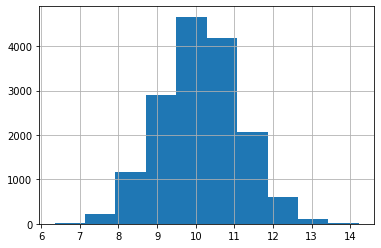

In [102]:
df['mdot_main'].hist()

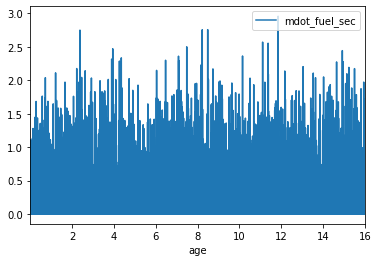

In [100]:
df.plot('age', 'mdot_fuel_sec')